In [1]:
import pandas as pd
import numpy as np

In [2]:
df_model1_0220 = pd.read_csv('model1_0220.csv',encoding='gbk')
df_model1_0310 = pd.read_csv('model1_0310.csv',encoding='gbk')
df_model1_0401 = pd.read_csv('model1_0401.csv',encoding='gbk')
df_model1_0420 = pd.read_csv('model1_0420.csv',encoding='gbk')

In [13]:
df = pd.concat([df_model1_0220,df_model1_0310,df_model1_0401,df_model1_0420],axis=0,ignore_index=True)

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 20 11:19:45 2017

@author: zhangzerong
"""

# 自动化分箱工具
# 根据train的分箱方法，自动替换到总数据集上
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
from scipy.stats import spearmanr

def woe_function(df,df_t,column,woe_type='d',q=5,method='spearmanr',corr=0.95,add_woe=False,woe_sort=False,add_total_woe=True):
    '''
    df 要被处理的数据集
    df_t 总数据集
    column 要被处理的列名
    dtype = 'd' 离散，默认为离散 ;dtype = 'c' 连续
    q = 5 针对连续型和离散型变量的设定不一样。
          针对连续型变量：1）默认连续型变量取值将分为5段，如果需要修改最终分段数，则传入一个数字；
                         2）如果需要按照既定的规则分段，则传入一个列表(注意列表格式，要分成3段，只需要传入两个参数即可，不需要上下界)
          针对离散型变量：1）默认按照离散变量的原始标签类进行分段
                         2）如果需要按照既定的规则分段，则传入一个字典（字典key为原始标签，value为既定规则后的分类）         
    method = 连续型变量分箱收敛方法
            'spearmanr'为斯皮尔曼相关系数，默认为'spearmanr'方法；
            'chi-square'为计算相邻两组卡方值，每次循环合并卡方值最小的两组；
            'minus'为计算相邻两组woe，每次循环合并woe差最小的两组
    add_woe = False 表示是否将woe编码后的列加入到df中，默认False
    woe_sort = False 表示是否将df_woe按照woe的值从小到大排列index，主要针对离散变量
    '''
    if woe_type == 'd':
        df_woe,column_iv = d_plot(df,df_t,column,q,woe_sort)
    elif woe_type == 'c':
        df_woe,column_iv = c_plot(df,df_t,column,q,method,corr) 
    if add_woe:
        woe_dict = dict(zip(df_woe.index,df_woe['woe']))
        df[column+'_woe'] = df[column+'_fillna'].map(woe_dict)
    if add_total_woe:
        woe_dict = dict(zip(df_woe.index,df_woe['woe']))
        df_t[column+'_woe'] = df_t[column+'_fillna'].map(woe_dict)
    df.drop([column+'_fillna'],axis=1,inplace=True)
    df_t.drop([column+'_fillna'],axis=1,inplace=True)
    woe_plot(df_woe,column_iv)
    return df_woe
    
def d_plot(df,df_t,column,q,woe_sort):
    '''
    如果需要对离散型变量的分类做处理，则传入一个字典DC；不传则默认按照原始的分类来处理
    '''
    df[column+'_fillna'] = df[column].fillna('missing_value')  
    df_t[column+'_fillna'] = df_t[column].fillna('missing_value')       
    if type(q) == dict:
        q['missing_value']='missing_value'
        df[column+'_fillna'] = df[column+'_fillna'].map(q)
        df[column+'_fillna'].fillna('others',inplace=True)
        df_t[column+'_fillna'] = df_t[column+'_fillna'].map(q)
        df_t[column+'_fillna'].fillna('others',inplace=True)
        df_woe,column_iv = cal_iv(df,column+'_fillna')
    else:
        df_woe,column_iv = cal_iv(df,column+'_fillna')
    
    if woe_sort:
        '''这里将无序离散变量，按照woe排序'''
        df_woe = df_woe.sort_values('woe')
    return df_woe,column_iv

def c_plot(df,df_t,column,q,method,corr):
    if type(q) != list:
        if method == 'spearmanr':
            q = spearmanr_q(df,column,corr)
        elif method == 'chi-square':
            q = chi_square_q(df,column)
        elif method == 'minus':
            q = chi_square_q(df,column)
    q.insert(0,-np.inf)
    q.append(np.inf)
    df[column+'_fillna'] = pd.cut(df[column],q)
    df_t[column+'_fillna'] = pd.cut(df_t[column],q)
    df[column+'_fillna'] = df[column+'_fillna'].astype(object).fillna('missing_value')
    df_t[column+'_fillna'] = df_t[column+'_fillna'].astype(object).fillna('missing_value')
    df_woe,column_iv = cal_iv(df,column+'_fillna',index_sort=True)
    return df_woe,column_iv

def spearmanr_q(df,column,corr):
    '''
    spearmanr分箱方法
    原理：
        初始用qcut方法分成n段，实际有可能出现少于n段的情况（例如某一段占比大于1/n)
        按照这样的分段计算出df_woe，判断woe的spearman相关系数是否大于corr，如果大于，则停止循环，否则n减少1
        最终必然收敛（在分成两段的时候）
    '''
    r = 0
    n = 15
    while np.abs(r) < corr:
        df[column+'_fillna'],q = pd.qcut(df[column],n,retbins=True,duplicates='drop')
        df[column+'_fillna'] = df[column+'_fillna'].astype(object)
        df[column+'_fillna'] = df[column+'_fillna'].fillna('missing_value')
        df_woe,column_iv = cal_iv(df,column+'_fillna',index_sort=True)
        if 'missing_value' in df_woe:    
            df_woe.drop('missing_value',inplace=True)
        r = spearmanr(range(len(df_woe)),df_woe['woe']).correlation
        q = q.tolist()
        n -= 1
    return q
        
def chi_square_q(df,column):
    '''通过chi_square来确定最优的分箱'''
    n_begin = 50
    df[column+'_fillna'],q = pd.qcut(df[column],n_begin,retbins=True,duplicates='drop')
    df[column+'_fillna'] = df[column+'_fillna'].astype(object).fillna('missing_value')
    df_woe,column_iv = cal_iv(df,column+'_fillna',index_sort=True)
    if 'missing_value' in df_woe:
        df_woe.drop('missing_value',inplace=True)
    q = q.tolist()
    q.pop(0)
    q.pop()
    i = len(q)+1
    while i>5:
        q.insert(0,-np.inf)
        q.append(np.inf)
        df[column+'_fillna'] = pd.cut(df[column],q)
        df[column+'_fillna'] = df[column+'_fillna'].astype(object).fillna('missing_value')
        df_woe,column_iv = cal_iv(df,column+'_fillna',index_sort=True)
        if 'missing_value' in df_woe:
            df_woe.drop('missing_value',inplace=True)
        temp={}
        for i in range(len(df_woe)-1):
            a=df_woe.iloc[i]['bad_count']
            b=df_woe.iloc[i]['good_count']
            c=df_woe.iloc[i+1]['bad_count']
            d=df_woe.iloc[i+1]['good_count']
            temp[i] = (a+b+c+d)*(a*d-b*c)**2/((a+b)*(c+d)*(a+c)*(b+d))
        q.pop(min(temp, key=temp.get)+1) #合并卡方值最小的那一个分类
        q.pop(0)
        q.pop()
        i=len(q)+1
    return q       

def minus_q(df,column):
    '''通过相邻的woe两两比较大小来确定最优的分箱'''
    n_begin = 50
    df[column+'_fillna'],q = pd.qcut(df[column],n,retbins=True,duplicates='drop')
    df[column+'_fillna'] = df[column+'_fillna'].astype(object).fillna('missing_value')
    df_woe,column_iv = cal_iv(df,column+'_fillna',index_sort=True)
    if 'missing_value' in df_woe:
        df_woe.drop('missing_value',inplace=True)
    q = q.tolist()
    q.pop(0)
    q.pop()
    i = len(q)+1
    while i>5:
        q.insert(0,-np.inf)
        q.append(np.inf)
        df[column+'_fillna'] = pd.cut(df[column],q)
        df[column+'_fillna'] = df[column+'_fillna'].astype(object).fillna('missing_value')
        df_woe,column_iv = cal_iv(df,column+'_fillna',index_sort=True)
        if 'missing_value' in df_woe:
            df_woe.drop('missing_value',inplace=True)
        temp={}
        for i in range(len(df_woe)-1):
            temp[i]=abs(df_woe.iloc[i]['woe']-df_woe.iloc[i+1]['woe'])
        q.pop(min(temp, key=temp.get)+1) #合并woe差值最小的那一个分类
        q.pop(0)
        q.pop()
        i=len(q)+1
    return q
    

def cal_iv(df,column,index_sort=False):
    df_bad = df[df['y2']==1].groupby(df[column]).size().to_frame(name='bad_count')
    df_good = df[df['y2']==0].groupby(df[column]).size().to_frame(name='good_count')
    df_woe = pd.merge(df_bad,df_good,how='outer',left_index=True,right_index=True)
    df_woe.fillna(0.001,inplace=True) #为了保证不出现空值
    df_woe['n_group']=df_woe['bad_count']+df_woe['good_count']
    df_woe['bad_rate']=df_woe['bad_count']/df_woe['n_group']
    df_woe['bad_ratio'] = df_woe['bad_count']/sum(df_woe['bad_count'])
    df_woe['good_ratio'] = df_woe['good_count']/sum(df_woe['good_count'])
    df_woe['woe'] = np.log(df_woe['bad_ratio']/df_woe['good_ratio'])
    df_woe['iv'] = (df_woe['bad_ratio']-df_woe['good_ratio'])*df_woe['woe']
    '''分组后可能出现分段不排序的问题，这里将“连续变量”的分段，做一个排序'''
    if index_sort:
        index_list=df_woe.index.tolist()
        if 'missing_value' in index_list:
            index_list.remove('missing_value')
            index_list.sort()
            index_list.append('missing_value')
        else:
            index_list.sort()
        df_woe = df_woe.reindex(index_list)
    column_iv = sum(df_woe['iv'])
    df_woe.drop(['bad_ratio','good_ratio'],axis=1,inplace=True)
    return df_woe,column_iv

'''以下要重新自己写一遍,图形太难看'''
def woe_plot(df_woe,column_iv):
    matplotlib.rcParams.update({'font.size': 12})
    plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False
    fig,ax1 = plt.subplots()
    ax=ax1.twinx()
    ax1.bar(range(len(df_woe)),df_woe.n_group,color='cadetblue')
    ax1.set_ylabel('group number',fontsize=11)
    fig.set_size_inches(10,4)
    ax.plot(range(len(df_woe)),df_woe.woe,marker='d',color='darkslateblue')
    plt.annotate('IV=%s' % "{:2.3f}".format(column_iv), xy=(0.05, 0.90), xycoords='axes fraction',fontsize=12)
    lables=[i for i in df_woe.index]
    pl.xticks(range(len(df_woe)),lables)#,rotation=)
    ax.set_ylabel('woe')
    #ax.grid(b=True)
    ax.set_title('groupy number——woe')
    plt.show()
"""
Created on Thu Sep 28 10:38:02 2017

@author: zhangzerong
"""

#模型结果及评价
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
def credit_card(df,columns,y):
    '''
    df : 要被处理的dataframe
    columns  : 已经woe转换过的列（对应woe_fuction）
    y : 标签列
    '''
    x_train,x_test,y_train,y_test = train_test_split(df[columns],df[y],test_size = 0.3,random_state = 99)
    clf = LogisticRegression()
    clf.fit(x_train,y_train)
    '''输出模型结果'''
    print_log(columns,clf.coef_[0],clf
              .intercept_[0])
    
    train_log_odds = x_train[columns].dot(clf.coef_[0]) + clf.intercept_[0]
    test_log_odds = x_test[columns].dot(clf.coef_[0]) + clf.intercept_[0]    
    train_prob = 1.0/(1+np.exp(-train_log_odds))
    test_prob = 1.0/(1+np.exp(-test_log_odds))
    '''计算分值并打印结果'''
    normal_odds = len(df[df[y]==1])/len(df[df[y]==0])#初始的坏客户/好客户比率
    A,B = get_score(normal_odds)
    train_score = A + B * train_log_odds
    test_score = A + B * test_log_odds
    print('the score is given by : score = %s %s * ln(odds)' % (A,B))
    print('tips : odds = p/(1-p)')
    print('\n'+'  =￣ω￣=  ' * 10+'\n')
    '''输出ks值'''
    fig,ax=plt.subplots()
    aa=ks_chart(ax,train_score,y_train,'Train',style='-',set_ax=True)
    bb=ks_chart(ax,test_score,y_test,'Test',style='--',set_ax=False)
    ax.legend(aa[0]+bb[0],aa[1]+bb[1],loc='upper left')
    '''输出ROC曲线（附带AUC\GINI）'''
    ROC_curve([(y_train,train_prob,'train'),(y_test,test_prob,'test')]) 
    
def print_log(columns,coef,intercept):
    print ('the logistic regression result is :')
    print ('ln[p/(1-p)] = %s' % intercept)
    for i in range(len(columns)):
        if coef[i]>=0:
            sign = '+'
        else:
            sign = ''
        print(' '* 14 + sign + '%s * %s' % (coef[i],columns[i]))

def ROC_curve(params):
    fig,ax=plt.subplots()
    text = ''
    for param in params:
        label,prob,name = param
        fpr,tpr,_ = metrics.roc_curve(label,prob)
        ax.plot(fpr,tpr,'-',label=name)
        AUC = metrics.auc(fpr,tpr)
        GINI = 2 * AUC - 1
        text = text + '%s AUC:  %s\n' % (name,"{:10.3f}".format(AUC))
        text = text + '%s GINI: %s\n' % (name,"{:10.3f}".format(GINI))
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('ROC Curve',fontsize=13)
    ax.legend(loc='center right')
    ax.text(0.6,-0.1,text)
    plt.show()

def get_score(normal_odds,base_score=500,pdo=100):
    '''
    基础分为500分，每降低100分，odds翻倍；分值越大说明用户越好（为了便于理解）
    '''
    b = - pdo / np.log(2)
    a = base_score - b*np.log(normal_odds)
    return a,b

def percentile(a,scores):
    percentiles=[]
    for s in scores:
        percentiles.append(stats.percentileofscore(a,s))
    return np.array(percentiles)

def ks_chart(ax,score,y,label, style='-', print_ks=False,set_ax=True):
    '''
    ax:    Matplotlib Axes
    score: score array (np array or pandas column)
    y:     good / bad lables
    print_ks: need print KS value on the plot or not
    set_ax : need make some setting for the plot or not
    '''
    ax1 = ax.twinx()
    bins = np.linspace(score.min(),score.max(),200)
    groups=score.groupby(y)
    cumlative_per=[]
    axes=[]
    labels=[]
    for group,data in groups:
        q=percentile(data,bins)
        cumlative_per.append(q)
        lab = '%s (%s)' % ("{:1.0f}".format(group),label)
        labels.append(lab)
        a=ax1.plot(bins,q,style,label=lab,lw=1.5)
        if isinstance(a,list):
            axes.append(a[0])
        else:
            axes.append(a)
    ks_values=cumlative_per[1]-cumlative_per[0]
    if len(ks_values[ks_values<0])>0.9*len(bins):
        ks_values = -ks_values
    max_ks=np.max(ks_values)
    lab='KS (%s)' % label
    labels.append(lab)
    a=ax.plot(bins,ks_values,style,label=lab,lw=0.5)
    if isinstance(a,list):
        axes.append(a[0])
    else:
        axes.append(a)
    ax.grid(b=True,linestyle='--')
    if print_ks:
        ax.text(0.8, 0.97,'Max K-S:%s' % "{:10.2f}".format(max_ks),  horizontalalignment='center',  verticalalignment='center', transform = ax.transAxes,fontsize=11)
    if set_ax:
        ax.set_title('KS plot',fontsize=13)
        ax.set_xlabel('score')
        ax.set_ylabel('K-S Value')
        ax1.set_ylabel('Cumulative percentage')
    print ('the ks of %s is %s' % (label,"{:1.2f}".format(max_ks)))
    return  axes,labels
from sklearn.model_selection import train_test_split

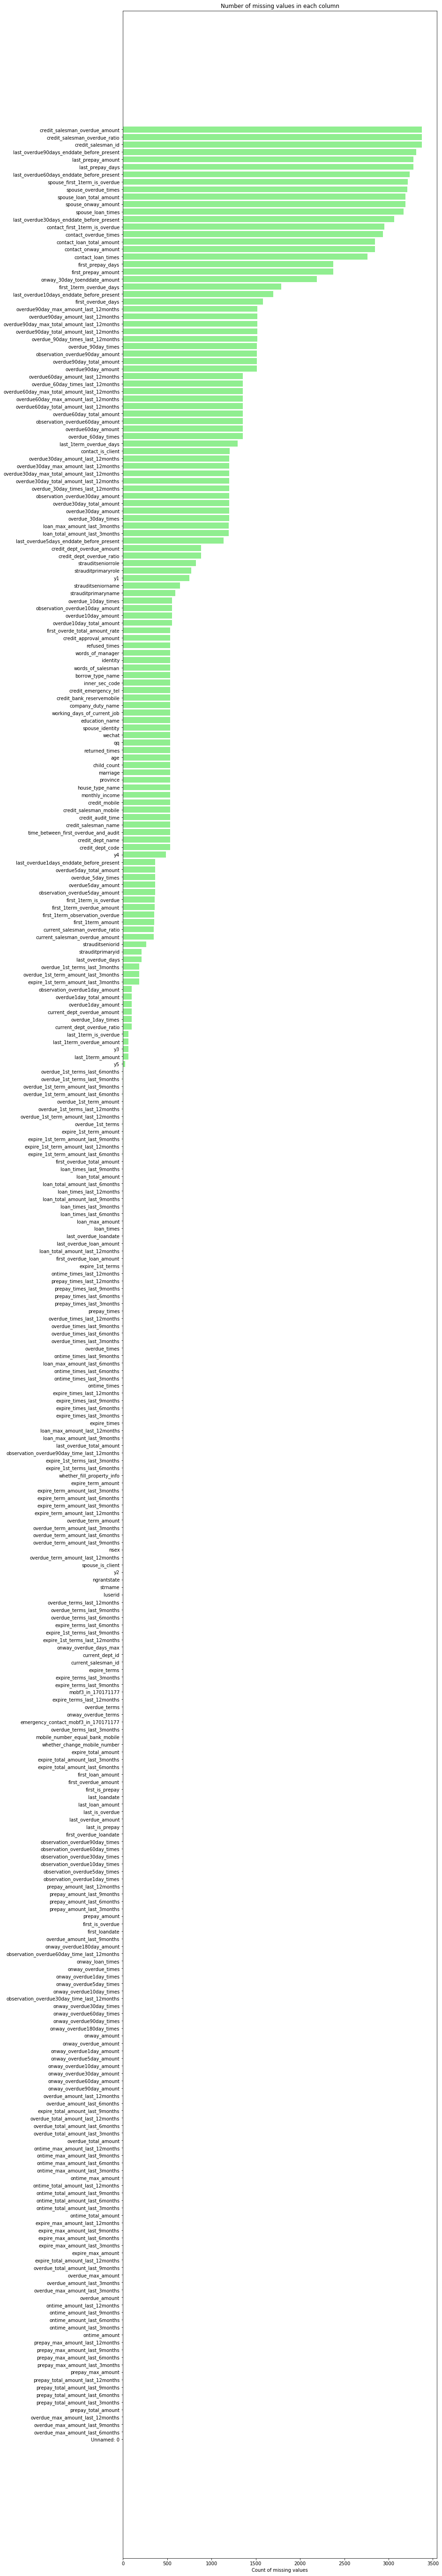

In [15]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
#missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig,ax = plt.subplots(figsize=(12,100))
rects = ax.barh(ind, missing_df.missing_count.values,color='lightgreen')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values,rotation='horizontal')
ax.set_xlabel('Count of missing values')
ax.set_title('Number of missing values in each column')
plt.show()

In [16]:
#train,test
df_train,df_test = train_test_split(df,test_size = 0.3,random_state = 99)
df_train = df_train.sort_index(ascending=True)
df_test = df_test.sort_index(ascending=True)

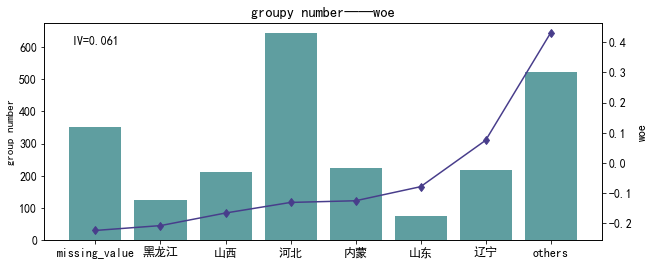

bad_count  good_count  n_group  bad_rate       woe        iv
province_fillna                                                              
missing_value          112         239      351  0.319088 -0.223369  0.007172
黑龙江                     40          84      124  0.322581 -0.207342  0.002189
山西                      70         141      211  0.331754 -0.165669  0.002394
河北                     218         424      642  0.339564 -0.130643  0.004553
内蒙                      76         147      223  0.340807 -0.125103  0.001451
山东                      26          48       74  0.351351 -0.078509  0.000191
辽宁                      84         133      217  0.387097  0.075064  0.000522
others                 247         274      521  0.474088  0.430856  0.042672

In [17]:
woe_function(df_train,df,'province',q={13:'河北',14:'山西',15:'内蒙',21:'辽宁',23:'黑龙江',37:'山东'},woe_sort=True)

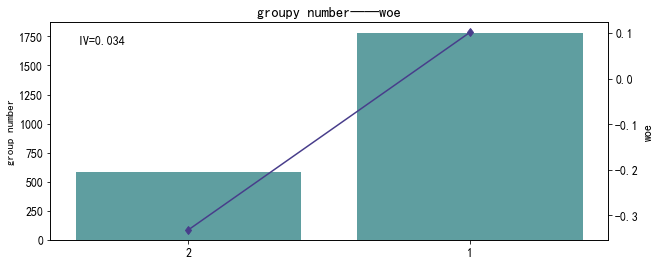

bad_count  good_count  n_group  bad_rate       woe        iv
nsex_fillna                                                              
2                  172         409      581  0.296041 -0.331625  0.025693
1                  701        1081     1782  0.393378  0.101462  0.007861

In [18]:
woe_function(df_train,df,'nsex',woe_sort=True)

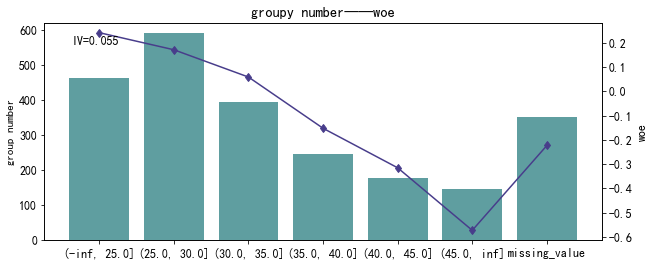

bad_count  good_count  n_group  bad_rate       woe        iv
age_fillna                                                                 
(-inf, 25.0]         197         264      461  0.427332  0.241850  0.011724
(25.0, 30.0]         242         348      590  0.410169  0.171331  0.007478
(30.0, 35.0]         151         243      394  0.383249  0.058814  0.000581
(35.0, 40.0]          82         163      245  0.334694 -0.152435  0.002358
(40.0, 45.0]          53         124      177  0.299435 -0.315394  0.007100
(45.0, inf]           36         109      145  0.248276 -0.573233  0.018296
missing_value        112         239      351  0.319088 -0.223369  0.007172

In [22]:
woe_function(df_train,df,'age',woe_type='c',q=[25,30,35,40,45])

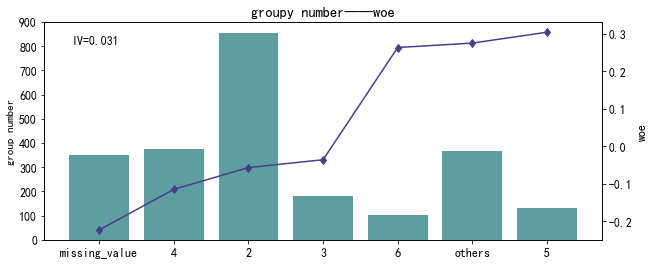

bad_count  good_count  n_group  bad_rate       woe  \
company_duty_name_fillna                                                       
missing_value                   112         239      351  0.319088 -0.223369   
4                               129         247      376  0.343085 -0.114980   
2                               305         551      856  0.356308 -0.056827   
3                                65         115      180  0.361111 -0.035949   
6                                45          59      104  0.432692  0.263721   
others                          159         206      365  0.435616  0.275624   
5                                58          73      131  0.442748  0.304579   

                                iv  
company_duty_name_fillna            
missing_value             0.007172  
4                         0.002070  
2                         0.001161  
3                         0.000098  
6                         0.003151  
others                    0.012093  
5                         0.005313

In [23]:
woe_function(df_train,df,'company_duty_name',q={ '销售/中介/业务代表/促销':2,
       '个体':2,
       '司机':2,
       '商业、服务业人员':2,
       '高层管理人员/总监以上/局级以上干部':3,
       '基层管理人员/主管组长/科员':4,
       '中层管理人员.经理以上/科级以上干部':4,
       '专业（技术）人员':5,
       '工人(包括生产、加工、建筑和设备操作人员及有关人员)':6,
       '农民':6,
       '保安/治安/防损':6
},woe_sort=True)

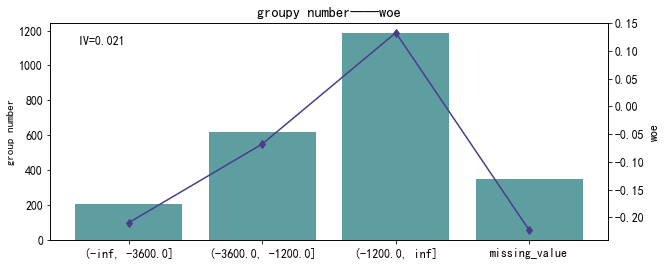

bad_count  good_count  n_group  bad_rate  \
working_days_of_current_job_fillna                                             
(-inf, -3600.0]                            67         141      208  0.322115   
(-3600.0, -1200.0]                        219         400      619  0.353796   
(-1200.0, inf]                            475         710     1185  0.400844   
missing_value                             112         239      351  0.319088   

                                         woe        iv  
working_days_of_current_job_fillna                      
(-inf, -3600.0]                    -0.209471  0.003746  
(-3600.0, -1200.0]                 -0.067797  0.001193  
(-1200.0, inf]                      0.132646  0.008966  
missing_value                      -0.223369  0.007172

In [33]:
woe_function(df_train,df,'working_days_of_current_job',woe_type='c',q=
             [-3600,-1200])

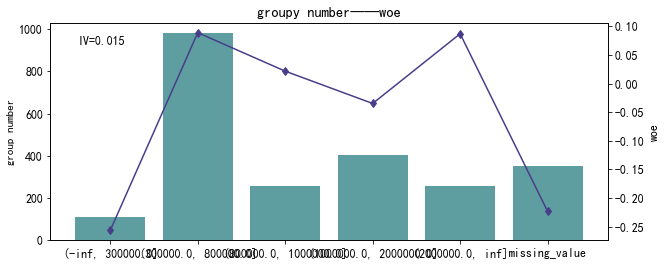

bad_count  good_count  n_group  bad_rate       woe  \
monthly_income_fillna                                                        
(-inf, 300000.0]               34          75      109  0.311927 -0.256532   
(300000.0, 800000.0]          383         598      981  0.390418  0.089040   
(800000.0, 1000000.0]          97         162      259  0.374517  0.021710   
(1000000.0, 2000000.0]        146         258      404  0.361386 -0.034757   
(2000000.0, inf]              101         158      259  0.389961  0.087121   
missing_value                 112         239      351  0.319088 -0.223369   

                              iv  
monthly_income_fillna             
(-inf, 300000.0]        0.002922  
(300000.0, 800000.0]    0.003328  
(800000.0, 1000000.0]   0.000052  
(1000000.0, 2000000.0]  0.000206  
(2000000.0, inf]        0.000841  
missing_value           0.007172

In [45]:
woe_function(df_train,df,'monthly_income',woe_type='c',q=[300000,800000,1000000,2000000])

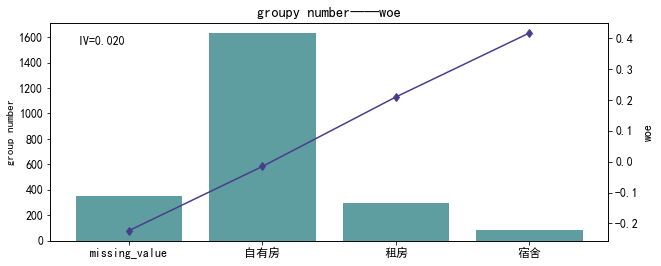

bad_count  good_count  n_group  bad_rate       woe  \
house_type_name_fillna                                                       
missing_value                 112         239      351  0.319088 -0.223369   
自有房                           596        1033     1629  0.365869 -0.015386   
租房                            125         173      298  0.419463  0.209618   
宿舍                             40          45       85  0.470588  0.416813   

                              iv  
house_type_name_fillna            
missing_value           0.007172  
自有房                     0.000163  
租房                      0.005676  
宿舍                      0.006510

In [46]:
woe_function(df_train,df,'house_type_name',woe_sort=True)

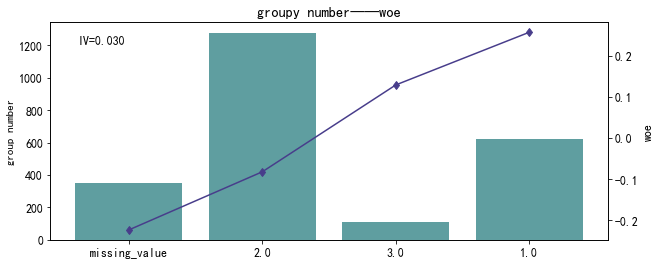

bad_count  good_count  n_group  bad_rate       woe        iv
marriage_fillna                                                              
missing_value          112         239      351  0.319088 -0.223369  0.007172
2.0                    448         830     1278  0.350548 -0.082037  0.003599
3.0                     44          66      110  0.400000  0.129131  0.000788
1.0                    269         355      624  0.431090  0.257189  0.017972

In [47]:
woe_function(df_train,df,'marriage',woe_sort=True)

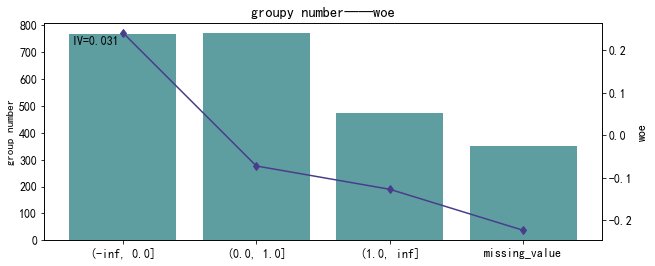

bad_count  good_count  n_group  bad_rate       woe  \
child_count_fillna                                                       
(-inf, 0.0]               328         440      768  0.427083  0.240835   
(0.0, 1.0]                272         499      771  0.352789 -0.072208   
(1.0, inf]                161         312      473  0.340381 -0.127003   
missing_value             112         239      351  0.319088 -0.223369   

                          iv  
child_count_fillna            
(-inf, 0.0]         0.019366  
(0.0, 1.0]          0.001685  
(1.0, inf]          0.003172  
missing_value       0.007172

In [50]:
woe_function(df_train,df,'child_count',q=[0,1],woe_type='c')

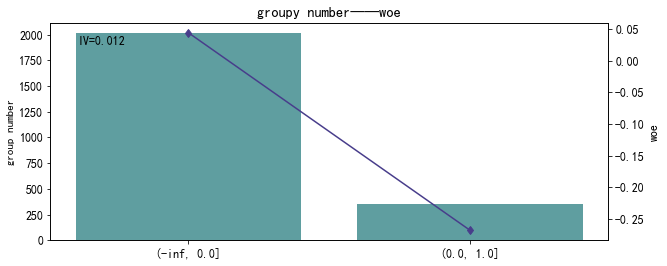

bad_count  good_count  n_group  bad_rate  \
whether_fill_property_info_fillna                                             
(-inf, 0.0]                              765        1249     2014  0.379841   
(0.0, 1.0]                               108         241      349  0.309456   

                                        woe        iv  
whether_fill_property_info_fillna                      
(-inf, 0.0]                        0.044373  0.001688  
(0.0, 1.0]                        -0.268070  0.010196

In [51]:
woe_function(df_train,df,'whether_fill_property_info',q=[0,1],woe_type='c')

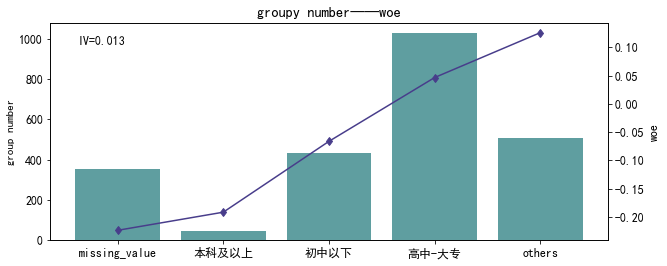

bad_count  good_count  n_group  bad_rate       woe  \
education_name_fillna                                                       
missing_value                112         239      351  0.319088 -0.223369   
本科及以上                         15          31       46  0.326087 -0.191341   
初中以下                         153         279      432  0.354167 -0.066178   
高中-大专                        391         637     1028  0.380350  0.046534   
others                       202         304      506  0.399209  0.125836   

                             iv  
education_name_fillna            
missing_value          0.007172  
本科及以上                  0.000693  
初中以下                   0.000794  
高中-大专                  0.000948  
others                 0.003443

In [52]:
woe_function(df_train,df,'education_name',q={'博士':'本科及以上',
        '博士后':'本科及以上',
        '硕士':'本科及以上',
        '本科':'本科及以上',
        '大专':'高中-大专',
        '职高/中专/技术学校':'高中-大专',
        '高中':'高中-大专',
        '初中':'初中以下',
        '小学':'初中以下'},woe_sort=True)

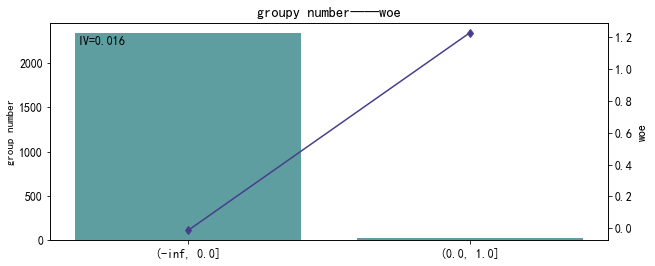

bad_count  good_count  n_group  bad_rate       woe  \
mobf3_in_170171177_fillna                                                       
(-inf, 0.0]                      857        1482     2339  0.366396 -0.013114   
(0.0, 1.0]                        16           8       24  0.666667  1.227743   

                                iv  
mobf3_in_170171177_fillna           
(-inf, 0.0]                0.00017  
(0.0, 1.0]                 0.01591

In [53]:
woe_function(df_train,df,'mobf3_in_170171177',q=[0,1],woe_type='c')

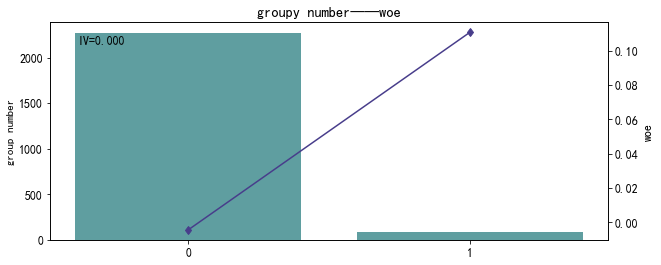

bad_count  good_count  n_group  bad_rate  \
whether_change_mobile_number_fillna                                             
0                                          837        1435     2272  0.368398   
1                                           36          55       91  0.395604   

                                          woe        iv  
whether_change_mobile_number_fillna                      
0                                   -0.004500  0.000019  
1                                    0.110782  0.000479

In [54]:
woe_function(df_train,df,'whether_change_mobile_number')

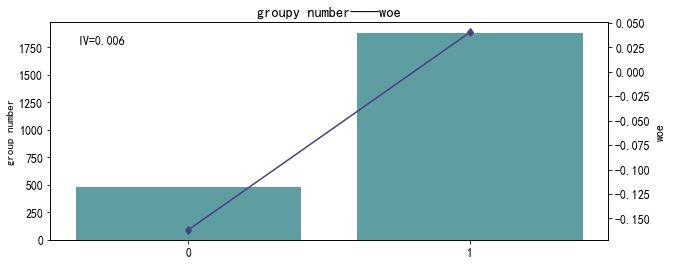

bad_count  good_count  n_group  \
mobile_number_equal_bank_mobile_fillna                                   
0                                             160         321      481   
1                                             713        1169     1882   

                                        bad_rate       woe        iv  
mobile_number_equal_bank_mobile_fillna                                
0                                       0.332640 -0.161671  0.005199  
1                                       0.378852  0.040173  0.001292

In [55]:
woe_function(df_train,df,'mobile_number_equal_bank_mobile')

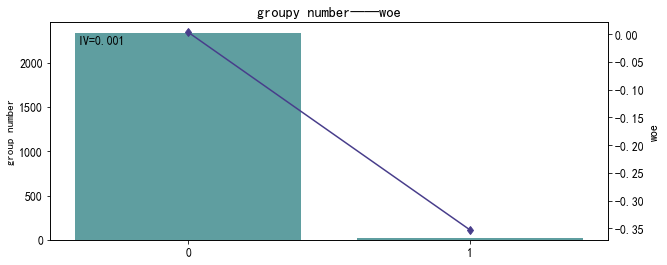

bad_count  good_count  n_group  \
emergency_contact_mobf3_in_170171177_fillna                                   
0                                                  866        1473     2339   
1                                                    7          17       24   

                                             bad_rate       woe        iv  
emergency_contact_mobf3_in_170171177_fillna                                
0                                            0.370244  0.003424  0.000012  
1                                            0.291667 -0.352707  0.001196

In [56]:
woe_function(df_train,df,'emergency_contact_mobf3_in_170171177')

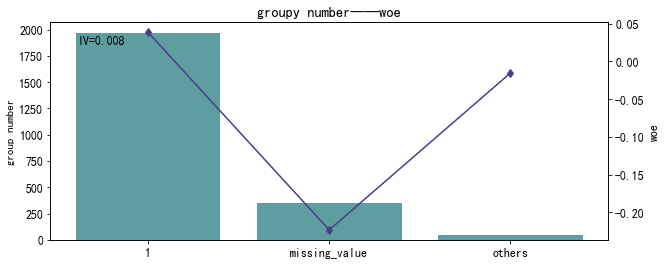

bad_count  good_count  n_group  bad_rate       woe  \
inner_sec_code_fillna                                                       
1                            746        1225     1971  0.378488  0.038625   
missing_value                112         239      351  0.319088 -0.223369   
others                        15          26       41  0.365854 -0.015450   

                             iv  
inner_sec_code_fillna            
1                      0.001251  
missing_value          0.007172  
others                 0.000004

In [57]:
woe_function(df_train,df,'inner_sec_code',q={1:1})

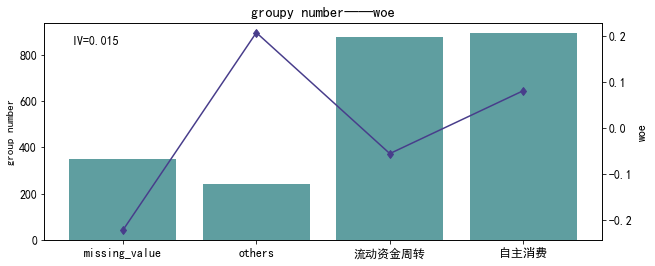

bad_count  good_count  n_group  bad_rate       woe  \
borrow_type_name_fillna                                                       
missing_value                  112         239      351  0.319088 -0.223369   
others                         101         140      241  0.419087  0.208074   
流动资金周转                         313         565      878  0.356492 -0.056027   
自主消费                           347         546      893  0.388578  0.081302   

                               iv  
borrow_type_name_fillna            
missing_value            0.007172  
others                   0.004522  
流动资金周转                   0.001158  
自主消费                     0.002523

In [58]:
woe_function(df_train,df,'borrow_type_name',q={'流动资金周转':'流动资金周转','自主消费':'自主消费'})

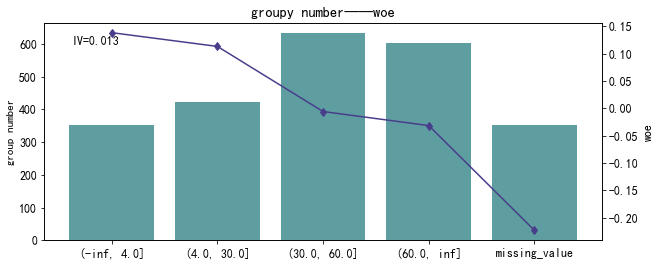

bad_count  good_count  n_group  bad_rate       woe  \
words_of_salesman_fillna                                                       
(-inf, 4.0]                     142         211      353  0.402266  0.138565   
(4.0, 30.0]                     168         256      424  0.396226  0.113382   
(30.0, 60.0]                    233         400      633  0.368088 -0.005830   
(60.0, inf]                     218         384      602  0.362126 -0.031552   
missing_value                   112         239      351  0.319088 -0.223369   

                                iv  
words_of_salesman_fillna            
(-inf, 4.0]               0.002916  
(4.0, 30.0]               0.002339  
(30.0, 60.0]              0.000009  
(60.0, inf]               0.000253  
missing_value             0.007172

In [66]:
woe_function(df_train,df,'words_of_salesman',q=[4,30,60],woe_type='c')

d:\users\zhangzerong\appdata\local\programs\python\python36\lib\site-packages\pandas\core\reshape\merge.py:722: RuntimeWarning: unorderable types: Interval() < str(), sort order is undefined for incomparable objects
  sort=self.sort)


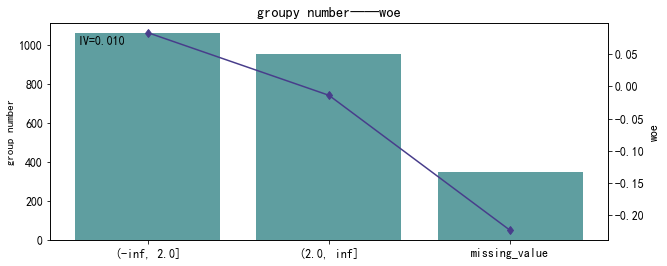

bad_count  good_count  n_group  bad_rate       woe  \
words_of_manager_fillna                                                       
(-inf, 2.0]                    412         647     1059  0.389046  0.083273   
(2.0, inf]                     349         604      953  0.366212 -0.013906   
missing_value                  112         239      351  0.319088 -0.223369   

                               iv  
words_of_manager_fillna            
(-inf, 2.0]              0.003140  
(2.0, inf]               0.000078  
missing_value            0.007172

In [73]:
woe_function(df_train,df,'words_of_manager',q=[2],woe_type='c')

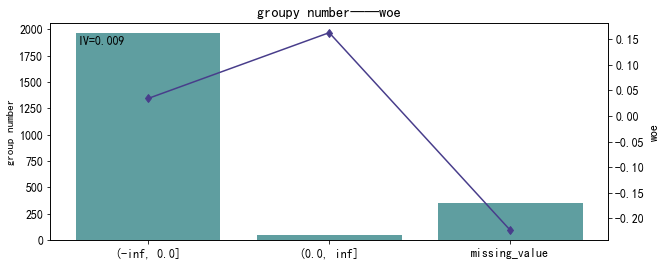

bad_count  good_count  n_group  bad_rate       woe  \
refused_times_fillna                                                       
(-inf, 0.0]                 741        1222     1963  0.377483  0.034352   
(0.0, inf]                   20          29       49  0.408163  0.163032   
missing_value               112         239      351  0.319088 -0.223369   

                            iv  
refused_times_fillna            
(-inf, 0.0]           0.000985  
(0.0, inf]            0.000562  
missing_value         0.007172

In [77]:
woe_function(df_train,df,'refused_times',q=[0],woe_type='c')

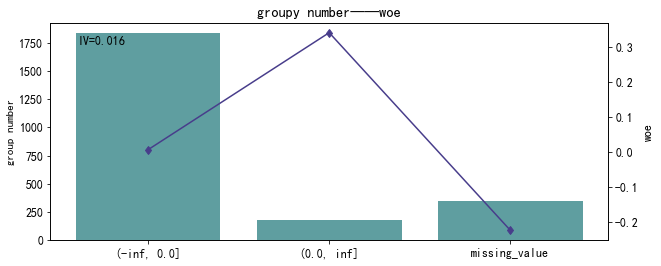

bad_count  good_count  n_group  bad_rate       woe  \
returned_times_fillna                                                       
(-inf, 0.0]                  681        1154     1835  0.371117  0.007169   
(0.0, inf]                    80          97      177  0.451977  0.341911   
missing_value                112         239      351  0.319088 -0.223369   

                             iv  
returned_times_fillna            
(-inf, 0.0]            0.000040  
(0.0, inf]             0.009073  
missing_value          0.007172

In [76]:
woe_function(df_train,df,'returned_times',q=[0],woe_type='c')

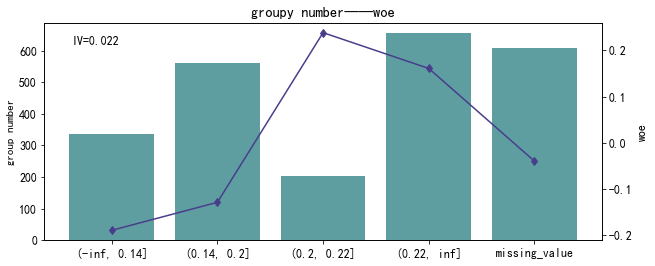

bad_count  good_count  n_group  bad_rate  \
credit_dept_overdue_ratio_fillna                                             
(-inf, 0.14]                            110         227      337  0.326409   
(0.14, 0.2]                             190         369      559  0.339893   
(0.2, 0.22]                              87         117      204  0.426471   
(0.22, inf]                             267         388      655  0.407634   
missing_value                           219         389      608  0.360197   

                                       woe        iv  
credit_dept_overdue_ratio_fillna                      
(-inf, 0.14]                     -0.189874  0.005003  
(0.14, 0.2]                      -0.129177  0.003877  
(0.2, 0.22]                       0.238330  0.005037  
(0.22, inf]                       0.160839  0.007308  
missing_value                    -0.039912  0.000408

In [97]:
woe_function(df_train,df,'credit_dept_overdue_ratio',q=[0.14,0.2,0.22],woe_type='c')

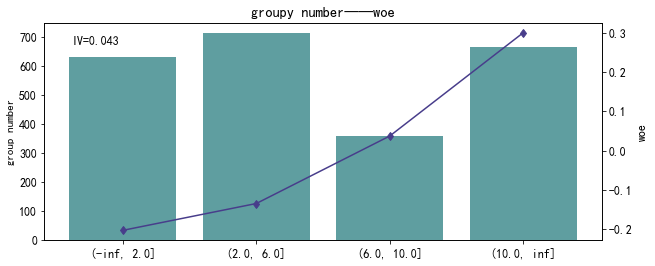

bad_count  good_count  n_group  bad_rate       woe  \
loan_times_fillna                                                       
(-inf, 2.0]              204         427      631  0.323296 -0.204068   
(2.0, 6.0]               241         471      712  0.338483 -0.135465   
(6.0, 10.0]              135         222      357  0.378151  0.037193   
(10.0, inf]              293         370      663  0.441931  0.301265   

                         iv  
loan_times_fillna            
(-inf, 2.0]        0.010795  
(2.0, 6.0]         0.005425  
(6.0, 10.0]        0.000210  
(10.0, inf]        0.026301

In [102]:
woe_function(df_train,df,'loan_times',q=[2,6,10],woe_type='c')

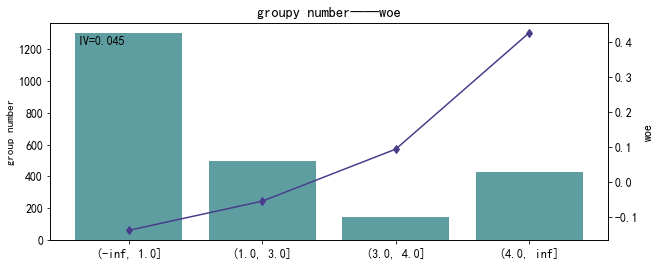

bad_count  good_count  n_group  bad_rate  \
loan_times_last_3months_fillna                                             
(-inf, 1.0]                           439         860     1299  0.337952   
(1.0, 3.0]                            177         319      496  0.356855   
(3.0, 4.0]                             56          87      143  0.391608   
(4.0, inf]                            201         224      425  0.472941   

                                     woe        iv  
loan_times_last_3months_fillna                      
(-inf, 1.0]                    -0.137837  0.010244  
(1.0, 3.0]                     -0.054446  0.000618  
(3.0, 4.0]                      0.094039  0.000541  
(4.0, inf]                      0.426255  0.034060

In [106]:
woe_function(df_train,df,'loan_times_last_3months',q=[1,3,4],woe_type='c')

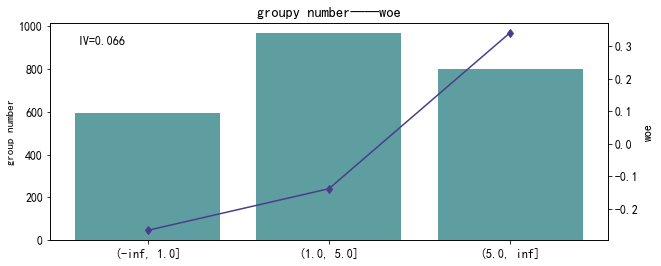

bad_count  good_count  n_group  bad_rate  \
loan_times_last_6months_fillna                                             
(-inf, 1.0]                           184         410      594  0.309764   
(1.0, 5.0]                            327         641      968  0.337810   
(5.0, inf]                            362         439      801  0.451935   

                                     woe        iv  
loan_times_last_6months_fillna                      
(-inf, 1.0]                    -0.266626  0.017171  
(1.0, 5.0]                     -0.138473  0.007703  
(5.0, inf]                      0.341741  0.041020

In [112]:
woe_function(df_train,df,'loan_times_last_6months',q=[1,5],woe_type='c')

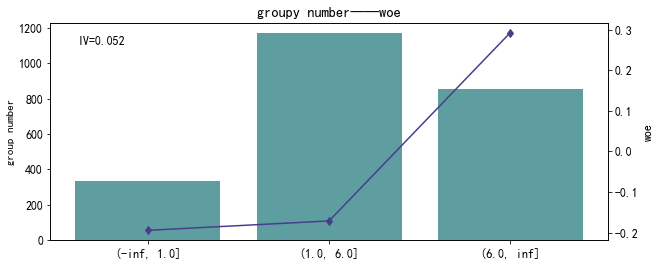

bad_count  good_count  n_group  bad_rate  \
loan_times_last_9months_fillna                                             
(-inf, 1.0]                           109         226      335  0.325373   
(1.0, 6.0]                            387         784     1171  0.330487   
(6.0, inf]                            377         480      857  0.439907   

                                     woe        iv  
loan_times_last_9months_fillna                      
(-inf, 1.0]                    -0.194591  0.005219  
(1.0, 6.0]                     -0.171388  0.014204  
(6.0, inf]                      0.293055  0.032147

In [117]:
woe_function(df_train,df,'loan_times_last_9months',q=[1,6],woe_type='c')

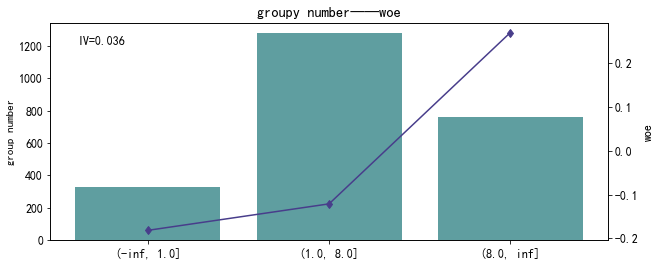

bad_count  good_count  n_group  bad_rate  \
loan_times_last_12months_fillna                                             
(-inf, 1.0]                            107         219      326  0.328221   
(1.0, 8.0]                             437         842     1279  0.341673   
(8.0, inf]                             329         429      758  0.434037   

                                      woe        iv  
loan_times_last_12months_fillna                      
(-inf, 1.0]                     -0.181647  0.004435  
(1.0, 8.0]                      -0.121251  0.007824  
(8.0, inf]                       0.269197  0.023943

In [120]:
woe_function(df_train,df,'loan_times_last_12months',q=[1,8],woe_type='c')

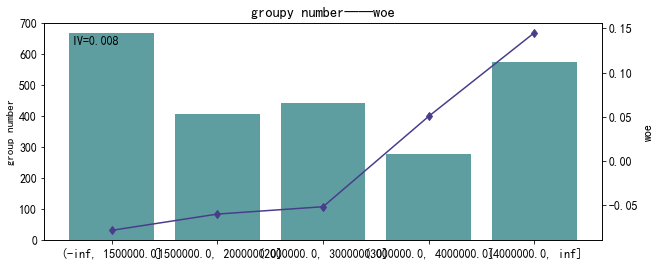

bad_count  good_count  n_group  bad_rate       woe  \
loan_total_amount_fillna                                                       
(-inf, 1500000.0]               234         432      666  0.351351 -0.078509   
(1500000.0, 2000000.0]          144         261      405  0.355556 -0.060111   
(2000000.0, 3000000.0]          158         284      442  0.357466 -0.051783   
(3000000.0, 4000000.0]          106         172      278  0.381295  0.050540   
(4000000.0, inf]                231         341      572  0.403846  0.145131   

                                iv  
loan_total_amount_fillna            
(-inf, 1500000.0]         0.001719  
(1500000.0, 2000000.0]    0.000614  
(2000000.0, 3000000.0]    0.000498  
(3000000.0, 4000000.0]    0.000302  
(4000000.0, inf]          0.005188

In [125]:
woe_function(df_train,df,'loan_total_amount',q=[1500000,2000000,3000000,4000000],woe_type='c')

d:\users\zhangzerong\appdata\local\programs\python\python36\lib\site-packages\pandas\core\reshape\merge.py:722: RuntimeWarning: unorderable types: Interval() < str(), sort order is undefined for incomparable objects
  sort=self.sort)


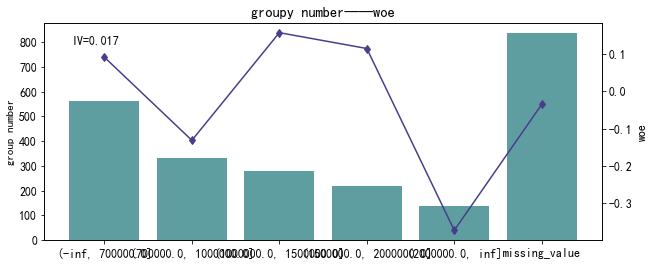

bad_count  good_count  n_group  \
loan_total_amount_last_3months_fillna                                   
(-inf, 700000.0]                             220         343      563   
(700000.0, 1000000.0]                        112         218      330   
(1000000.0, 1500000.0]                       113         165      278   
(1500000.0, 2000000.0]                        86         131      217   
(2000000.0, inf]                              40          99      139   
missing_value                                302         534      836   

                                       bad_rate       woe        iv  
loan_total_amount_last_3months_fillna                                
(-inf, 700000.0]                       0.390764  0.090493  0.001973  
(700000.0, 1000000.0]                  0.339394 -0.131400  0.002367  
(1000000.0, 1500000.0]                 0.406475  0.156038  0.002918  
(1500000.0, 2000000.0]                 0.396313  0.113746  0.001205  
(2000000.0, inf]                       0.287770 -0.371645  0.007665  
missing_value                          0.361244 -0.035373  0.000441

In [127]:
woe_function(df_train,df,'loan_total_amount_last_3months',q=[700000,1000000,1500000,2000000],woe_type='c')

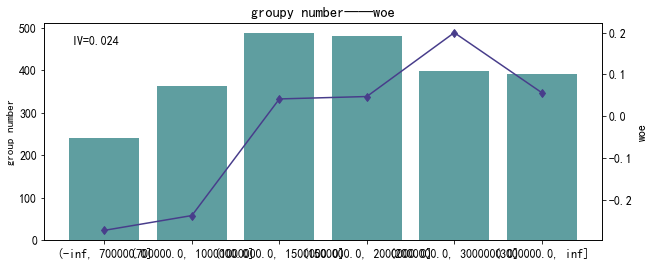

bad_count  good_count  n_group  \
loan_total_amount_last_6months_fillna                                   
(-inf, 700000.0]                              74         166      240   
(700000.0, 1000000.0]                        115         249      364   
(1000000.0, 1500000.0]                       185         303      488   
(1500000.0, 2000000.0]                       183         298      481   
(2000000.0, 3000000.0]                       166         232      398   
(3000000.0, inf]                             150         242      392   

                                       bad_rate       woe        iv  
loan_total_amount_last_6months_fillna                                
(-inf, 700000.0]                       0.308333 -0.273327  0.007283  
(700000.0, 1000000.0]                  0.315934 -0.237925  0.008419  
(1000000.0, 1500000.0]                 0.379098  0.041219  0.000353  
(1500000.0, 2000000.0]                 0.380457  0.046989  0.000452  
(2000000.0, 3000000.0]                 0.417085  0.199846  0.006884  
(3000000.0, inf]                       0.382653  0.056293  0.000529

In [129]:
woe_function(df_train,df,'loan_total_amount_last_6months',q=[700000,1000000,1500000,2000000,3000000],woe_type='c')

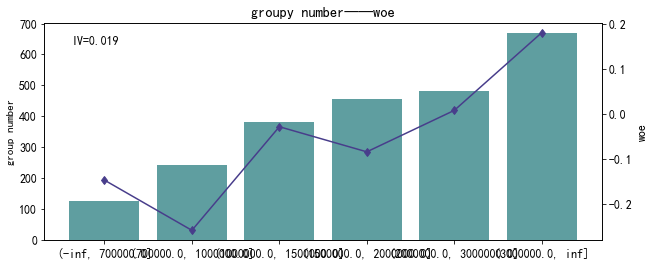

bad_count  good_count  n_group  \
loan_total_amount_last_9months_fillna                                   
(-inf, 700000.0]                              43          85      128   
(700000.0, 1000000.0]                         76         168      244   
(1000000.0, 1500000.0]                       139         244      383   
(1500000.0, 2000000.0]                       160         297      457   
(2000000.0, 3000000.0]                       179         303      482   
(3000000.0, inf]                             276         393      669   

                                       bad_rate       woe        iv  
loan_total_amount_last_9months_fillna                                
(-inf, 700000.0]                       0.335938 -0.146855  0.001144  
(700000.0, 1000000.0]                  0.311475 -0.258635  0.006646  
(1000000.0, 1500000.0]                 0.362924 -0.028098  0.000127  
(1500000.0, 2000000.0]                 0.350109 -0.083962  0.001348  
(2000000.0, 3000000.0]                 0.371369  0.008249  0.000014  
(3000000.0, inf]                       0.412556  0.181187  0.009493

In [130]:
woe_function(df_train,df,'loan_total_amount_last_9months',q=[700000,1000000,1500000,2000000,3000000],woe_type='c')

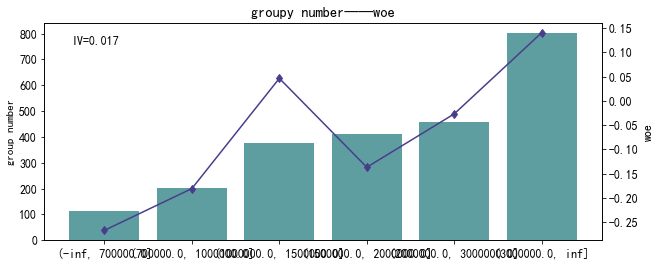

bad_count  good_count  n_group  \
loan_total_amount_last_12months_fillna                                   
(-inf, 700000.0]                               35          78      113   
(700000.0, 1000000.0]                          67         137      204   
(1000000.0, 1500000.0]                        143         233      376   
(1500000.0, 2000000.0]                        139         272      411   
(2000000.0, 3000000.0]                        166         291      457   
(3000000.0, inf]                              323         479      802   

                                        bad_rate       woe        iv  
loan_total_amount_last_12months_fillna                                
(-inf, 700000.0]                        0.309735 -0.266765  0.003270  
(700000.0, 1000000.0]                   0.328431 -0.180692  0.002746  
(1000000.0, 1500000.0]                  0.380319  0.046402  0.000345  
(1500000.0, 2000000.0]                  0.338200 -0.136732  0.003190  
(2000000.0, 3000000.0]                  0.363239 -0.026740  0.000138  
(3000000.0, inf]                        0.402743  0.140548  0.006818

In [131]:
woe_function(df_train,df,'loan_total_amount_last_12months',q=[700000,1000000,1500000,2000000,3000000],woe_type='c')

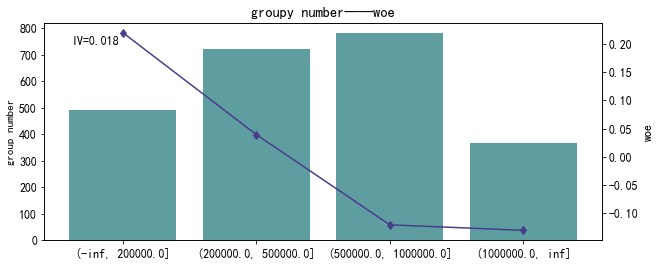

bad_count  good_count  n_group  bad_rate       woe  \
loan_max_amount_fillna                                                       
(-inf, 200000.0]              208         285      493  0.421907  0.219645   
(200000.0, 500000.0]          273         448      721  0.378641  0.039274   
(500000.0, 1000000.0]         267         514      781  0.341869 -0.120379   
(1000000.0, inf]              125         243      368  0.339674 -0.130152   

                              iv  
loan_max_amount_fillna            
(-inf, 200000.0]        0.010320  
(200000.0, 500000.0]    0.000473  
(500000.0, 1000000.0]   0.004710  
(1000000.0, inf]        0.002590

In [132]:
woe_function(df_train,df,'loan_max_amount',q=[200000,500000,1000000],woe_type='c')

d:\users\zhangzerong\appdata\local\programs\python\python36\lib\site-packages\pandas\core\reshape\merge.py:722: RuntimeWarning: unorderable types: Interval() < str(), sort order is undefined for incomparable objects
  sort=self.sort)


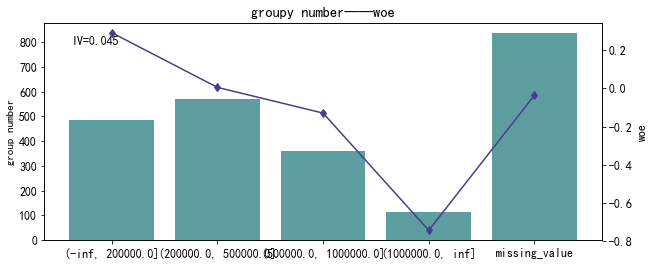

bad_count  good_count  n_group  bad_rate  \
loan_max_amount_last_3months_fillna                                             
(-inf, 200000.0]                           213         271      484  0.440083   
(200000.0, 500000.0]                       211         358      569  0.370826   
(500000.0, 1000000.0]                      122         237      359  0.339833   
(1000000.0, inf]                            25          90      115  0.217391   
missing_value                              302         534      836  0.361244   

                                          woe        iv  
loan_max_amount_last_3months_fillna                      
(-inf, 200000.0]                     0.293769  0.018245  
(200000.0, 500000.0]                 0.005921  0.000008  
(500000.0, 1000000.0]               -0.129443  0.002500  
(1000000.0, inf]                    -0.746338  0.023708  
missing_value                       -0.035373  0.000441

In [133]:
woe_function(df_train,df,'loan_max_amount_last_3months',q=[200000,500000,1000000],woe_type='c')

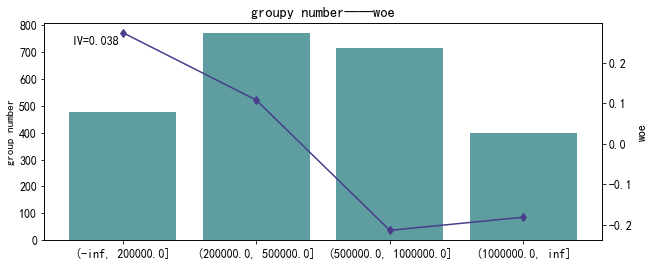

bad_count  good_count  n_group  bad_rate  \
loan_max_amount_last_6months_fillna                                             
(-inf, 200000.0]                           208         270      478  0.435146   
(200000.0, 500000.0]                       304         466      770  0.394805   
(500000.0, 1000000.0]                      230         486      716  0.321229   
(1000000.0, inf]                           131         268      399  0.328321   

                                          woe        iv  
loan_max_amount_last_6months_fillna                      
(-inf, 200000.0]                     0.273712  0.015615  
(200000.0, 500000.0]                 0.107438  0.003811  
(500000.0, 1000000.0]               -0.213533  0.013392  
(1000000.0, inf]                    -0.181194  0.005401

In [134]:
woe_function(df_train,df,'loan_max_amount_last_6months',q=[200000,500000,1000000],woe_type='c')

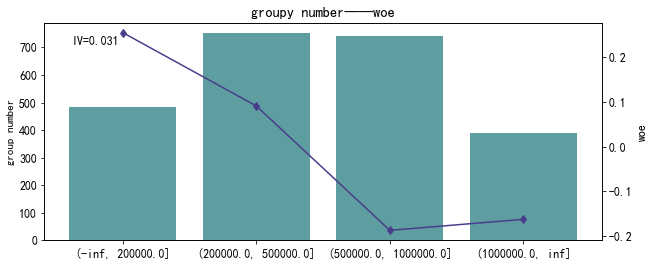

bad_count  good_count  n_group  bad_rate  \
loan_max_amount_last_9months_fillna                                             
(-inf, 200000.0]                           208         275      483  0.430642   
(200000.0, 500000.0]                       294         458      752  0.390957   
(500000.0, 1000000.0]                      242         498      740  0.327027   
(1000000.0, inf]                           129         259      388  0.332474   

                                          woe        iv  
loan_max_amount_last_9months_fillna                      
(-inf, 200000.0]                     0.255363  0.013712  
(200000.0, 500000.0]                 0.091306  0.002683  
(500000.0, 1000000.0]               -0.187067  0.010667  
(1000000.0, inf]                    -0.162420  0.004233

In [135]:
woe_function(df_train,df,'loan_max_amount_last_9months',q=[200000,500000,1000000],woe_type='c')

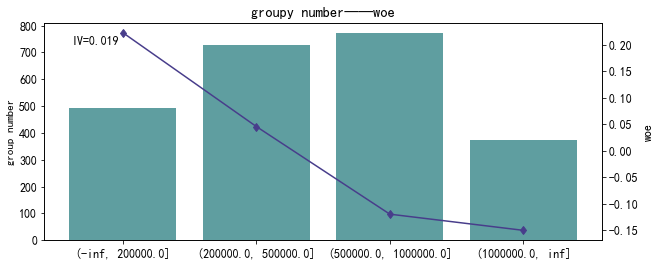

bad_count  good_count  n_group  \
loan_max_amount_last_12months_fillna                                   
(-inf, 200000.0]                            208         284      492   
(200000.0, 500000.0]                        276         450      726   
(500000.0, 1000000.0]                       264         508      772   
(1000000.0, inf]                            125         248      373   

                                      bad_rate       woe        iv  
loan_max_amount_last_12months_fillna                                
(-inf, 200000.0]                      0.422764  0.223160  0.010635  
(200000.0, 500000.0]                  0.380165  0.045749  0.000647  
(500000.0, 1000000.0]                 0.341969 -0.119937  0.004622  
(1000000.0, inf]                      0.335121 -0.150519  0.003501

In [136]:
woe_function(df_train,df,'loan_max_amount_last_12months',q=[200000,500000,1000000],woe_type='c')

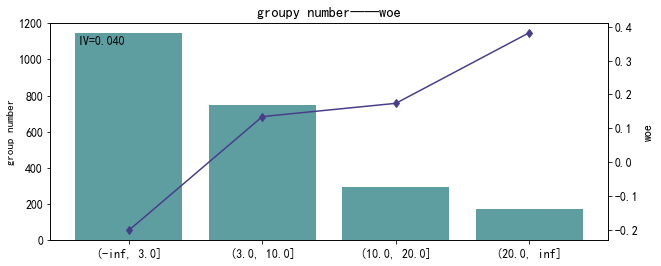

bad_count  good_count  n_group  bad_rate       woe  \
expire_times_fillna                                                       
(-inf, 3.0]                371         774     1145  0.324017 -0.200774   
(3.0, 10.0]                301         449      750  0.401333  0.134683   
(10.0, 20.0]               122         175      297  0.410774  0.173831   
(20.0, inf]                 79          92      171  0.461988  0.382255   

                           iv  
expire_times_fillna            
(-inf, 3.0]          0.018971  
(3.0, 10.0]          0.005851  
(10.0, 20.0]         0.003876  
(20.0, inf]          0.010989

In [142]:
woe_function(df_train,df,'expire_times',q=[3,10,20],woe_type='c')

In [1]:
woe_function(df_train,df,'expire_times_last_3months',q=[2,3,7],woe_type='c')

NameError: name 'woe_function' is not defined

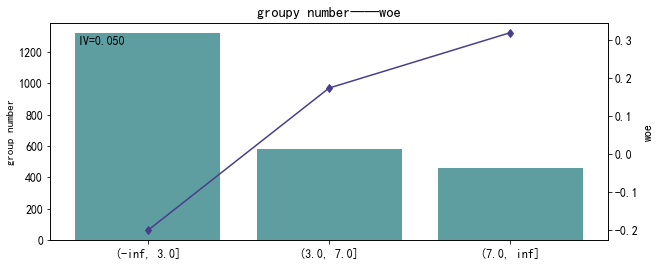

bad_count  good_count  n_group  bad_rate  \
expire_times_last_6months_fillna                                             
(-inf, 3.0]                             428         892     1320  0.324242   
(3.0, 7.0]                              240         344      584  0.410959   
(7.0, inf]                              205         254      459  0.446623   

                                       woe        iv  
expire_times_last_6months_fillna                      
(-inf, 3.0]                      -0.199747  0.021651  
(3.0, 7.0]                        0.174593  0.007689  
(7.0, inf]                        0.320272  0.020610

In [151]:
woe_function(df_train,df,'expire_times_last_6months',q=[3,7],woe_type='c')

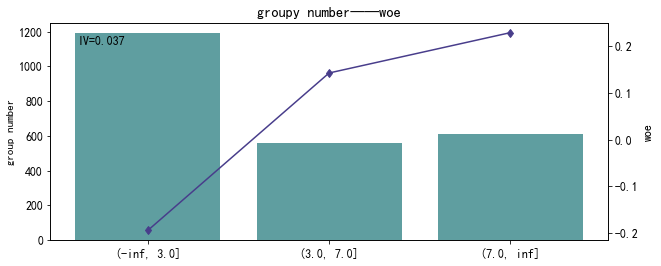

bad_count  good_count  n_group  bad_rate  \
expire_times_last_9months_fillna                                             
(-inf, 3.0]                             388         804     1192  0.325503   
(3.0, 7.0]                              225         333      558  0.403226   
(7.0, inf]                              260         353      613  0.424144   

                                       woe        iv  
expire_times_last_9months_fillna                      
(-inf, 3.0]                      -0.193998  0.018459  
(3.0, 7.0]                        0.142554  0.004881  
(7.0, inf]                        0.228809  0.013937

In [154]:
woe_function(df_train,df,'expire_times_last_9months',q=[3,7],woe_type='c')

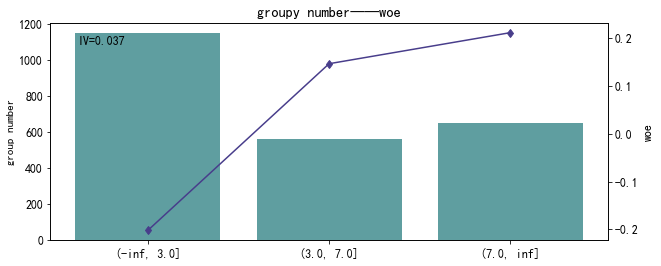

bad_count  good_count  n_group  bad_rate  \
expire_times_last_12months_fillna                                             
(-inf, 3.0]                              372         777     1149  0.323760   
(3.0, 7.0]                               228         336      564  0.404255   
(7.0, inf]                               273         377      650  0.420000   

                                        woe        iv  
expire_times_last_12months_fillna                      
(-inf, 3.0]                       -0.201951  0.019258  
(3.0, 7.0]                         0.146830  0.005237  
(7.0, inf]                         0.211822  0.012645

In [155]:
woe_function(df_train,df,'expire_times_last_12months',q=[3,7],woe_type='c')

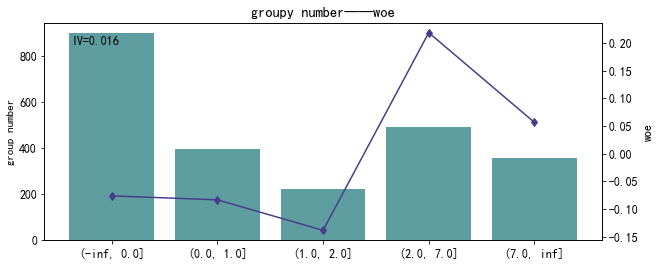

bad_count  good_count  n_group  bad_rate       woe  \
ontime_times_fillna                                                       
(-inf, 0.0]                316         582      898  0.351893 -0.076132   
(0.0, 1.0]                 138         256      394  0.350254 -0.083328   
(1.0, 2.0]                  75         147      222  0.337838 -0.138349   
(2.0, 7.0]                 207         284      491  0.421589  0.218340   
(7.0, inf]                 137         221      358  0.382682  0.056414   

                           iv  
ontime_times_fillna            
(-inf, 0.0]          0.002180  
(0.0, 1.0]           0.001145  
(1.0, 2.0]           0.001764  
(2.0, 7.0]           0.010155  
(7.0, inf]           0.000486

In [163]:
woe_function(df_train,df,'ontime_times',q=[0,1,2,7],woe_type='c')

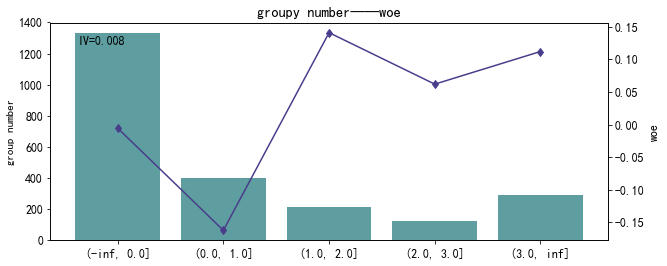

bad_count  good_count  n_group  bad_rate  \
ontime_times_last_3months_fillna                                             
(-inf, 0.0]                             490         841     1331  0.368144   
(0.0, 1.0]                              134         269      403  0.332506   
(1.0, 2.0]                               85         126      211  0.402844   
(2.0, 3.0]                               48          77      125  0.384000   
(3.0, inf]                              116         177      293  0.395904   

                                       woe        iv  
ontime_times_last_3months_fillna                      
(-inf, 0.0]                      -0.005590  0.000018  
(0.0, 1.0]                       -0.162276  0.004388  
(1.0, 2.0]                        0.140965  0.001805  
(2.0, 3.0]                        0.061991  0.000205  
(3.0, inf]                        0.112036  0.001578

In [166]:
woe_function(df_train,df,'ontime_times_last_3months',q=[0,1,2,3],woe_type='c')

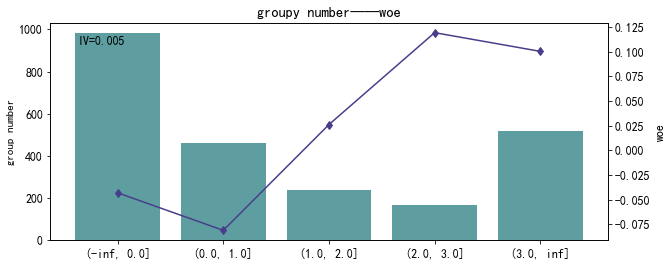

bad_count  good_count  n_group  bad_rate  \
ontime_times_last_6months_fillna                                             
(-inf, 0.0]                             353         629      982  0.359470   
(0.0, 1.0]                              161         298      459  0.350763   
(1.0, 2.0]                               89         148      237  0.375527   
(2.0, 3.0]                               66         100      166  0.397590   
(3.0, inf]                              204         315      519  0.393064   

                                       woe        iv  
ontime_times_last_6months_fillna                      
(-inf, 0.0]                      -0.043067  0.000766  
(0.0, 1.0]                       -0.081093  0.001263  
(1.0, 2.0]                        0.026020  0.000068  
(2.0, 3.0]                        0.119080  0.001011  
(3.0, inf]                        0.100143  0.002230

In [167]:
woe_function(df_train,df,'ontime_times_last_6months',q=[0,1,2,3],woe_type='c')

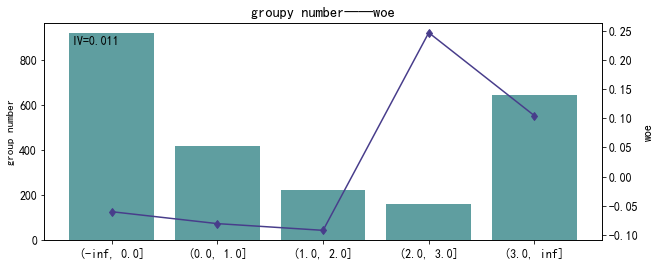

bad_count  good_count  n_group  bad_rate  \
ontime_times_last_9months_fillna                                             
(-inf, 0.0]                             326         591      917  0.355507   
(0.0, 1.0]                              147         272      419  0.350835   
(1.0, 2.0]                               78         146      224  0.348214   
(2.0, 3.0]                               69          92      161  0.428571   
(3.0, inf]                              253         389      642  0.394081   

                                       woe        iv  
ontime_times_last_9months_fillna                      
(-inf, 0.0]                      -0.060323  0.001401  
(0.0, 1.0]                       -0.080774  0.001144  
(1.0, 2.0]                       -0.092302  0.000797  
(2.0, 3.0]                        0.246914  0.004270  
(3.0, inf]                        0.104406  0.003000

In [168]:
woe_function(df_train,df,'ontime_times_last_9months',q=[0,1,2,3],woe_type='c')

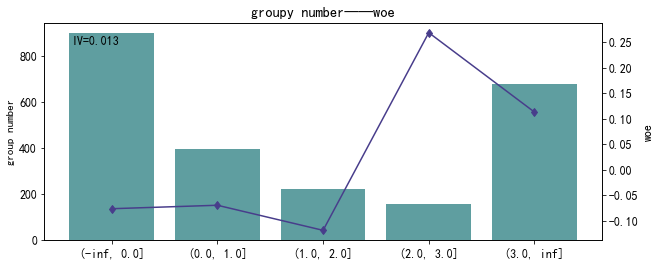

bad_count  good_count  n_group  bad_rate  \
ontime_times_last_12months_fillna                                             
(-inf, 0.0]                              317         584      901  0.351831   
(0.0, 1.0]                               141         258      399  0.353383   
(1.0, 2.0]                                77         148      225  0.342222   
(2.0, 3.0]                                69          90      159  0.433962   
(3.0, inf]                               269         410      679  0.396171   

                                        woe        iv  
ontime_times_last_12months_fillna                      
(-inf, 0.0]                       -0.076403  0.002203  
(0.0, 1.0]                        -0.069604  0.000810  
(1.0, 2.0]                        -0.118811  0.001322  
(2.0, 3.0]                         0.268893  0.005011  
(3.0, inf]                         0.113150  0.003730

In [169]:
woe_function(df_train,df,'ontime_times_last_12months',q=[0,1,2,3],woe_type='c')

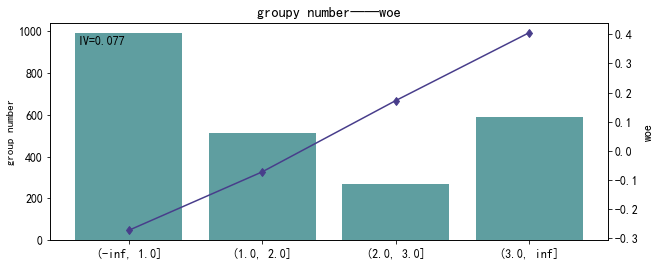

bad_count  good_count  n_group  bad_rate       woe  \
overdue_times_fillna                                                       
(-inf, 1.0]                 306         686      992  0.308468 -0.272697   
(1.0, 2.0]                  181         332      513  0.352827 -0.072042   
(2.0, 3.0]                  110         158      268  0.410448  0.172481   
(3.0, inf]                  276         314      590  0.467797  0.405604   

                            iv  
overdue_times_fillna            
(-inf, 1.0]           0.029966  
(1.0, 2.0]            0.001116  
(2.0, 3.0]            0.003443  
(3.0, inf]            0.042756

In [173]:
woe_function(df_train,df,'overdue_times',q=[1,2,3],woe_type='c')

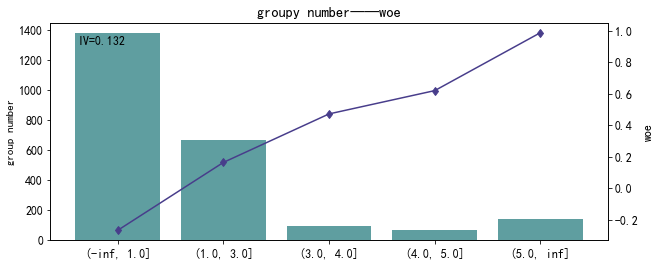

bad_count  good_count  n_group  bad_rate  \
overdue_times_last_3months_fillna                                             
(-inf, 1.0]                              428         954     1382  0.309696   
(1.0, 3.0]                               274         397      671  0.408346   
(3.0, 4.0]                                46          49       95  0.484211   
(4.0, 5.0]                                37          34       71  0.521127   
(5.0, inf]                                88          56      144  0.611111   

                                        woe        iv  
overdue_times_last_3months_fillna                      
(-inf, 1.0]                       -0.266945  0.040043  
(1.0, 3.0]                         0.163788  0.007766  
(3.0, 4.0]                         0.471417  0.009337  
(4.0, 5.0]                         0.619153  0.012113  
(5.0, inf]                         0.986581  0.062370

In [178]:
woe_function(df_train,df,'overdue_times_last_3months',q=[1,3,4,5],woe_type='c')

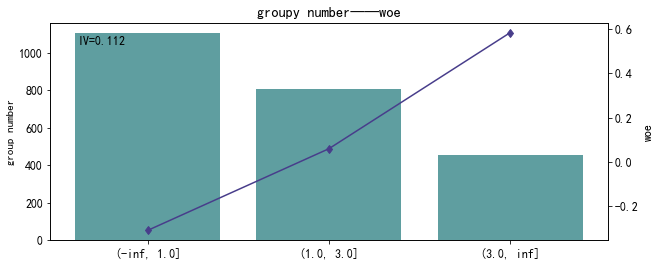

bad_count  good_count  n_group  bad_rate  \
overdue_times_last_6months_fillna                                             
(-inf, 1.0]                              332         772     1104  0.300725   
(1.0, 3.0]                               309         497      806  0.383375   
(3.0, inf]                               232         221      453  0.512141   

                                        woe        iv  
overdue_times_last_6months_fillna                      
(-inf, 1.0]                       -0.309254  0.042622  
(1.0, 3.0]                         0.059347  0.001210  
(3.0, inf]                         0.583171  0.068481

In [180]:
woe_function(df_train,df,'overdue_times_last_6months',q=[1,3],woe_type='c')

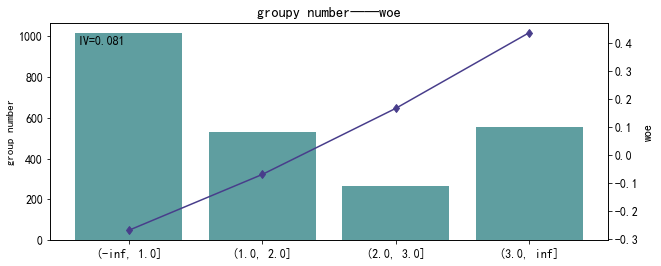

bad_count  good_count  n_group  bad_rate  \
overdue_times_last_9months_fillna                                             
(-inf, 1.0]                              314         701     1015  0.309360   
(1.0, 2.0]                               187         342      529  0.353497   
(2.0, 3.0]                               108         156      264  0.409091   
(3.0, inf]                               264         291      555  0.475676   

                                        woe        iv  
overdue_times_last_9months_fillna                      
(-inf, 1.0]                       -0.268519  0.029749  
(1.0, 2.0]                        -0.069106  0.001059  
(2.0, 3.0]                         0.166871  0.003173  
(3.0, inf]                         0.437222  0.046828

In [185]:
woe_function(df_train,df,'overdue_times_last_9months',q=[1,2,3],woe_type='c')

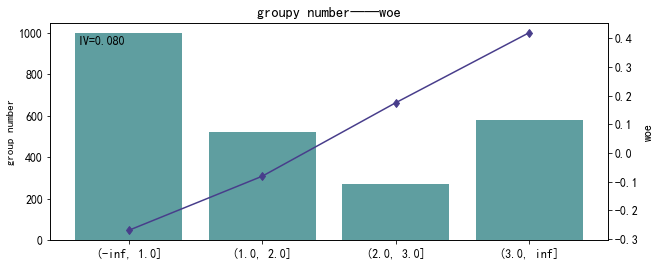

bad_count  good_count  n_group  bad_rate  \
overdue_times_last_12months_fillna                                             
(-inf, 1.0]                               308         689      997  0.308927   
(1.0, 2.0]                                182         337      519  0.350674   
(2.0, 3.0]                                111         159      270  0.411111   
(3.0, inf]                                272         305      577  0.471404   

                                         woe        iv  
overdue_times_last_12months_fillna                      
(-inf, 1.0]                        -0.270546  0.029654  
(1.0, 2.0]                         -0.081480  0.001442  
(2.0, 3.0]                          0.175222  0.003581  
(3.0, inf]                          0.420086  0.044895

In [186]:
woe_function(df_train,df,'overdue_times_last_12months',q=[1,2,3],woe_type='c')

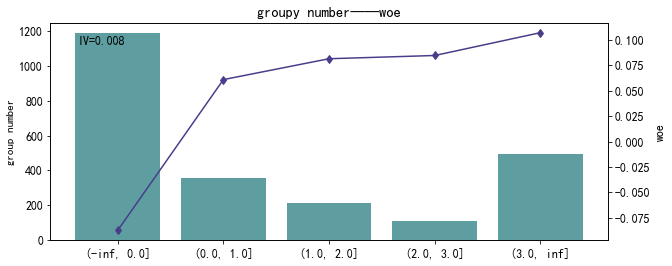

bad_count  good_count  n_group  bad_rate       woe  \
prepay_times_fillna                                                       
(-inf, 0.0]                415         773     1188  0.349327 -0.087405   
(0.0, 1.0]                 137         220      357  0.383754  0.060949   
(1.0, 2.0]                  82         129      211  0.388626  0.081503   
(2.0, 3.0]                  44          69      113  0.389381  0.084679   
(3.0, inf]                 195         299      494  0.394737  0.107152   

                           iv  
prepay_times_fillna            
(-inf, 0.0]          0.003795  
(0.0, 1.0]           0.000566  
(1.0, 2.0]           0.000599  
(2.0, 3.0]           0.000347  
(3.0, inf]           0.002432

In [190]:
woe_function(df_train,df,'prepay_times',q=[0,1,2,3],woe_type='c')

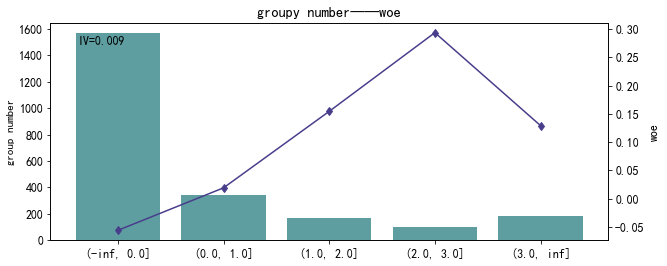

bad_count  good_count  n_group  bad_rate  \
prepay_times_last_3months_fillna                                             
(-inf, 0.0]                             559        1009     1568  0.356505   
(0.0, 1.0]                              129         216      345  0.373913   
(1.0, 2.0]                               67          98      165  0.406061   
(2.0, 3.0]                               44          56      100  0.440000   
(3.0, inf]                               74         111      185  0.400000   

                                       woe        iv  
prepay_times_last_3months_fillna                      
(-inf, 0.0]                      -0.055970  0.002063  
(0.0, 1.0]                        0.019130  0.000054  
(1.0, 2.0]                        0.154321  0.001694  
(2.0, 3.0]                        0.293434  0.003761  
(3.0, inf]                        0.129131  0.001326

In [191]:
woe_function(df_train,df,'prepay_times_last_3months',q=[0,1,2,3],woe_type='c')

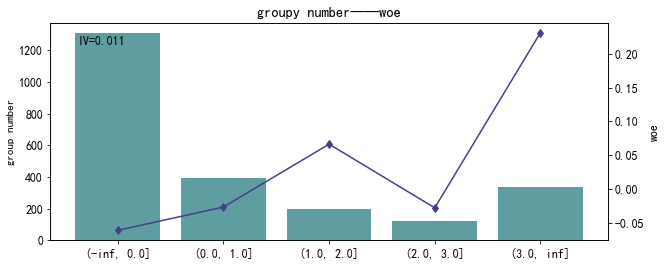

bad_count  good_count  n_group  bad_rate  \
prepay_times_last_6months_fillna                                             
(-inf, 0.0]                             465         844     1309  0.355233   
(0.0, 1.0]                              142         249      391  0.363171   
(1.0, 2.0]                               77         123      200  0.385000   
(2.0, 3.0]                               45          79      124  0.362903   
(3.0, inf]                              144         195      339  0.424779   

                                       woe        iv  
prepay_times_last_6months_fillna                      
(-inf, 0.0]                      -0.061519  0.002079  
(0.0, 1.0]                       -0.027030  0.000120  
(1.0, 2.0]                        0.066217  0.000374  
(2.0, 3.0]                       -0.028190  0.000042  
(3.0, inf]                        0.231410  0.007886

In [192]:
woe_function(df_train,df,'prepay_times_last_6months',q=[0,1,2,3],woe_type='c')

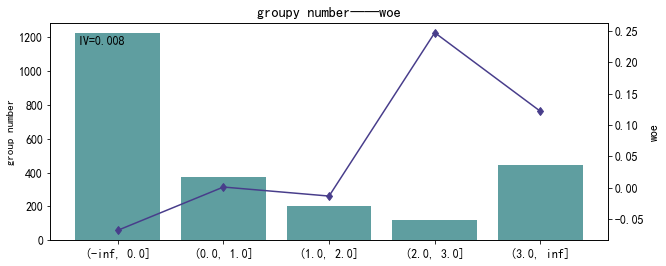

bad_count  good_count  n_group  bad_rate  \
prepay_times_last_9months_fillna                                             
(-inf, 0.0]                             433         791     1224  0.353758   
(0.0, 1.0]                              139         237      376  0.369681   
(1.0, 2.0]                               74         128      202  0.366337   
(2.0, 3.0]                               51          68      119  0.428571   
(3.0, inf]                              176         266      442  0.398190   

                                       woe            iv  
prepay_times_last_9months_fillna                          
(-inf, 0.0]                      -0.067964  2.370710e-03  
(0.0, 1.0]                        0.001010  1.622222e-07  
(1.0, 2.0]                       -0.013369  1.525257e-05  
(2.0, 3.0]                        0.246914  3.155968e-03  
(3.0, inf]                        0.121584  2.806169e-03

In [193]:
woe_function(df_train,df,'prepay_times_last_9months',q=[0,1,2,3],woe_type='c')

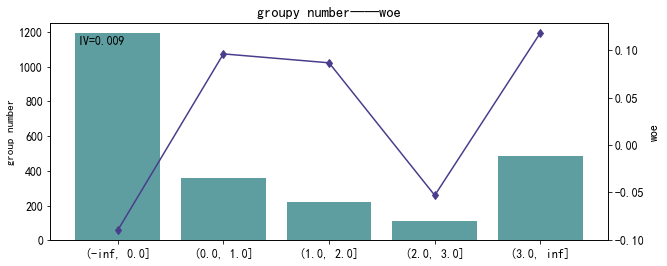

bad_count  good_count  n_group  bad_rate  \
prepay_times_last_12months_fillna                                             
(-inf, 0.0]                              416         777     1193  0.348701   
(0.0, 1.0]                               140         217      357  0.392157   
(1.0, 2.0]                                85         133      218  0.389908   
(2.0, 3.0]                                40          72      112  0.357143   
(3.0, inf]                               192         291      483  0.397516   

                                        woe        iv  
prepay_times_last_12months_fillna                      
(-inf, 0.0]                       -0.090159  0.004053  
(0.0, 1.0]                         0.096341  0.001419  
(1.0, 2.0]                         0.086898  0.000704  
(2.0, 3.0]                        -0.053191  0.000133  
(3.0, inf]                         0.118768  0.002925

In [194]:
woe_function(df_train,df,'prepay_times_last_12months',q=[0,1,2,3],woe_type='c')

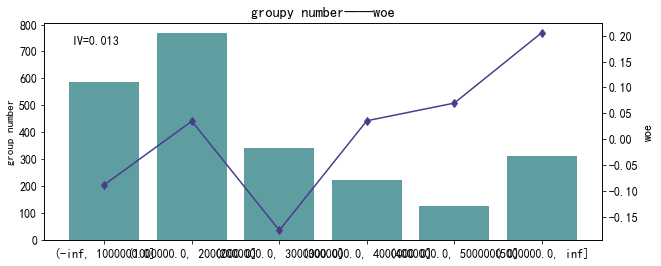

bad_count  good_count  n_group  bad_rate  \
expire_total_amount_fillna                                             
(-inf, 1000000.0]                 205         382      587  0.349233   
(1000000.0, 2000000.0]            290         478      768  0.377604   
(2000000.0, 3000000.0]            113         230      343  0.329446   
(3000000.0, 4000000.0]             85         140      225  0.377778   
(4000000.0, 5000000.0]             49          78      127  0.385827   
(5000000.0, inf]                  131         182      313  0.418530   

                                 woe        iv  
expire_total_amount_fillna                      
(-inf, 1000000.0]          -0.087815  0.001893  
(1000000.0, 2000000.0]      0.034866  0.000397  
(2000000.0, 3000000.0]     -0.176096  0.004389  
(3000000.0, 4000000.0]      0.035605  0.000121  
(4000000.0, 5000000.0]      0.069707  0.000263  
(5000000.0, inf]            0.205786  0.005743

In [195]:
woe_function(df_train,df,'expire_total_amount',q=[1000000,2000000,3000000,4000000,5000000],woe_type='c')

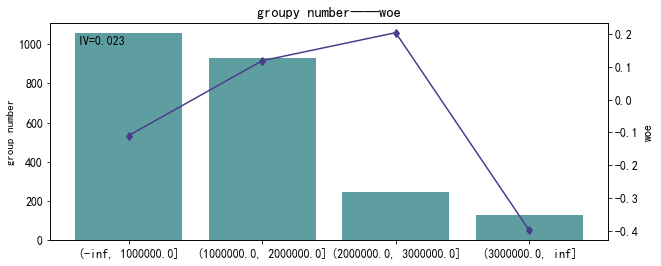

bad_count  good_count  n_group  \
expire_total_amount_last_3months_fillna                                   
(-inf, 1000000.0]                              364         693     1057   
(1000000.0, 2000000.0]                         370         561      931   
(2000000.0, 3000000.0]                         102         142      244   
(3000000.0, inf]                                37          94      131   

                                         bad_rate       woe        iv  
expire_total_amount_last_3months_fillna                                
(-inf, 1000000.0]                        0.344371 -0.109280  0.005262  
(1000000.0, 2000000.0]                   0.397422  0.118378  0.005601  
(2000000.0, 3000000.0]                   0.418033  0.203742  0.004388  
(3000000.0, inf]                         0.282443 -0.397781  0.008236

In [198]:
woe_function(df_train,df,'expire_total_amount_last_3months',q=[1000000,2000000,3000000],woe_type='c')

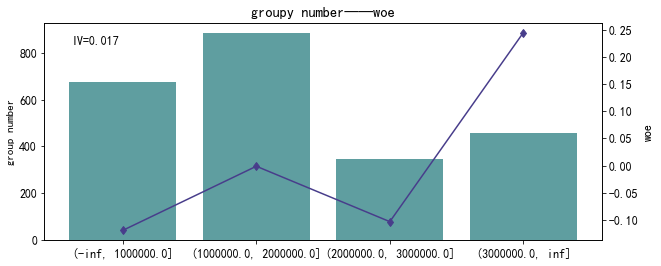

bad_count  good_count  n_group  \
expire_total_amount_last_6months_fillna                                   
(-inf, 1000000.0]                              231         444      675   
(1000000.0, 2000000.0]                         326         557      883   
(2000000.0, 3000000.0]                         120         227      347   
(3000000.0, inf]                               196         262      458   

                                         bad_rate       woe            iv  
expire_total_amount_last_6months_fillna                                    
(-inf, 1000000.0]                        0.342222 -0.118811  3.966121e-03  
(1000000.0, 2000000.0]                   0.369196 -0.001072  4.293765e-07  
(2000000.0, 3000000.0]                   0.345821 -0.102862  1.531822e-03  
(3000000.0, inf]                         0.427948  0.244366  1.189433e-02

In [199]:
woe_function(df_train,df,'expire_total_amount_last_6months',q=[1000000,2000000,3000000],woe_type='c')

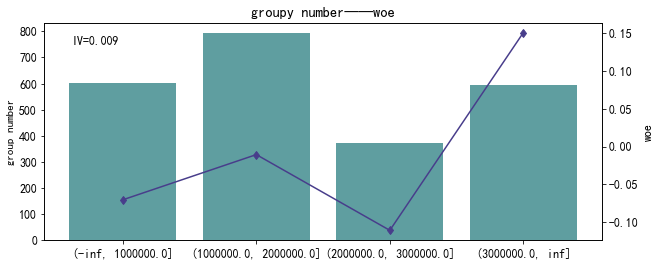

bad_count  good_count  n_group  \
expire_total_amount_last_9months_fillna                                   
(-inf, 1000000.0]                              213         390      603   
(1000000.0, 2000000.0]                         291         502      793   
(2000000.0, 3000000.0]                         128         244      372   
(3000000.0, inf]                               241         354      595   

                                         bad_rate       woe        iv  
expire_total_amount_last_9months_fillna                                
(-inf, 1000000.0]                        0.353234 -0.070259  0.001248  
(1000000.0, 2000000.0]                   0.366961 -0.010681  0.000038  
(2000000.0, 3000000.0]                   0.344086 -0.110542  0.001894  
(3000000.0, inf]                         0.405042  0.150096  0.005775

In [200]:
woe_function(df_train,df,'expire_total_amount_last_9months',q=[1000000,2000000,3000000],woe_type='c')

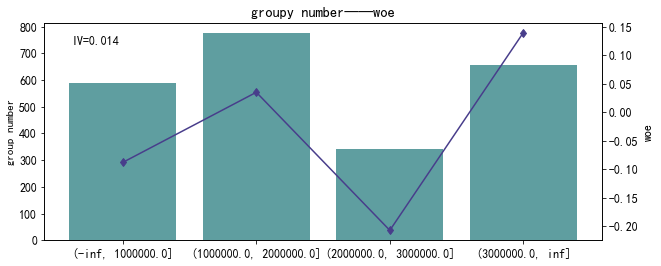

bad_count  good_count  n_group  \
expire_total_amount_last_12months_fillna                                   
(-inf, 1000000.0]                               206         384      590   
(1000000.0, 2000000.0]                          293         483      776   
(2000000.0, 3000000.0]                          110         231      341   
(3000000.0, inf]                                264         392      656   

                                          bad_rate       woe        iv  
expire_total_amount_last_12months_fillna                                
(-inf, 1000000.0]                         0.349153 -0.088171  0.001918  
(1000000.0, 2000000.0]                    0.377577  0.034752  0.000398  
(2000000.0, 3000000.0]                    0.322581 -0.207342  0.006019  
(3000000.0, inf]                          0.402439  0.139283  0.005476

In [201]:
woe_function(df_train,df,'expire_total_amount_last_12months',q=[1000000,2000000,3000000],woe_type='c')

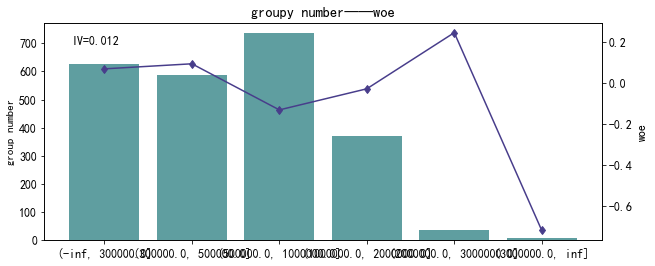

bad_count  good_count  n_group  bad_rate       woe  \
expire_max_amount_fillna                                                       
(-inf, 300000.0]                242         385      627  0.385965  0.070290   
(300000.0, 500000.0]            230         357      587  0.391823  0.094939   
(500000.0, 1000000.0]           250         486      736  0.339674 -0.130152   
(1000000.0, 2000000.0]          134         235      369  0.363144 -0.027150   
(2000000.0, 3000000.0]           15          20       35  0.428571  0.246914   
(3000000.0, inf]                  2           7        9  0.222222 -0.718167   

                                iv  
expire_max_amount_fillna            
(-inf, 300000.0]          0.001323  
(300000.0, 500000.0]      0.002265  
(500000.0, 1000000.0]     0.005181  
(1000000.0, 2000000.0]    0.000115  
(2000000.0, 3000000.0]    0.000928  
(3000000.0, inf]          0.001729

In [204]:
woe_function(df_train,df,'expire_max_amount',q=[300000,500000,1000000,2000000,3000000],woe_type='c')

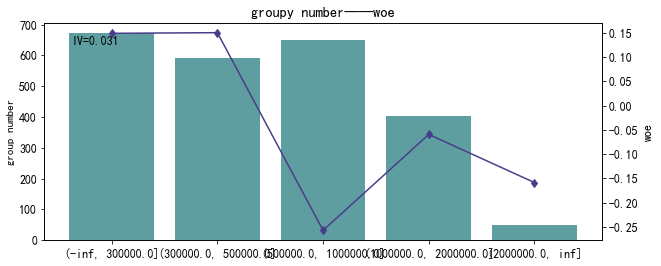

bad_count  good_count  n_group  \
expire_max_amount_last_3months_fillna                                   
(-inf, 300000.0]                             272         400      672   
(300000.0, 500000.0]                         239         351      590   
(500000.0, 1000000.0]                        203         448      651   
(1000000.0, 2000000.0]                       143         259      402   
(2000000.0, inf]                              16          32       48   

                                       bad_rate       woe        iv  
expire_max_amount_last_3months_fillna                                
(-inf, 300000.0]                       0.404762  0.148933  0.006421  
(300000.0, 500000.0]                   0.405085  0.150273  0.005740  
(500000.0, 1000000.0]                  0.311828 -0.256991  0.017511  
(1000000.0, 2000000.0]                 0.355721 -0.059388  0.000595  
(2000000.0, inf]                       0.333333 -0.158551  0.000499

In [206]:
woe_function(df_train,df,'expire_max_amount_last_3months',q=[300000,500000,1000000,2000000],woe_type='c')

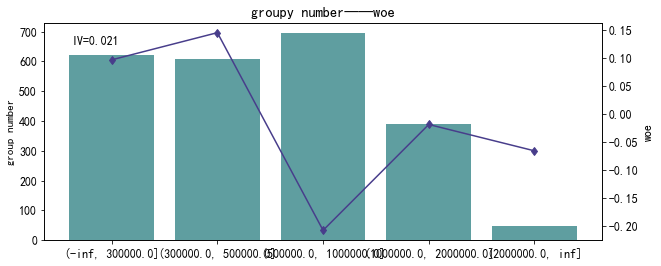

bad_count  good_count  n_group  \
expire_max_amount_last_6months_fillna                                   
(-inf, 300000.0]                             244         378      622   
(300000.0, 500000.0]                         246         363      609   
(500000.0, 1000000.0]                        224         471      695   
(1000000.0, 2000000.0]                       142         247      389   
(2000000.0, inf]                              17          31       48   

                                       bad_rate       woe        iv  
expire_max_amount_last_6months_fillna                                
(-inf, 300000.0]                       0.392283  0.096870  0.002500  
(300000.0, 500000.0]                   0.403941  0.145525  0.005554  
(500000.0, 1000000.0]                  0.322302 -0.208616  0.012417  
(1000000.0, 2000000.0]                 0.365039 -0.018965  0.000059  
(2000000.0, inf]                       0.354167 -0.066178  0.000088

In [207]:
woe_function(df_train,df,'expire_max_amount_last_6months',q=[300000,500000,1000000,2000000],woe_type='c')

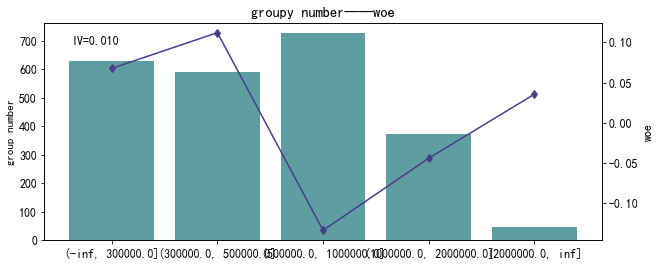

bad_count  good_count  n_group  \
expire_max_amount_last_9months_fillna                                   
(-inf, 300000.0]                             242         386      628   
(300000.0, 500000.0]                         234         357      591   
(500000.0, 1000000.0]                        246         480      726   
(1000000.0, 2000000.0]                       134         239      373   
(2000000.0, inf]                              17          28       45   

                                       bad_rate       woe        iv  
expire_max_amount_last_9months_fillna                                
(-inf, 300000.0]                       0.385350  0.067696  0.001228  
(300000.0, 500000.0]                   0.395939  0.112181  0.003191  
(500000.0, 1000000.0]                  0.338843 -0.133859  0.005403  
(1000000.0, 2000000.0]                 0.359249 -0.044028  0.000304  
(2000000.0, inf]                       0.377778  0.035605  0.000024

In [208]:
woe_function(df_train,df,'expire_max_amount_last_9months',q=[300000,500000,1000000,2000000],woe_type='c')

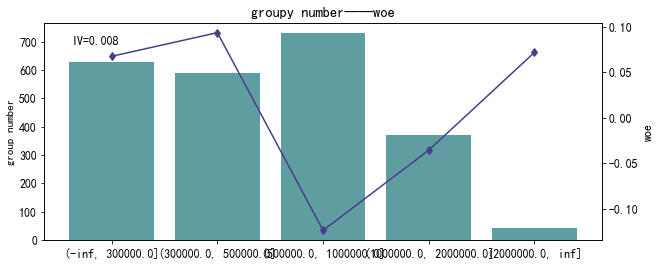

bad_count  good_count  n_group  \
expire_max_amount_last_12months_fillna                                   
(-inf, 300000.0]                              242         386      628   
(300000.0, 500000.0]                          231         359      590   
(500000.0, 1000000.0]                         249         481      730   
(1000000.0, 2000000.0]                        134         237      371   
(2000000.0, inf]                               17          27       44   

                                        bad_rate       woe        iv  
expire_max_amount_last_12months_fillna                                
(-inf, 300000.0]                        0.385350  0.067696  0.001228  
(300000.0, 500000.0]                    0.391525  0.093691  0.002217  
(500000.0, 1000000.0]                   0.341096 -0.123819  0.004655  
(1000000.0, 2000000.0]                  0.361186 -0.035624  0.000198  
(2000000.0, inf]                        0.386364  0.071972  0.000097

In [209]:
woe_function(df_train,df,'expire_max_amount_last_12months',q=[300000,500000,1000000,2000000],woe_type='c')

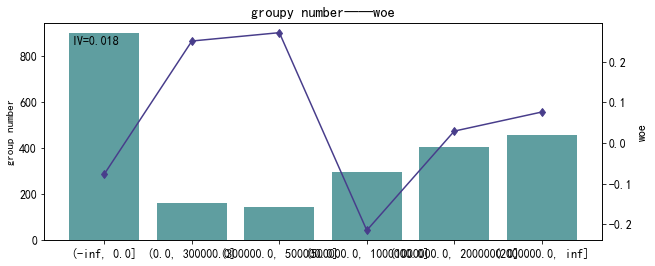

bad_count  good_count  n_group  bad_rate  \
ontime_total_amount_fillna                                             
(-inf, 0.0]                       316         582      898  0.351893   
(0.0, 300000.0]                    70          93      163  0.429448   
(300000.0, 500000.0]               63          82      145  0.434483   
(500000.0, 1000000.0]              95         201      296  0.320946   
(1000000.0, 2000000.0]            152         252      404  0.376238   
(2000000.0, inf]                  177         280      457  0.387309   

                                 woe        iv  
ontime_total_amount_fillna                      
(-inf, 0.0]                -0.076132  0.002180  
(0.0, 300000.0]             0.250492  0.004451  
(300000.0, 500000.0]        0.271011  0.004643  
(500000.0, 1000000.0]      -0.214832  0.005603  
(1000000.0, 2000000.0]      0.029047  0.000145  
(2000000.0, inf]            0.075956  0.001126

In [214]:
woe_function(df_train,df,'ontime_total_amount',q=[0,300000,500000,1000000,2000000],woe_type='c')

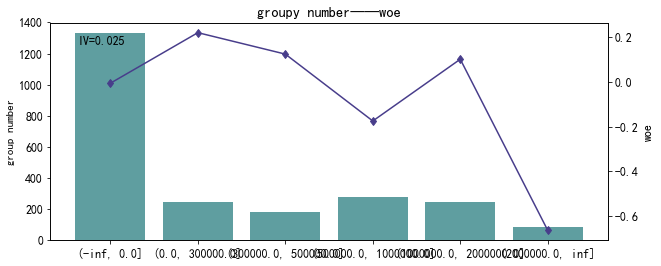

bad_count  good_count  n_group  \
ontime_total_amount_last_3months_fillna                                   
(-inf, 0.0]                                    490         841     1331   
(0.0, 300000.0]                                103         141      244   
(300000.0, 500000.0]                            73         110      183   
(500000.0, 1000000.0]                           92         187      279   
(1000000.0, 2000000.0]                          96         148      244   
(2000000.0, inf]                                19          63       82   

                                         bad_rate       woe        iv  
ontime_total_amount_last_3months_fillna                                
(-inf, 0.0]                              0.368144 -0.005590  0.000018  
(0.0, 300000.0]                          0.422131  0.220565  0.005151  
(300000.0, 500000.0]                     0.398907  0.124575  0.001220  
(500000.0, 1000000.0]                    0.329749 -0.174724  0.003515  
(1000000.0, 2000000.0]                   0.393443  0.101732  0.001082  
(2000000.0, inf]                         0.231707 -0.664100  0.013626

In [215]:
woe_function(df_train,df,'ontime_total_amount_last_3months',q=[0,300000,500000,1000000,2000000],woe_type='c')

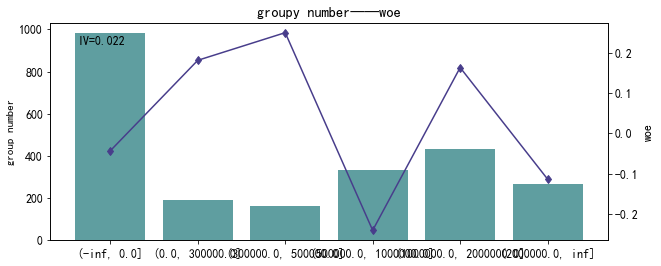

bad_count  good_count  n_group  \
ontime_total_amount_last_6months_fillna                                   
(-inf, 0.0]                                    353         629      982   
(0.0, 300000.0]                                 78         111      189   
(300000.0, 500000.0]                            70          93      163   
(500000.0, 1000000.0]                          105         228      333   
(1000000.0, 2000000.0]                         176         255      431   
(2000000.0, inf]                                91         174      265   

                                         bad_rate       woe        iv  
ontime_total_amount_last_6months_fillna                                
(-inf, 0.0]                              0.359470 -0.043067  0.000766  
(0.0, 300000.0]                          0.412698  0.181774  0.002699  
(300000.0, 500000.0]                     0.429448  0.250492  0.004451  
(500000.0, 1000000.0]                    0.315315 -0.240789  0.007885  
(1000000.0, 2000000.0]                   0.408353  0.163816  0.004990  
(2000000.0, inf]                         0.343396 -0.113600  0.001425

In [216]:
woe_function(df_train,df,'ontime_total_amount_last_6months',q=[0,300000,500000,1000000,2000000],woe_type='c')

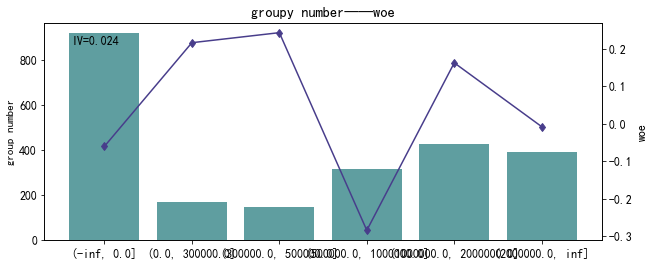

bad_count  good_count  n_group  \
ontime_total_amount_last_9months_fillna                                   
(-inf, 0.0]                                    326         591      917   
(0.0, 300000.0]                                 72          99      171   
(300000.0, 500000.0]                            62          83      145   
(500000.0, 1000000.0]                           97         220      317   
(1000000.0, 2000000.0]                         173         251      424   
(2000000.0, inf]                               143         246      389   

                                         bad_rate       woe        iv  
ontime_total_amount_last_9months_fillna                                
(-inf, 0.0]                              0.355507 -0.060323  0.001401  
(0.0, 300000.0]                          0.421053  0.216142  0.003465  
(300000.0, 500000.0]                     0.427586  0.242890  0.003720  
(500000.0, 1000000.0]                    0.305994 -0.284321  0.010389  
(1000000.0, 2000000.0]                   0.408019  0.162434  0.004826  
(2000000.0, inf]                         0.367609 -0.007891  0.000010

In [217]:
woe_function(df_train,df,'ontime_total_amount_last_9months',q=[0,300000,500000,1000000,2000000],woe_type='c')

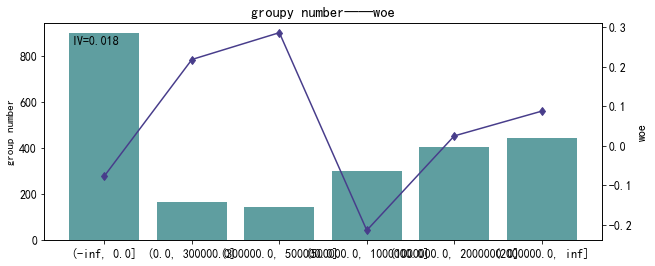

bad_count  good_count  n_group  \
ontime_total_amount_last_12months_fillna                                   
(-inf, 0.0]                                     317         584      901   
(0.0, 300000.0]                                  70          96      166   
(300000.0, 500000.0]                             64          82      146   
(500000.0, 1000000.0]                            96         203      299   
(1000000.0, 2000000.0]                          152         253      405   
(2000000.0, inf]                                174         272      446   

                                          bad_rate       woe        iv  
ontime_total_amount_last_12months_fillna                                
(-inf, 0.0]                               0.351831 -0.076403  0.002203  
(0.0, 300000.0]                           0.421687  0.218743  0.003446  
(300000.0, 500000.0]                      0.438356  0.286760  0.005241  
(500000.0, 1000000.0]                     0.321070 -0.214262  0.005630  
(1000000.0, 2000000.0]                    0.375309  0.025087  0.000108  
(2000000.0, inf]                          0.390135  0.087849  0.001473

In [218]:
woe_function(df_train,df,'ontime_total_amount_last_12months',q=[0,300000,500000,1000000,2000000],woe_type='c')

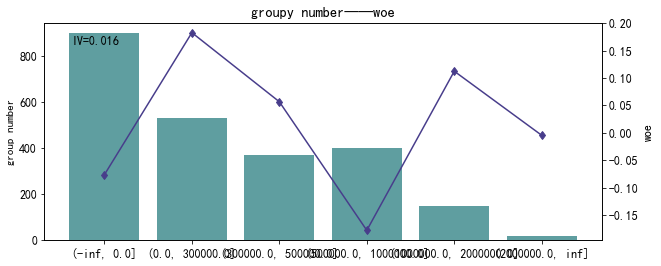

bad_count  good_count  n_group  bad_rate       woe  \
ontime_max_amount_fillna                                                       
(-inf, 0.0]                     316         582      898  0.351893 -0.076132   
(0.0, 300000.0]                 218         310      528  0.412879  0.182519   
(300000.0, 500000.0]            142         229      371  0.382749  0.056701   
(500000.0, 1000000.0]           131         267      398  0.329146 -0.177455   
(1000000.0, 2000000.0]           59          90      149  0.395973  0.112324   
(2000000.0, inf]                  7          12       19  0.368421 -0.004401   

                                    iv  
ontime_max_amount_fillna                
(-inf, 0.0]               2.179960e-03  
(0.0, 300000.0]           7.603714e-03  
(300000.0, 500000.0]      5.083932e-04  
(500000.0, 1000000.0]     5.170584e-03  
(1000000.0, 2000000.0]    8.065243e-04  
(2000000.0, inf]          1.556234e-07

In [219]:
woe_function(df_train,df,'ontime_max_amount',q=[0,300000,500000,1000000,2000000],woe_type='c')

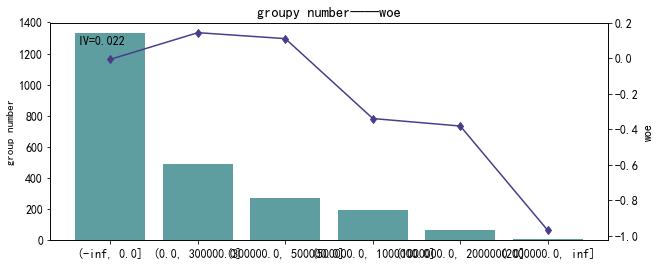

bad_count  good_count  n_group  \
ontime_max_amount_last_3months_fillna                                   
(-inf, 0.0]                                  490         841     1331   
(0.0, 300000.0]                              197         291      488   
(300000.0, 500000.0]                         108         165      273   
(500000.0, 1000000.0]                         58         139      197   
(1000000.0, 2000000.0]                        18          45       63   
(2000000.0, inf]                               2           9       11   

                                       bad_rate       woe        iv  
ontime_max_amount_last_3months_fillna                                
(-inf, 0.0]                            0.368144 -0.005590  0.000018  
(0.0, 300000.0]                        0.403689  0.144476  0.004386  
(300000.0, 500000.0]                   0.395604  0.110782  0.001437  
(500000.0, 1000000.0]                  0.294416 -0.339435  0.009114  
(1000000.0, 2000000.0]                 0.285714 -0.381695  0.003658  
(2000000.0, inf]                       0.181818 -0.969482  0.003635

In [221]:
woe_function(df_train,df,'ontime_max_amount_last_3months',q=[0,300000,500000,1000000,2000000],woe_type='c')

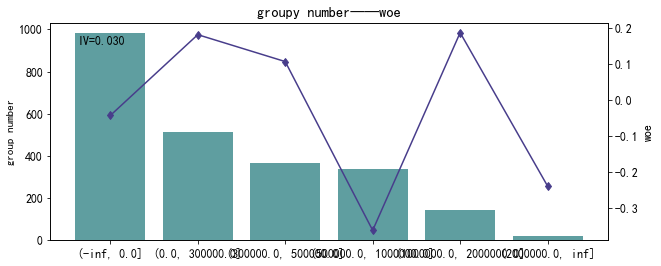

bad_count  good_count  n_group  \
ontime_max_amount_last_6months_fillna                                   
(-inf, 0.0]                                  353         629      982   
(0.0, 300000.0]                              212         302      514   
(300000.0, 500000.0]                         144         221      365   
(500000.0, 1000000.0]                         98         240      338   
(1000000.0, 2000000.0]                        60          85      145   
(2000000.0, inf]                               6          13       19   

                                       bad_rate       woe        iv  
ontime_max_amount_last_6months_fillna                                
(-inf, 0.0]                            0.359470 -0.043067  0.000766  
(0.0, 300000.0]                        0.412451  0.180755  0.007258  
(300000.0, 500000.0]                   0.394521  0.106246  0.001766  
(500000.0, 1000000.0]                  0.289941 -0.361076  0.017627  
(1000000.0, 2000000.0]                 0.413793  0.186289  0.002176  
(2000000.0, inf]                       0.315789 -0.238594  0.000442

In [222]:
woe_function(df_train,df,'ontime_max_amount_last_6months',q=[0,300000,500000,1000000,2000000],woe_type='c')

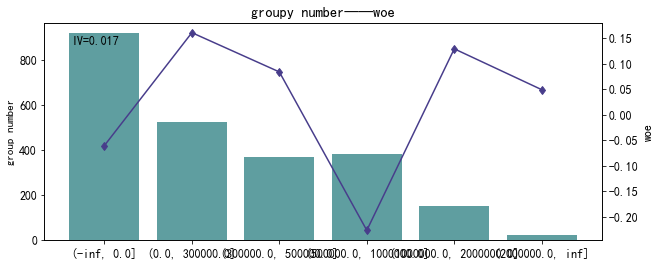

bad_count  good_count  n_group  \
ontime_max_amount_last_9months_fillna                                   
(-inf, 0.0]                                  326         591      917   
(0.0, 300000.0]                              214         311      525   
(300000.0, 500000.0]                         144         226      370   
(500000.0, 1000000.0]                        121         259      380   
(1000000.0, 2000000.0]                        60          90      150   
(2000000.0, inf]                               8          13       21   

                                       bad_rate       woe        iv  
ontime_max_amount_last_9months_fillna                                
(-inf, 0.0]                            0.355507 -0.060323  0.001401  
(0.0, 300000.0]                        0.407619  0.160779  0.005853  
(300000.0, 500000.0]                   0.389189  0.083874  0.001113  
(500000.0, 1000000.0]                  0.318421 -0.226442  0.007976  
(1000000.0, 2000000.0]                 0.400000  0.129131  0.001075  
(2000000.0, inf]                       0.380952  0.049088  0.000022

In [223]:
woe_function(df_train,df,'ontime_max_amount_last_9months',q=[0,300000,500000,1000000,2000000],woe_type='c')

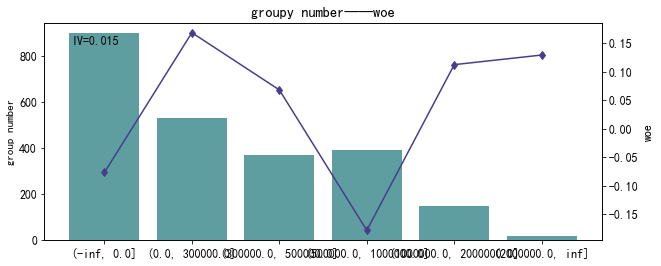

bad_count  good_count  n_group  \
ontime_max_amount_last_12months_fillna                                   
(-inf, 0.0]                                   317         584      901   
(0.0, 300000.0]                               217         313      530   
(300000.0, 500000.0]                          143         228      371   
(500000.0, 1000000.0]                         129         263      392   
(1000000.0, 2000000.0]                         59          90      149   
(2000000.0, inf]                                8          12       20   

                                        bad_rate       woe        iv  
ontime_max_amount_last_12months_fillna                                
(-inf, 0.0]                             0.351831 -0.076403  0.002203  
(0.0, 300000.0]                         0.409434  0.168290  0.006479  
(300000.0, 500000.0]                    0.385445  0.068095  0.000734  
(500000.0, 1000000.0]                   0.329082 -0.177746  0.005109  
(1000000.0, 2000000.0]                  0.395973  0.112324  0.000807  
(2000000.0, inf]                        0.400000  0.129131  0.000143

In [224]:
woe_function(df_train,df,'ontime_max_amount_last_12months',q=[0,300000,500000,1000000,2000000],woe_type='c')

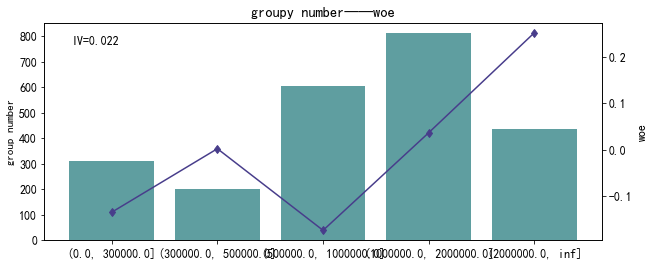

bad_count  good_count  n_group  bad_rate  \
overdue_total_amount_fillna                                             
(0.0, 300000.0]                    105         205      310  0.338710   
(300000.0, 500000.0]                74         126      200  0.370000   
(500000.0, 1000000.0]              200         406      606  0.330033   
(1000000.0, 2000000.0]             307         505      812  0.378079   
(2000000.0, inf]                   187         248      435  0.429885   

                                  woe            iv  
overdue_total_amount_fillna                          
(0.0, 300000.0]             -0.134454  2.327258e-03  
(300000.0, 500000.0]         0.002379  4.791821e-07  
(500000.0, 1000000.0]       -0.173440  7.525238e-03  
(1000000.0, 2000000.0]       0.036885  4.697239e-04  
(2000000.0, inf]             0.252276  1.204893e-02

In [225]:
woe_function(df_train,df,'overdue_total_amount',q=[0,300000,500000,1000000,2000000],woe_type='c')

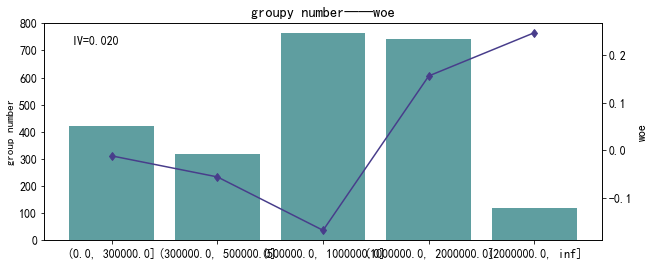

bad_count  good_count  n_group  \
overdue_total_amount_last_3months_fillna                                   
(0.0, 300000.0]                                 154         266      420   
(300000.0, 500000.0]                            113         204      317   
(500000.0, 1000000.0]                           253         511      764   
(1000000.0, 2000000.0]                          302         441      743   
(2000000.0, inf]                                 51          68      119   

                                          bad_rate       woe        iv  
overdue_total_amount_last_3months_fillna                                
(0.0, 300000.0]                           0.366667 -0.011948  0.000025  
(300000.0, 500000.0]                      0.356467 -0.056136  0.000420  
(500000.0, 1000000.0]                     0.331152 -0.168384  0.008949  
(1000000.0, 2000000.0]                    0.406460  0.155978  0.007793  
(2000000.0, inf]                          0.428571  0.246914  0.003156

In [229]:
woe_function(df_train,df,'overdue_total_amount_last_3months',q=[0,300000,500000,1000000,2000000],woe_type='c')

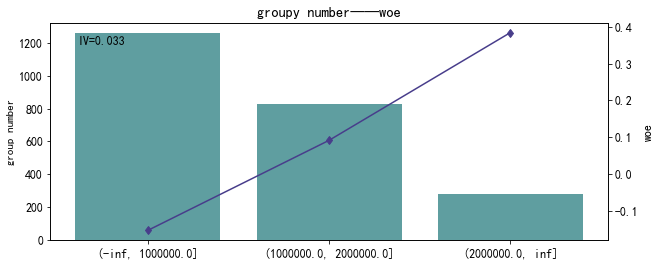

bad_count  good_count  n_group  \
overdue_total_amount_last_6months_fillna                                   
(-inf, 1000000.0]                               421         837     1258   
(1000000.0, 2000000.0]                          323         503      826   
(2000000.0, inf]                                129         150      279   

                                          bad_rate       woe        iv  
overdue_total_amount_last_6months_fillna                                
(-inf, 1000000.0]                         0.334658 -0.152595  0.012131  
(1000000.0, 2000000.0]                    0.391041  0.091658  0.002970  
(2000000.0, inf]                          0.462366  0.383773  0.018074

In [231]:
woe_function(df_train,df,'overdue_total_amount_last_6months',q=[1000000,2000000],woe_type='c')

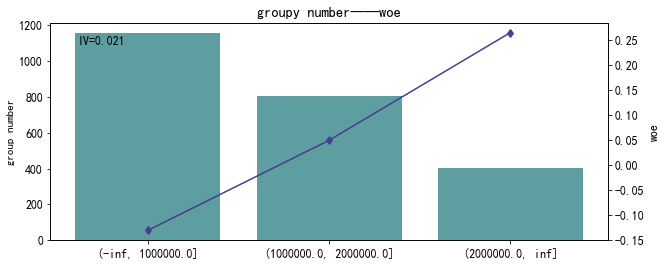

bad_count  good_count  n_group  \
overdue_total_amount_last_9months_fillna                                   
(-inf, 1000000.0]                               392         763     1155   
(1000000.0, 2000000.0]                          307         499      806   
(2000000.0, inf]                                174         228      402   

                                          bad_rate       woe        iv  
overdue_total_amount_last_9months_fillna                                
(-inf, 1000000.0]                         0.339394 -0.131400  0.008285  
(1000000.0, 2000000.0]                    0.380893  0.048837  0.000819  
(2000000.0, inf]                          0.432836  0.264306  0.012235

In [232]:
woe_function(df_train,df,'overdue_total_amount_last_9months',q=[1000000,2000000],woe_type='c')

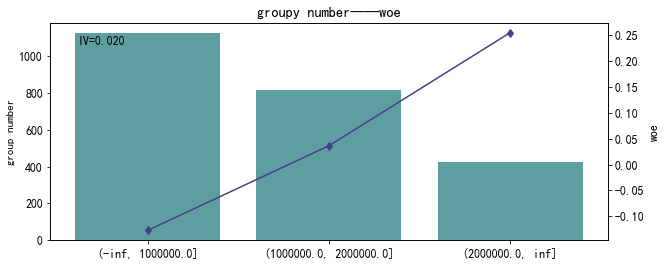

bad_count  good_count  n_group  \
overdue_total_amount_last_12months_fillna                                   
(-inf, 1000000.0]                                383         742     1125   
(1000000.0, 2000000.0]                           308         507      815   
(2000000.0, inf]                                 182         241      423   

                                           bad_rate       woe        iv  
overdue_total_amount_last_12months_fillna                                
(-inf, 1000000.0]                          0.340444 -0.126718  0.007511  
(1000000.0, 2000000.0]                     0.377914  0.036185  0.000454  
(2000000.0, inf]                           0.430260  0.253806  0.011861

In [233]:
woe_function(df_train,df,'overdue_total_amount_last_12months',q=[1000000,2000000],woe_type='c')

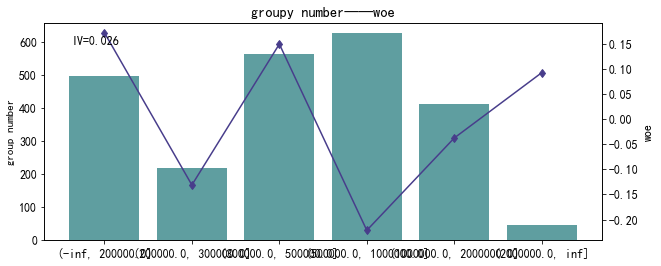

bad_count  good_count  n_group  bad_rate       woe  \
overdue_max_amount_fillna                                                       
(-inf, 200000.0]                 204         293      497  0.410463  0.172543   
(200000.0, 300000.0]              74         144      218  0.339450 -0.131152   
(300000.0, 500000.0]             228         335      563  0.404973  0.149811   
(500000.0, 1000000.0]            200         426      626  0.319489 -0.221526   
(1000000.0, 2000000.0]           149         264      413  0.360775 -0.037407   
(2000000.0, inf]                  18          28       46  0.391304  0.092763   

                                 iv  
overdue_max_amount_fillna            
(-inf, 200000.0]           0.006390  
(200000.0, 300000.0]       0.001558  
(300000.0, 500000.0]       0.005444  
(500000.0, 1000000.0]      0.012585  
(1000000.0, 2000000.0]     0.000243  
(2000000.0, inf]           0.000169

In [235]:
woe_function(df_train,df,'overdue_max_amount',q=[200000,300000,500000,1000000,2000000],woe_type='c')

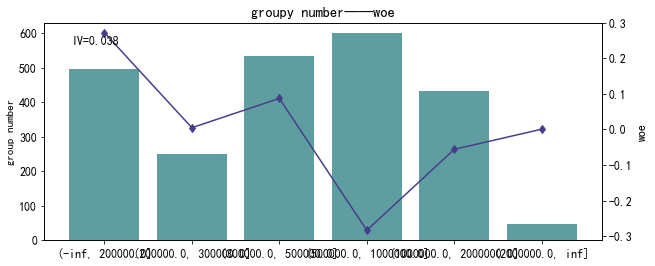

bad_count  good_count  n_group  \
overdue_max_amount_last_3months_fillna                                   
(-inf, 200000.0]                              216         281      497   
(200000.0, 300000.0]                           93         158      251   
(300000.0, 500000.0]                          209         327      536   
(500000.0, 1000000.0]                         184         417      601   
(1000000.0, 2000000.0]                        154         278      432   
(2000000.0, inf]                               17          29       46   

                                        bad_rate       woe            iv  
overdue_max_amount_last_3months_fillna                                    
(-inf, 200000.0]                        0.434608  0.271520  1.597406e-02  
(200000.0, 300000.0]                    0.370518  0.004600  2.249278e-06  
(300000.0, 500000.0]                    0.389925  0.086970  1.734290e-03  
(500000.0, 1000000.0]                   0.306156 -0.283555  1.959314e-02  
(1000000.0, 2000000.0]                  0.356481 -0.056073  5.704819e-04  
(2000000.0, inf]                        0.369565  0.000513  5.130533e-09

In [236]:
woe_function(df_train,df,'overdue_max_amount_last_3months',q=[200000,300000,500000,1000000,2000000],woe_type='c')

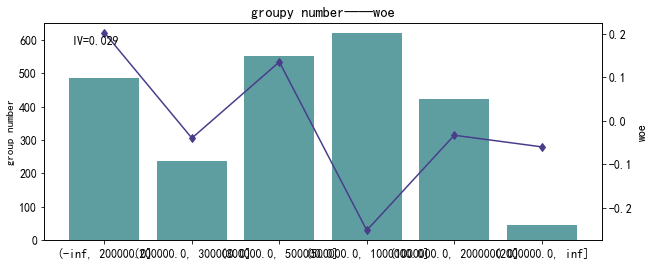

bad_count  good_count  n_group  \
overdue_max_amount_last_6months_fillna                                   
(-inf, 200000.0]                              203         283      486   
(200000.0, 300000.0]                           85         151      236   
(300000.0, 500000.0]                          222         331      553   
(500000.0, 1000000.0]                         194         426      620   
(1000000.0, 2000000.0]                        153         270      423   
(2000000.0, inf]                               16          29       45   

                                        bad_rate       woe        iv  
overdue_max_amount_last_6months_fillna                                
(-inf, 200000.0]                        0.417695  0.202355  0.008620  
(200000.0, 300000.0]                    0.360169 -0.040033  0.000159  
(300000.0, 500000.0]                    0.401447  0.135155  0.004345  
(500000.0, 1000000.0]                   0.312903 -0.251985  0.016047  
(1000000.0, 2000000.0]                  0.361702 -0.033388  0.000199  
(2000000.0, inf]                        0.355556 -0.060111  0.000068

In [237]:
woe_function(df_train,df,'overdue_max_amount_last_6months',q=[200000,300000,500000,1000000,2000000],woe_type='c')

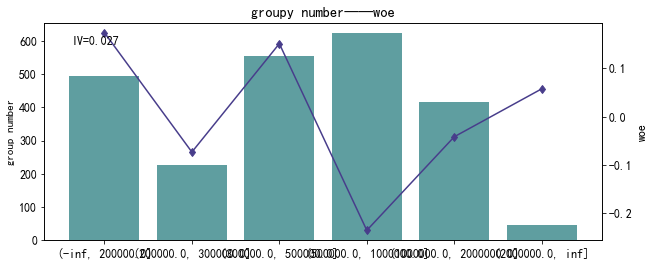

bad_count  good_count  n_group  \
overdue_max_amount_last_9months_fillna                                   
(-inf, 200000.0]                              203         291      494   
(200000.0, 300000.0]                           80         147      227   
(300000.0, 500000.0]                          225         330      555   
(500000.0, 1000000.0]                         197         426      623   
(1000000.0, 2000000.0]                        150         267      417   
(2000000.0, inf]                               18          29       47   

                                        bad_rate       woe        iv  
overdue_max_amount_last_9months_fillna                                
(-inf, 200000.0]                        0.410931  0.174479  0.006496  
(200000.0, 300000.0]                    0.352423 -0.073810  0.000518  
(300000.0, 500000.0]                    0.405405  0.151604  0.005496  
(500000.0, 1000000.0]                   0.316212 -0.236640  0.014257  
(1000000.0, 2000000.0]                  0.359712 -0.042018  0.000310  
(2000000.0, inf]                        0.382979  0.057672  0.000067

In [238]:
woe_function(df_train,df,'overdue_max_amount_last_9months',q=[200000,300000,500000,1000000,2000000],woe_type='c')

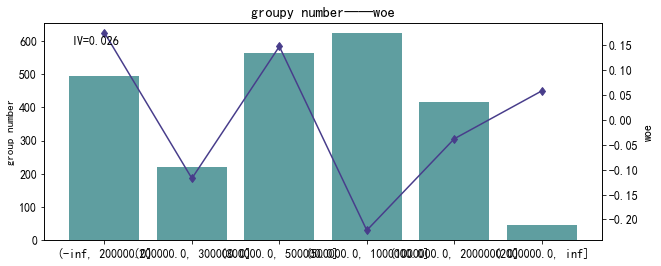

bad_count  good_count  n_group  \
overdue_max_amount_last_12months_fillna                                   
(-inf, 200000.0]                               203         291      494   
(200000.0, 300000.0]                            75         144      219   
(300000.0, 500000.0]                           228         336      564   
(500000.0, 1000000.0]                          199         424      623   
(1000000.0, 2000000.0]                         150         266      416   
(2000000.0, inf]                                18          29       47   

                                         bad_rate       woe        iv  
overdue_max_amount_last_12months_fillna                                
(-inf, 200000.0]                         0.410931  0.174479  0.006496  
(200000.0, 300000.0]                     0.342466 -0.117729  0.001264  
(300000.0, 500000.0]                     0.404255  0.146830  0.005237  
(500000.0, 1000000.0]                    0.319422 -0.221833  0.012559  
(1000000.0, 2000000.0]                   0.360577 -0.038265  0.000256  
(2000000.0, inf]                         0.382979  0.057672  0.000067

In [239]:
woe_function(df_train,df,'overdue_max_amount_last_12months',q=[200000,300000,500000,1000000,2000000],woe_type='c')

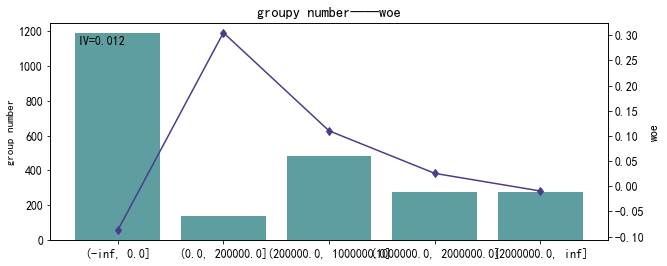

bad_count  good_count  n_group  bad_rate  \
prepay_total_amount_fillna                                             
(-inf, 0.0]                       415         773     1188  0.349327   
(0.0, 200000.0]                    62          78      140  0.442857   
(200000.0, 1000000.0]             191         292      483  0.395445   
(1000000.0, 2000000.0]            104         173      277  0.375451   
(2000000.0, inf]                  101         174      275  0.367273   

                                 woe        iv  
prepay_total_amount_fillna                      
(-inf, 0.0]                -0.087405  0.003795  
(0.0, 200000.0]             0.305021  0.005695  
(200000.0, 1000000.0]       0.110115  0.002512  
(1000000.0, 2000000.0]      0.025695  0.000078  
(2000000.0, inf]           -0.009339  0.000010

In [242]:
woe_function(df_train,df,'prepay_total_amount',q=[0,200000,1000000,2000000],woe_type='c')

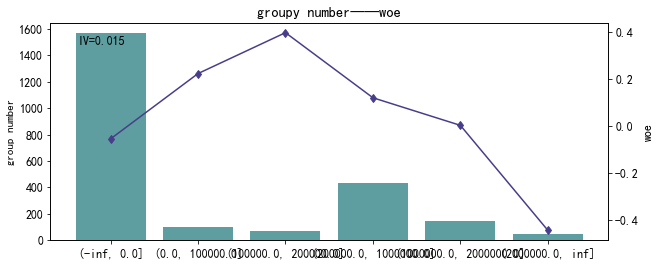

bad_count  good_count  n_group  \
prepay_total_amount_last_3months_fillna                                   
(-inf, 0.0]                                    559        1009     1568   
(0.0, 100000.0]                                 41          56       97   
(100000.0, 200000.0]                            34          39       73   
(200000.0, 1000000.0]                          173         262      435   
(1000000.0, 2000000.0]                          54          92      146   
(2000000.0, inf]                                12          32       44   

                                         bad_rate       woe            iv  
prepay_total_amount_last_3months_fillna                                    
(-inf, 0.0]                              0.356505 -0.055970  2.063070e-03  
(0.0, 100000.0]                          0.422680  0.222816  2.090149e-03  
(100000.0, 200000.0]                     0.465753  0.397395  5.075393e-03  
(200000.0, 1000000.0]                    0.397701  0.119543  2.669192e-03  
(1000000.0, 2000000.0]                   0.369863  0.001791  1.983049e-07  
(2000000.0, inf]                         0.272727 -0.446233  3.449744e-03

In [244]:
woe_function(df_train,df,'prepay_total_amount_last_3months',q=[0,100000,200000,1000000,2000000],woe_type='c')

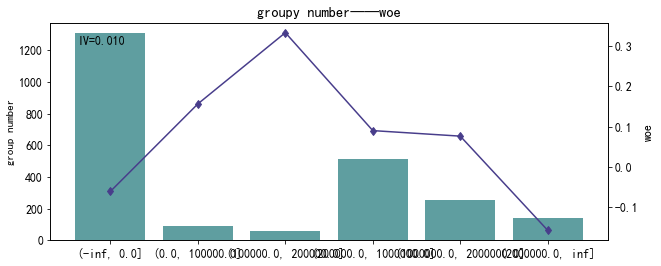

bad_count  good_count  n_group  \
prepay_total_amount_last_6months_fillna                                   
(-inf, 0.0]                                    465         844     1309   
(0.0, 100000.0]                                 37          54       91   
(100000.0, 200000.0]                            27          33       60   
(200000.0, 1000000.0]                          200         312      512   
(1000000.0, 2000000.0]                          98         155      253   
(2000000.0, inf]                                46          92      138   

                                         bad_rate       woe        iv  
prepay_total_amount_last_6months_fillna                                
(-inf, 0.0]                              0.355233 -0.061519  0.002079  
(0.0, 100000.0]                          0.406593  0.156530  0.000961  
(100000.0, 200000.0]                     0.450000  0.333925  0.002932  
(200000.0, 1000000.0]                    0.390625  0.089910  0.001771  
(1000000.0, 2000000.0]                   0.387352  0.076138  0.000627  
(2000000.0, inf]                         0.333333 -0.158551  0.001435

In [245]:
woe_function(df_train,df,'prepay_total_amount_last_6months',q=[0,100000,200000,1000000,2000000],woe_type='c')

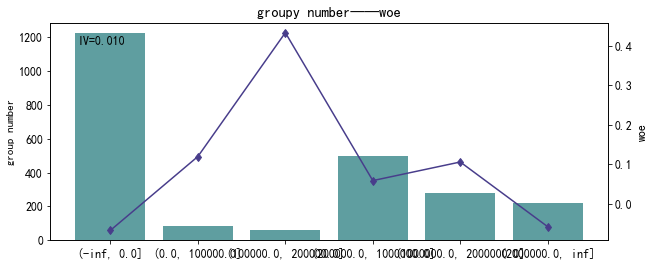

bad_count  good_count  n_group  \
prepay_total_amount_last_9months_fillna                                   
(-inf, 0.0]                                    433         791     1224   
(0.0, 100000.0]                                 33          50       83   
(100000.0, 200000.0]                            28          31       59   
(200000.0, 1000000.0]                          190         306      496   
(1000000.0, 2000000.0]                         110         169      279   
(2000000.0, inf]                                79         143      222   

                                         bad_rate       woe        iv  
prepay_total_amount_last_9months_fillna                                
(-inf, 0.0]                              0.353758 -0.067964  0.002371  
(0.0, 100000.0]                          0.397590  0.119080  0.000505  
(100000.0, 200000.0]                     0.474576  0.432813  0.004877  
(200000.0, 1000000.0]                    0.383065  0.058035  0.000712  
(1000000.0, 2000000.0]                   0.394265  0.105177  0.001323  
(2000000.0, inf]                         0.355856 -0.058801  0.000322

In [246]:
woe_function(df_train,df,'prepay_total_amount_last_9months',q=[0,100000,200000,1000000,2000000],woe_type='c')

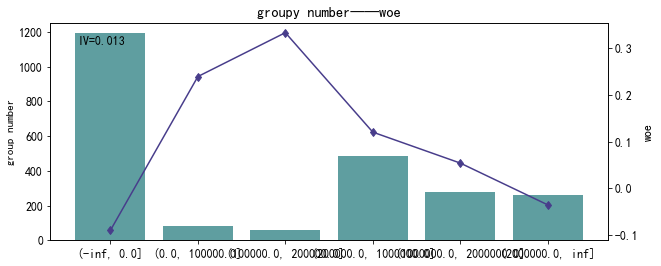

bad_count  good_count  n_group  \
prepay_total_amount_last_12months_fillna                                   
(-inf, 0.0]                                     416         777     1193   
(0.0, 100000.0]                                  35          47       82   
(100000.0, 200000.0]                             27          33       60   
(200000.0, 1000000.0]                           193         292      485   
(1000000.0, 2000000.0]                          107         173      280   
(2000000.0, inf]                                 95         168      263   

                                          bad_rate       woe        iv  
prepay_total_amount_last_12months_fillna                                
(-inf, 0.0]                               0.348701 -0.090159  0.004053  
(0.0, 100000.0]                           0.426829  0.239796  0.002050  
(100000.0, 200000.0]                      0.450000  0.333925  0.002932  
(200000.0, 1000000.0]                     0.397938  0.120532  0.003026  
(1000000.0, 2000000.0]                    0.382143  0.054133  0.000350  
(2000000.0, inf]                          0.361217 -0.035491  0.000140

In [247]:
woe_function(df_train,df,'prepay_total_amount_last_12months',q=[0,100000,200000,1000000,2000000],woe_type='c')

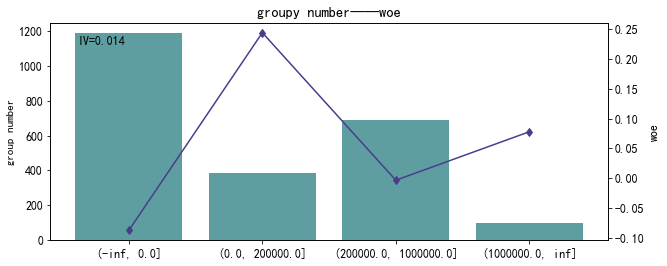

bad_count  good_count  n_group  bad_rate       woe  \
prepay_max_amount_fillna                                                       
(-inf, 0.0]                     415         773     1188  0.349327 -0.087405   
(0.0, 200000.0]                 166         222      388  0.427835  0.243906   
(200000.0, 1000000.0]           254         435      689  0.368650 -0.003416   
(1000000.0, inf]                 38          60       98  0.387755  0.077837   

                                iv  
prepay_max_amount_fillna            
(-inf, 0.0]               0.003795  
(0.0, 200000.0]           0.010038  
(200000.0, 1000000.0]     0.000003  
(1000000.0, inf]          0.000254

In [250]:
woe_function(df_train,df,'prepay_max_amount',q=[0,200000,1000000],woe_type='c')

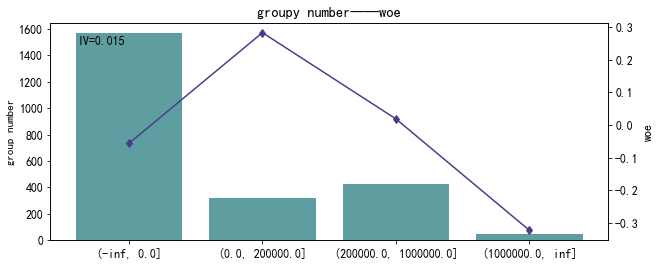

bad_count  good_count  n_group  \
prepay_max_amount_last_3months_fillna                                   
(-inf, 0.0]                                  559        1009     1568   
(0.0, 200000.0]                              140         180      320   
(200000.0, 1000000.0]                        160         268      428   
(1000000.0, inf]                              14          33       47   

                                       bad_rate       woe        iv  
prepay_max_amount_last_3months_fillna                                
(-inf, 0.0]                            0.356505 -0.055970  0.002063  
(0.0, 200000.0]                        0.437500  0.283281  0.011207  
(200000.0, 1000000.0]                  0.373832  0.018783  0.000064  
(1000000.0, inf]                       0.297872 -0.322854  0.001973

In [251]:
woe_function(df_train,df,'prepay_max_amount_last_3months',q=[0,200000,1000000],woe_type='c')

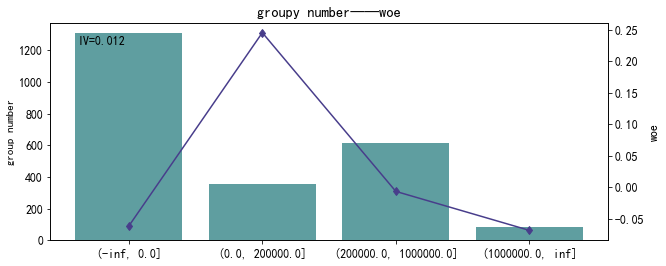

bad_count  good_count  n_group  \
prepay_max_amount_last_6months_fillna                                   
(-inf, 0.0]                                  465         844     1309   
(0.0, 200000.0]                              152         203      355   
(200000.0, 1000000.0]                        227         390      617   
(1000000.0, inf]                              29          53       82   

                                       bad_rate       woe        iv  
prepay_max_amount_last_6months_fillna                                
(-inf, 0.0]                            0.355233 -0.061519  0.002079  
(0.0, 200000.0]                        0.428169  0.245270  0.009289  
(200000.0, 1000000.0]                  0.367909 -0.006601  0.000011  
(1000000.0, inf]                       0.353659 -0.068400  0.000161

In [252]:
woe_function(df_train,df,'prepay_max_amount_last_6months',q=[0,200000,1000000],woe_type='c')

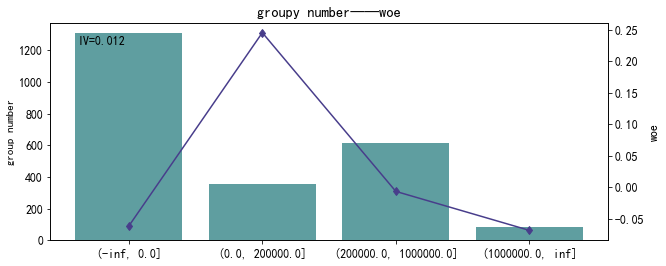

bad_count  good_count  n_group  \
prepay_max_amount_last_6months_fillna                                   
(-inf, 0.0]                                  465         844     1309   
(0.0, 200000.0]                              152         203      355   
(200000.0, 1000000.0]                        227         390      617   
(1000000.0, inf]                              29          53       82   

                                       bad_rate       woe        iv  
prepay_max_amount_last_6months_fillna                                
(-inf, 0.0]                            0.355233 -0.061519  0.002079  
(0.0, 200000.0]                        0.428169  0.245270  0.009289  
(200000.0, 1000000.0]                  0.367909 -0.006601  0.000011  
(1000000.0, inf]                       0.353659 -0.068400  0.000161

In [253]:
woe_function(df_train,df,'prepay_max_amount_last_6months',q=[0,200000,1000000],woe_type='c')

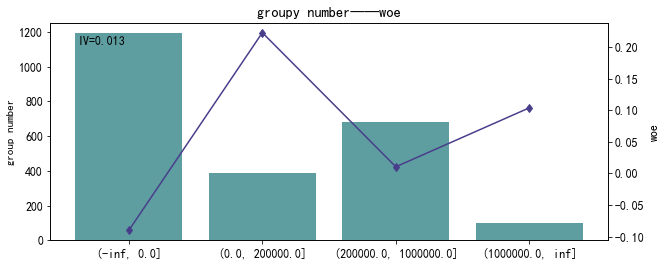

bad_count  good_count  n_group  \
prepay_max_amount_last_12months_fillna                                   
(-inf, 0.0]                                   416         777     1193   
(0.0, 200000.0]                               164         224      388   
(200000.0, 1000000.0]                         254         429      683   
(1000000.0, inf]                               39          60       99   

                                        bad_rate       woe        iv  
prepay_max_amount_last_12months_fillna                                
(-inf, 0.0]                             0.348701 -0.090159  0.004053  
(0.0, 200000.0]                         0.422680  0.222816  0.008361  
(200000.0, 1000000.0]                   0.371889  0.010473  0.000032  
(1000000.0, inf]                        0.393939  0.103813  0.000457

In [254]:
woe_function(df_train,df,'prepay_max_amount_last_12months',q=[0,200000,1000000],woe_type='c')

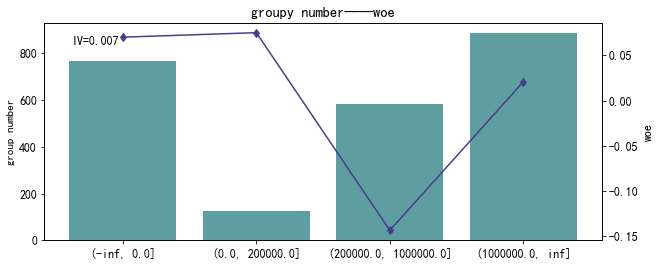

bad_count  good_count  n_group  bad_rate       woe  \
ontime_amount_fillna                                                        
(-inf, 0.0]                  296         471      767  0.385919  0.070097   
(0.0, 200000.0]               48          76      124  0.387097  0.075064   
(200000.0, 1000000.0]        197         388      585  0.336752 -0.143206   
(1000000.0, inf]             332         555      887  0.374295  0.020763   

                             iv  
ontime_amount_fillna             
(-inf, 0.0]            0.001609  
(0.0, 200000.0]        0.000298  
(200000.0, 1000000.0]  0.004976  
(1000000.0, inf]       0.000162

In [255]:
woe_function(df_train,df,'ontime_amount',q=[0,200000,1000000],woe_type='c')

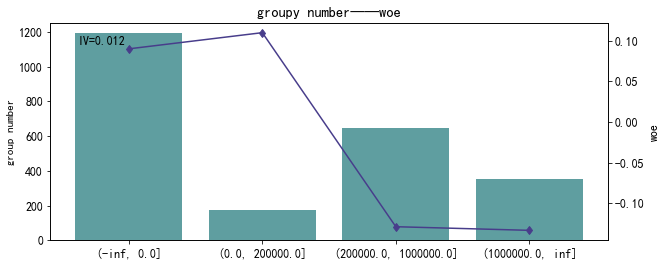

bad_count  good_count  n_group  bad_rate  \
ontime_amount_last_3months_fillna                                             
(-inf, 0.0]                              466         727     1193  0.390612   
(0.0, 200000.0]                           68         104      172  0.395349   
(200000.0, 1000000.0]                    220         427      647  0.340031   
(1000000.0, inf]                         119         232      351  0.339031   

                                        woe        iv  
ontime_amount_last_3months_fillna                      
(-inf, 0.0]                        0.089855  0.004122  
(0.0, 200000.0]                    0.109713  0.000888  
(200000.0, 1000000.0]             -0.128561  0.004445  
(1000000.0, inf]                  -0.133018  0.002580

In [256]:
woe_function(df_train,df,'ontime_amount_last_3months',q=[0,200000,1000000],woe_type='c')

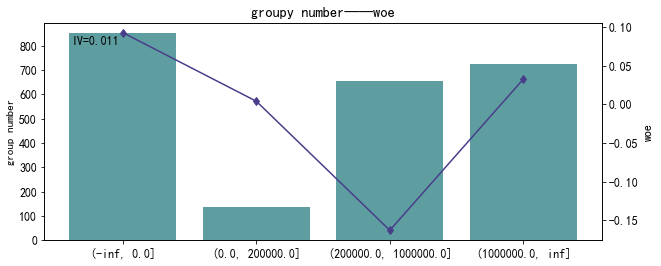

bad_count  good_count  n_group  bad_rate  \
ontime_amount_last_6months_fillna                                             
(-inf, 0.0]                              333         518      851  0.391304   
(0.0, 200000.0]                           50          85      135  0.370370   
(200000.0, 1000000.0]                    217         436      653  0.332312   
(1000000.0, inf]                         273         451      724  0.377072   

                                        woe            iv  
ontime_amount_last_6months_fillna                          
(-inf, 0.0]                        0.092763  3.134677e-03  
(0.0, 200000.0]                    0.003968  8.998052e-07  
(200000.0, 1000000.0]             -0.163149  7.186600e-03  
(1000000.0, inf]                   0.032600  3.269879e-04

In [257]:
woe_function(df_train,df,'ontime_amount_last_6months',q=[0,200000,1000000],woe_type='c')

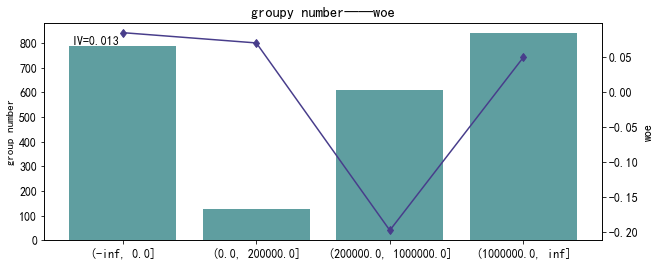

bad_count  good_count  n_group  bad_rate  \
ontime_amount_last_9months_fillna                                             
(-inf, 0.0]                              306         480      786  0.389313   
(0.0, 200000.0]                           49          78      127  0.385827   
(200000.0, 1000000.0]                    198         412      610  0.324590   
(1000000.0, inf]                         320         520      840  0.380952   

                                        woe        iv  
ontime_amount_last_9months_fillna                      
(-inf, 0.0]                        0.084395  0.002394  
(0.0, 200000.0]                    0.069707  0.000263  
(200000.0, 1000000.0]             -0.198160  0.009850  
(1000000.0, inf]                   0.049088  0.000862

In [258]:
woe_function(df_train,df,'ontime_amount_last_9months',q=[0,200000,1000000],woe_type='c')

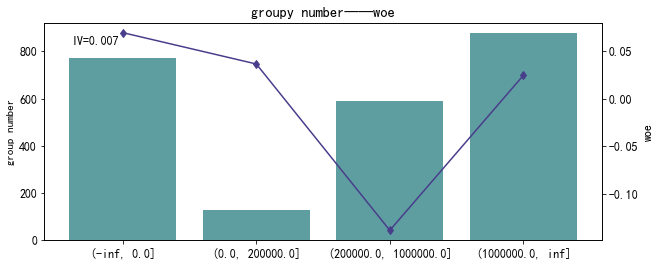

bad_count  good_count  n_group  bad_rate  \
ontime_amount_last_12months_fillna                                             
(-inf, 0.0]                               297         473      770  0.385714   
(0.0, 200000.0]                            48          79      127  0.377953   
(200000.0, 1000000.0]                     199         390      589  0.337861   
(1000000.0, inf]                          329         548      877  0.375143   

                                         woe        iv  
ontime_amount_last_12months_fillna                      
(-inf, 0.0]                         0.069233  0.001575  
(0.0, 200000.0]                     0.036349  0.000071  
(200000.0, 1000000.0]              -0.138246  0.004672  
(1000000.0, inf]                    0.024378  0.000221

In [259]:
woe_function(df_train,df,'ontime_amount_last_12months',q=[0,200000,1000000],woe_type='c')

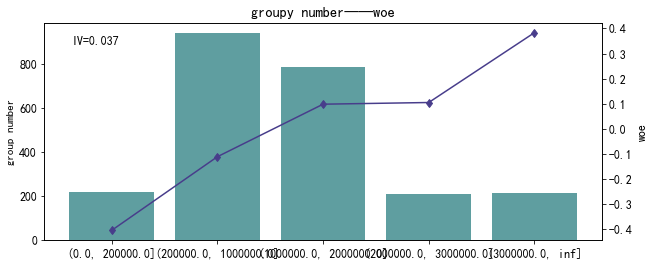

bad_count  good_count  n_group  bad_rate       woe  \
overdue_amount_fillna                                                        
(0.0, 200000.0]                61         156      217  0.281106 -0.404386   
(200000.0, 1000000.0]         323         616      939  0.343983 -0.110999   
(1000000.0, 2000000.0]        309         478      787  0.392630  0.098326   
(2000000.0, 3000000.0]         82         126      208  0.394231  0.105033   
(3000000.0, inf]               98         114      212  0.462264  0.383365   

                              iv  
overdue_amount_fillna             
(0.0, 200000.0]         0.014082  
(200000.0, 1000000.0]   0.004821  
(1000000.0, 2000000.0]  0.003259  
(2000000.0, 3000000.0]  0.000984  
(3000000.0, inf]        0.013704

In [264]:
woe_function(df_train,df,'overdue_amount',q=[0,200000,1000000,2000000,3000000],woe_type='c')

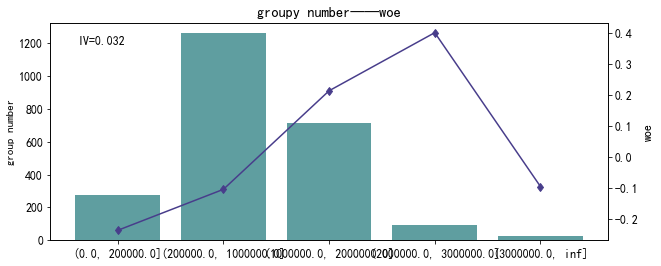

bad_count  good_count  n_group  bad_rate  \
overdue_amount_last_3months_fillna                                             
(0.0, 200000.0]                            88         190      278  0.316547   
(200000.0, 1000000.0]                     436         825     1261  0.345757   
(1000000.0, 2000000.0]                    299         412      711  0.420534   
(2000000.0, 3000000.0]                     42          48       90  0.466667   
(3000000.0, inf]                            8          15       23  0.347826   

                                         woe        iv  
overdue_amount_last_3months_fillna                      
(0.0, 200000.0]                    -0.235091  0.006280  
(200000.0, 1000000.0]              -0.103145  0.005597  
(1000000.0, 2000000.0]              0.214016  0.014122  
(2000000.0, 3000000.0]              0.401064  0.006375  
(3000000.0, inf]                   -0.094013  0.000085

In [265]:
woe_function(df_train,df,'overdue_amount_last_3months',q=[0,200000,1000000,2000000,3000000],woe_type='c')

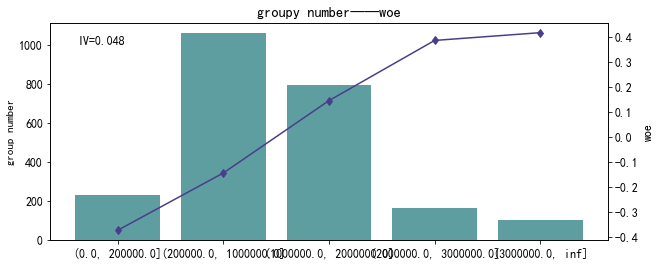

bad_count  good_count  n_group  bad_rate  \
overdue_amount_last_6months_fillna                                             
(0.0, 200000.0]                            67         166      233  0.287554   
(200000.0, 1000000.0]                     358         705     1063  0.336783   
(1000000.0, 2000000.0]                    323         476      799  0.404255   
(2000000.0, 3000000.0]                     76          88      164  0.463415   
(3000000.0, inf]                           49          55      104  0.471154   

                                         woe        iv  
overdue_amount_last_6months_fillna                      
(0.0, 200000.0]                    -0.372699  0.012919  
(200000.0, 1000000.0]              -0.143069  0.009024  
(1000000.0, 2000000.0]              0.146830  0.007419  
(2000000.0, 3000000.0]              0.387992  0.010862  
(3000000.0, inf]                    0.419083  0.008053

In [266]:
woe_function(df_train,df,'overdue_amount_last_6months',q=[0,200000,1000000,2000000,3000000],woe_type='c')

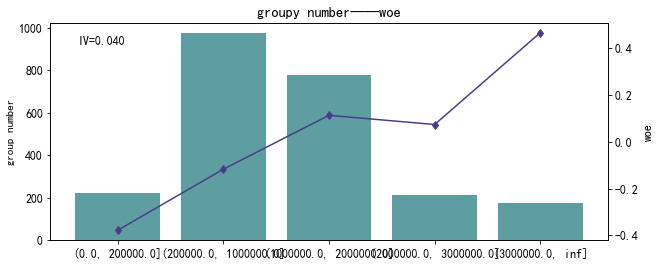

bad_count  good_count  n_group  bad_rate  \
overdue_amount_last_9months_fillna                                             
(0.0, 200000.0]                            63         157      220  0.286364   
(200000.0, 1000000.0]                     334         641      975  0.342564   
(1000000.0, 2000000.0]                    309         471      780  0.396154   
(2000000.0, 3000000.0]                     82         130      212  0.386792   
(3000000.0, inf]                           85          91      176  0.482955   

                                         woe        iv  
overdue_amount_last_9months_fillna                      
(0.0, 200000.0]                    -0.378515  0.012568  
(200000.0, 1000000.0]              -0.117293  0.005585  
(1000000.0, 2000000.0]              0.113079  0.004279  
(2000000.0, 3000000.0]              0.073781  0.000493  
(3000000.0, inf]                    0.466388  0.016926

In [267]:
woe_function(df_train,df,'overdue_amount_last_9months',q=[0,200000,1000000,2000000,3000000],woe_type='c')

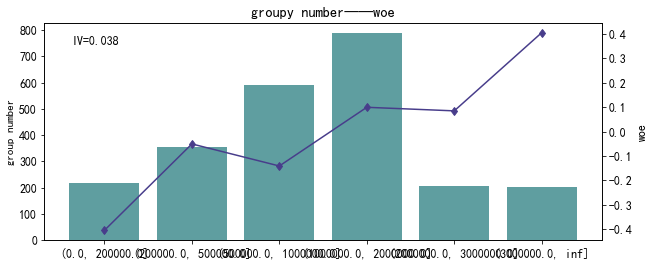

bad_count  good_count  n_group  bad_rate  \
overdue_amount_last_12months_fillna                                             
(0.0, 200000.0]                             61         156      217  0.281106   
(200000.0, 500000.0]                       127         228      355  0.357746   
(500000.0, 1000000.0]                      200         393      593  0.337268   
(1000000.0, 2000000.0]                     310         479      789  0.392902   
(2000000.0, 3000000.0]                      81         127      208  0.389423   
(3000000.0, inf]                            94         107      201  0.467662   

                                          woe        iv  
overdue_amount_last_12months_fillna                      
(0.0, 200000.0]                     -0.404386  0.014082  
(200000.0, 500000.0]                -0.050563  0.000381  
(500000.0, 1000000.0]               -0.140896  0.004884  
(1000000.0, 2000000.0]               0.099468  0.003344  
(2000000.0, 3000000.0]               0.084858  0.000641  
(3000000.0, inf]                     0.405062  0.014527

In [269]:
woe_function(df_train,df,'overdue_amount_last_12months',q=[0,200000,500000,1000000,2000000,3000000],woe_type='c')

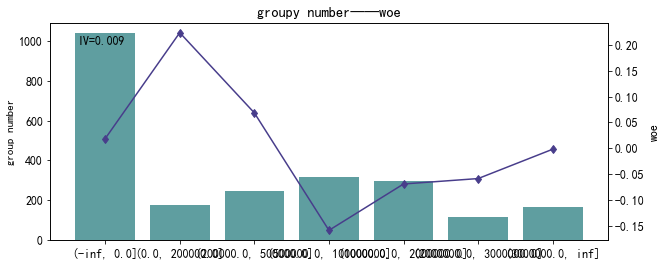

bad_count  good_count  n_group  bad_rate       woe  \
prepay_amount_fillna                                                         
(-inf, 0.0]                   388         650     1038  0.373796  0.018629   
(0.0, 200000.0]                74         101      175  0.422857  0.223540   
(200000.0, 500000.0]           96         153      249  0.385542  0.068506   
(500000.0, 1000000.0]         106         212      318  0.333333 -0.158551   
(1000000.0, 2000000.0]        105         192      297  0.353535 -0.068939   
(2000000.0, 3000000.0]         42          76      118  0.355932 -0.058468   
(3000000.0, inf]               62         106      168  0.369048 -0.001709   

                                  iv  
prepay_amount_fillna                  
(-inf, 0.0]             1.528091e-04  
(0.0, 200000.0]         3.795704e-03  
(200000.0, 500000.0]    4.987979e-04  
(500000.0, 1000000.0]   3.307617e-03  
(1000000.0, 2000000.0]  5.917840e-04  
(2000000.0, 3000000.0]  1.693666e-04  
(3000000.0, inf]        2.075700e-07

In [270]:
woe_function(df_train,df,'prepay_amount',q=[0,200000,500000,1000000,2000000,3000000],woe_type='c')

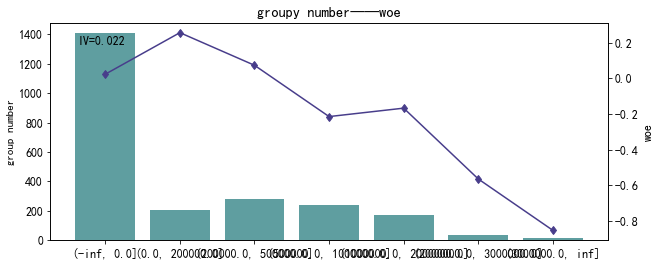

bad_count  good_count  n_group  bad_rate  \
prepay_amount_last_3months_fillna                                             
(-inf, 0.0]                              528         881     1409  0.374734   
(0.0, 200000.0]                           90         119      209  0.430622   
(200000.0, 500000.0]                     109         173      282  0.386525   
(500000.0, 1000000.0]                     78         165      243  0.320988   
(1000000.0, 2000000.0]                    56         113      169  0.331361   
(2000000.0, 3000000.0]                     9          27       36  0.250000   
(3000000.0, inf]                           3          12       15  0.200000   

                                        woe        iv  
prepay_amount_last_3months_fillna                      
(-inf, 0.0]                        0.022635  0.000306  
(0.0, 200000.0]                    0.255282  0.005929  
(200000.0, 500000.0]               0.072652  0.000636  
(500000.0, 1000000.0]             -0.214641  0.004591  
(1000000.0, 2000000.0]            -0.167440  0.001958  
(2000000.0, 3000000.0]            -0.564016  0.004406  
(3000000.0, inf]                  -0.851699  0.003933

In [271]:
woe_function(df_train,df,'prepay_amount_last_3months',q=[0,200000,500000,1000000,2000000,3000000],woe_type='c')

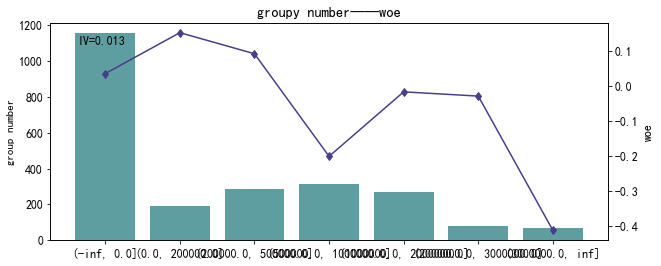

bad_count  good_count  n_group  bad_rate  \
prepay_amount_last_6months_fillna                                             
(-inf, 0.0]                              436         719     1155  0.377489   
(0.0, 200000.0]                           77         113      190  0.405263   
(200000.0, 500000.0]                     111         173      284  0.390845   
(500000.0, 1000000.0]                    102         213      315  0.323810   
(1000000.0, 2000000.0]                    99         172      271  0.365314   
(2000000.0, 3000000.0]                    29          51       80  0.362500   
(3000000.0, inf]                          19          49       68  0.279412   

                                        woe        iv  
prepay_amount_last_6months_fillna                      
(-inf, 0.0]                        0.034377  0.000580  
(0.0, 200000.0]                    0.151013  0.001867  
(200000.0, 500000.0]               0.090834  0.001003  
(500000.0, 1000000.0]             -0.201724  0.005268  
(1000000.0, 2000000.0]            -0.017779  0.000036  
(2000000.0, 3000000.0]            -0.029934  0.000030  
(3000000.0, inf]                  -0.412785  0.004591

In [272]:
woe_function(df_train,df,'prepay_amount_last_6months',q=[0,200000,500000,1000000,2000000,3000000],woe_type='c')

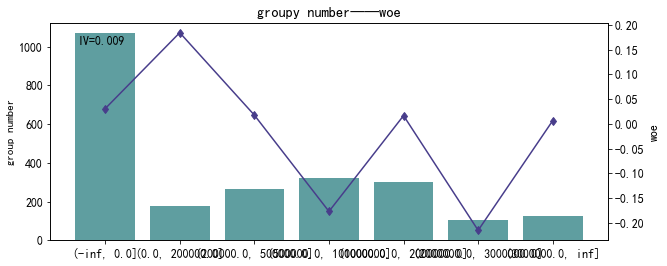

bad_count  good_count  n_group  bad_rate  \
prepay_amount_last_9months_fillna                                             
(-inf, 0.0]                              403         667     1070  0.376636   
(0.0, 200000.0]                           74         105      179  0.413408   
(200000.0, 500000.0]                      99         166      265  0.373585   
(500000.0, 1000000.0]                    105         214      319  0.329154   
(1000000.0, 2000000.0]                   112         188      300  0.373333   
(2000000.0, 3000000.0]                    34          72      106  0.320755   
(3000000.0, inf]                          46          78      124  0.370968   

                                        woe        iv  
prepay_amount_last_9months_fillna                      
(-inf, 0.0]                        0.030742  0.000430  
(0.0, 200000.0]                    0.184701  0.002640  
(200000.0, 500000.0]               0.017728  0.000035  
(500000.0, 1000000.0]             -0.177420  0.004143  
(1000000.0, 2000000.0]             0.016653  0.000035  
(2000000.0, 3000000.0]            -0.215710  0.002022  
(3000000.0, inf]                   0.006528  0.000002

In [273]:
woe_function(df_train,df,'prepay_amount_last_9months',q=[0,200000,500000,1000000,2000000,3000000],woe_type='c')

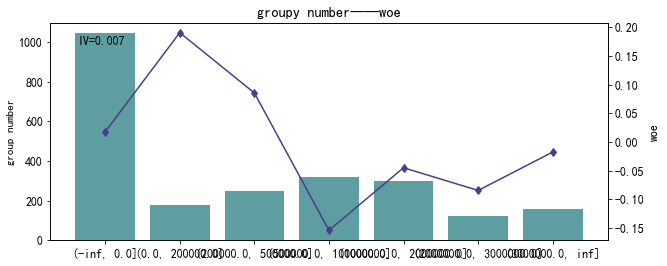

bad_count  good_count  n_group  bad_rate  \
prepay_amount_last_12months_fillna                                             
(-inf, 0.0]                               390         654     1044  0.373563   
(0.0, 200000.0]                            73         103      176  0.414773   
(200000.0, 500000.0]                       97         152      249  0.389558   
(500000.0, 1000000.0]                     107         213      320  0.334375   
(1000000.0, 2000000.0]                    107         191      298  0.359060   
(2000000.0, 3000000.0]                     42          78      120  0.350000   
(3000000.0, inf]                           57          99      156  0.365385   

                                         woe        iv  
prepay_amount_last_12months_fillna                      
(-inf, 0.0]                         0.017635  0.000138  
(0.0, 200000.0]                     0.190326  0.002758  
(200000.0, 500000.0]                0.085426  0.000777  
(500000.0, 1000000.0]              -0.153867  0.003137  
(1000000.0, 2000000.0]             -0.044849  0.000252  
(2000000.0, 3000000.0]             -0.084443  0.000358  
(3000000.0, inf]                   -0.017473  0.000020

In [274]:
woe_function(df_train,df,'prepay_amount_last_12months',q=[0,200000,500000,1000000,2000000,3000000],woe_type='c')

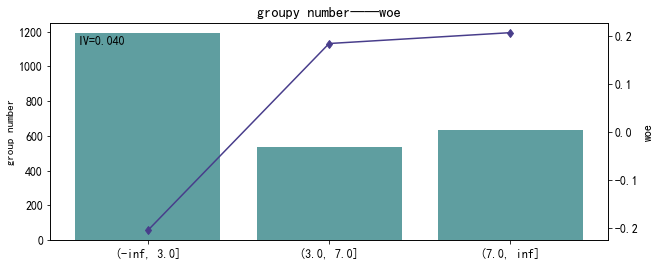

bad_count  good_count  n_group  \
observation_overdue1day_times_fillna                                   
(-inf, 3.0]                                 385         806     1191   
(3.0, 7.0]                                  222         315      537   
(7.0, inf]                                  266         369      635   

                                      bad_rate       woe        iv  
observation_overdue1day_times_fillna                                
(-inf, 3.0]                           0.323258 -0.204245  0.020410  
(3.0, 7.0]                            0.413408  0.184701  0.007921  
(7.0, inf]                            0.418898  0.207296  0.011825

In [278]:
woe_function(df_train,df,'observation_overdue1day_times',q=[3,7],woe_type='c')

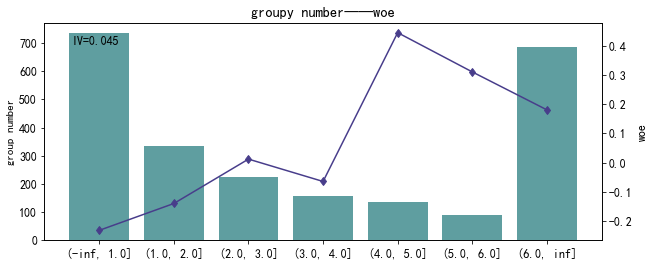

bad_count  good_count  n_group  \
observation_overdue5day_times_fillna                                   
(-inf, 1.0]                                 233         502      735   
(1.0, 2.0]                                  113         222      335   
(2.0, 3.0]                                   83         140      223   
(3.0, 4.0]                                   56         102      158   
(4.0, 5.0]                                   65          71      136   
(5.0, 6.0]                                   40          50       90   
(6.0, inf]                                  283         403      686   

                                      bad_rate       woe        iv  
observation_overdue5day_times_fillna                                
(-inf, 1.0]                           0.317007 -0.232966  0.016312  
(1.0, 2.0]                            0.337313 -0.140694  0.002751  
(2.0, 3.0]                            0.372197  0.011794  0.000013  
(3.0, 4.0]                            0.354430 -0.065025  0.000280  
(4.0, 5.0]                            0.477941  0.446303  0.011963  
(5.0, 6.0]                            0.444444  0.311452  0.003819  
(6.0, inf]                            0.412536  0.181106  0.009725

In [280]:
woe_function(df_train,df,'observation_overdue5day_times',q=[1,2,3,4,5,6],woe_type='c')

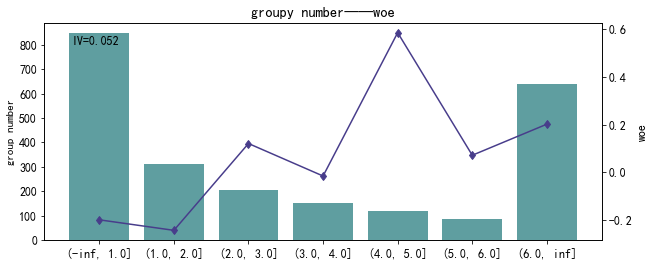

bad_count  good_count  n_group  \
observation_overdue10day_times_fillna                                   
(-inf, 1.0]                                  275         572      847   
(1.0, 2.0]                                    98         213      311   
(2.0, 3.0]                                    82         124      206   
(3.0, 4.0]                                    56          97      153   
(4.0, 5.0]                                    62          59      121   
(5.0, 6.0]                                    34          54       88   
(6.0, inf]                                   266         371      637   

                                       bad_rate       woe        iv  
observation_overdue10day_times_fillna                                
(-inf, 1.0]                            0.324675 -0.197772  0.013624  
(1.0, 2.0]                             0.315113 -0.241729  0.007420  
(2.0, 3.0]                             0.398058  0.121034  0.001296  
(3.0, 4.0]                             0.366013 -0.014763  0.000014  
(4.0, 5.0]                             0.512397  0.584193  0.018357  
(5.0, 6.0]                             0.386364  0.071972  0.000195  
(6.0, inf]                             0.417582  0.201890  0.011246

In [281]:
woe_function(df_train,df,'observation_overdue10day_times',q=[1,2,3,4,5,6],woe_type='c')

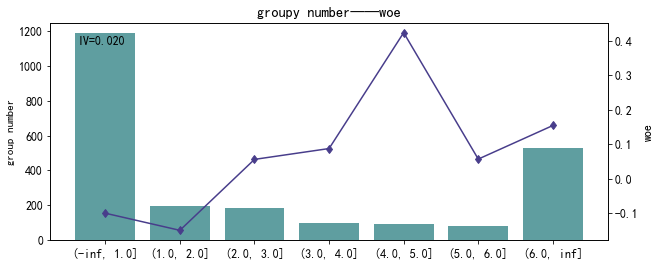

bad_count  good_count  n_group  \
observation_overdue30day_times_fillna                                   
(-inf, 1.0]                                  411         776     1187   
(1.0, 2.0]                                    65         129      194   
(2.0, 3.0]                                    70         113      183   
(3.0, 4.0]                                    39          61      100   
(4.0, 5.0]                                    43          48       91   
(5.0, 6.0]                                    31          50       81   
(6.0, inf]                                   214         313      527   

                                       bad_rate       woe        iv  
observation_overdue30day_times_fillna                                
(-inf, 1.0]                            0.346251 -0.100963  0.005050  
(1.0, 2.0]                             0.335052 -0.150829  0.001828  
(2.0, 3.0]                             0.382514  0.055703  0.000242  
(3.0, 4.0]                             0.390000  0.087284  0.000326  
(4.0, 5.0]                             0.472527  0.424595  0.007235  
(5.0, 6.0]                             0.382716  0.056560  0.000110  
(6.0, inf]                             0.406072  0.154369  0.005413

In [282]:
woe_function(df_train,df,'observation_overdue30day_times',q=[1,2,3,4,5,6],woe_type='c')

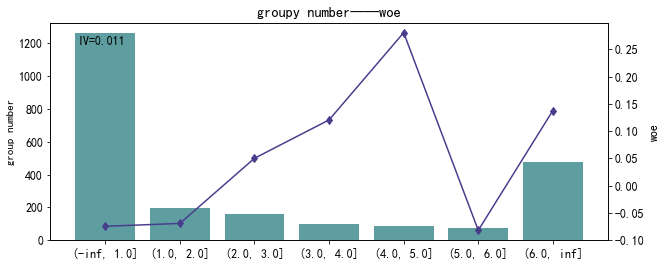

bad_count  good_count  n_group  \
observation_overdue60day_times_fillna                                   
(-inf, 1.0]                                  445         818     1263   
(1.0, 2.0]                                    70         128      198   
(2.0, 3.0]                                    61          99      160   
(3.0, 4.0]                                    39          59       98   
(4.0, 5.0]                                    38          49       87   
(5.0, 6.0]                                    27          50       77   
(6.0, inf]                                   193         287      480   

                                       bad_rate       woe        iv  
observation_overdue60day_times_fillna                                
(-inf, 1.0]                            0.352336 -0.074192  0.002913  
(1.0, 2.0]                             0.353535 -0.068939  0.000395  
(2.0, 3.0]                             0.381250  0.050350  0.000173  
(3.0, 4.0]                             0.397959  0.120620  0.000612  
(4.0, 5.0]                             0.436782  0.280362  0.002984  
(5.0, 6.0]                             0.350649 -0.081590  0.000215  
(6.0, inf]                             0.402083  0.137804  0.003922

In [283]:
woe_function(df_train,df,'observation_overdue60day_times',q=[1,2,3,4,5,6],woe_type='c')

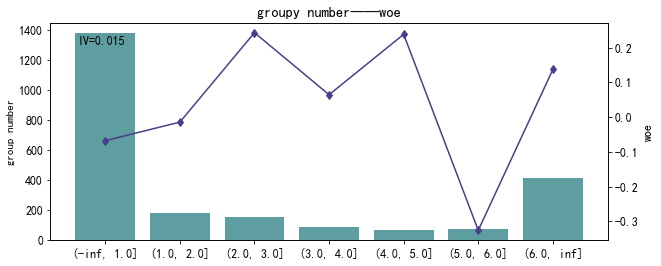

bad_count  good_count  n_group  \
observation_overdue90day_times_fillna                                   
(-inf, 1.0]                                  489         893     1382   
(1.0, 2.0]                                    67         116      183   
(2.0, 3.0]                                    65          87      152   
(3.0, 4.0]                                    35          56       91   
(4.0, 5.0]                                    29          39       68   
(5.0, 6.0]                                    22          52       74   
(6.0, inf]                                   166         247      413   

                                       bad_rate       woe        iv  
observation_overdue90day_times_fillna                                
(-inf, 1.0]                            0.353835 -0.067628  0.002650  
(1.0, 2.0]                             0.366120 -0.014302  0.000016  
(2.0, 3.0]                             0.427632  0.243075  0.003905  
(3.0, 4.0]                             0.384615  0.064592  0.000162  
(4.0, 5.0]                             0.426471  0.238330  0.001679  
(5.0, 6.0]                             0.297297 -0.325605  0.003158  
(6.0, inf]                             0.401937  0.137195  0.003344

In [284]:
woe_function(df_train,df,'observation_overdue90day_times',q=[1,2,3,4,5,6],woe_type='c')

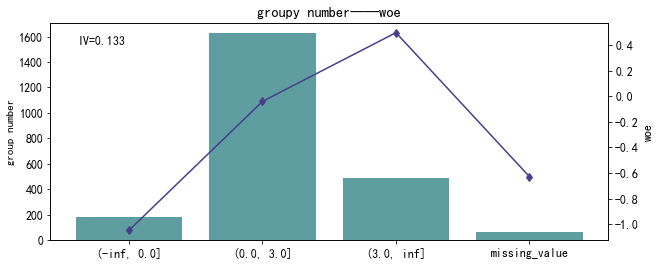

bad_count  good_count  n_group  bad_rate       woe  \
overdue_1day_times_fillna                                                       
(-inf, 0.0]                       31         151      182  0.170330 -1.048697   
(0.0, 3.0]                       586        1041     1627  0.360172 -0.040021   
(3.0, inf]                       241         250      491  0.490835  0.497932   
missing_value                     15          48       63  0.238095 -0.628555   

                                 iv  
overdue_1day_times_fillna            
(-inf, 0.0]                0.069038  
(0.0, 3.0]                 0.001097  
(3.0, inf]                 0.053913  
missing_value              0.009449

In [288]:
woe_function(df_train,df,'overdue_1day_times',q=[0,3],woe_type='c')

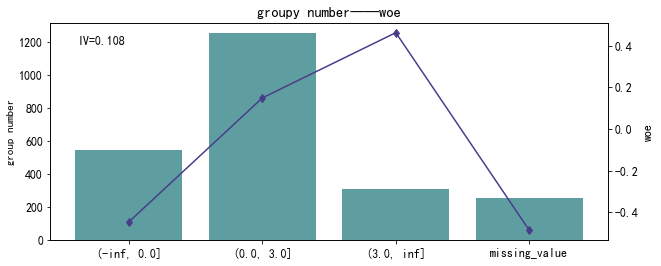

bad_count  good_count  n_group  bad_rate       woe  \
overdue_5day_times_fillna                                                       
(-inf, 0.0]                      148         395      543  0.272560 -0.447078   
(0.0, 3.0]                       507         745     1252  0.404952  0.149723   
(3.0, inf]                       150         161      311  0.482315  0.463827   
missing_value                     68         189      257  0.264591 -0.487643   

                                 iv  
overdue_5day_times_fillna            
(-inf, 0.0]                0.042727  
(0.0, 3.0]                 0.012091  
(3.0, inf]                 0.029577  
missing_value              0.023872

In [289]:
woe_function(df_train,df,'overdue_5day_times',q=[0,3],woe_type='c')

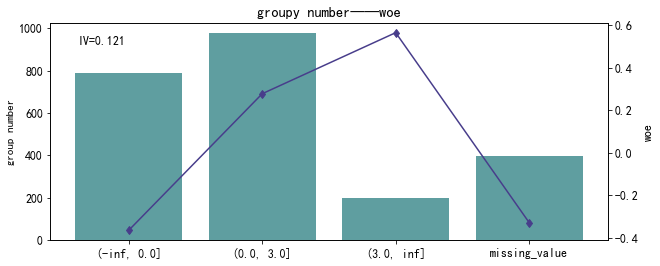

bad_count  good_count  n_group  bad_rate  \
overdue_10day_times_fillna                                             
(-inf, 0.0]                       228         561      789  0.288973   
(0.0, 3.0]                        426         551      977  0.436029   
(3.0, inf]                        101          98      199  0.507538   
missing_value                     118         280      398  0.296482   

                                 woe        iv  
overdue_10day_times_fillna                      
(-inf, 0.0]                -0.365779  0.042190  
(0.0, 3.0]                  0.277300  0.032770  
(3.0, inf]                  0.564749  0.028193  
missing_value              -0.329509  0.017383

In [290]:
woe_function(df_train,df,'overdue_10day_times',q=[0,3],woe_type='c')

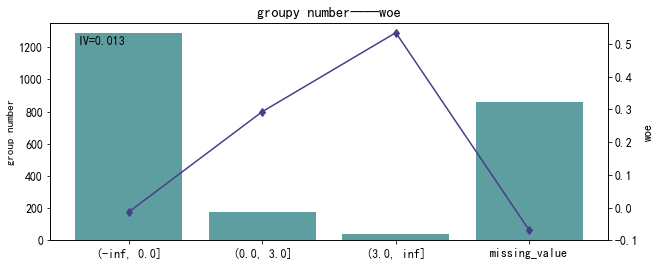

bad_count  good_count  n_group  bad_rate  \
overdue_30day_times_fillna                                             
(-inf, 0.0]                       472         816     1288  0.366460   
(0.0, 3.0]                         77          98      175  0.440000   
(3.0, inf]                         20          20       40  0.500000   
missing_value                     304         556      860  0.353488   

                                 woe        iv  
overdue_30day_times_fillna                      
(-inf, 0.0]                -0.012840  0.000090  
(0.0, 3.0]                  0.293434  0.006582  
(3.0, inf]                  0.534596  0.005072  
missing_value              -0.069145  0.001724

In [291]:
woe_function(df_train,df,'overdue_30day_times',q=[0,3],woe_type='c')

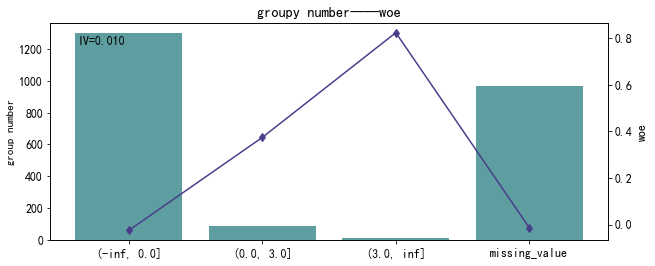

bad_count  good_count  n_group  bad_rate  \
overdue_60day_times_fillna                                             
(-inf, 0.0]                       472         826     1298  0.363636   
(0.0, 3.0]                         40          47       87  0.459770   
(3.0, inf]                          8           6       14  0.571429   
missing_value                     353         611      964  0.366183   

                                 woe        iv  
overdue_60day_times_fillna                      
(-inf, 0.0]                -0.025020  0.000343  
(0.0, 3.0]                  0.373328  0.005329  
(3.0, inf]                  0.822278  0.004224  
missing_value              -0.014033  0.000080

In [292]:
woe_function(df_train,df,'overdue_60day_times',q=[0,3],woe_type='c')

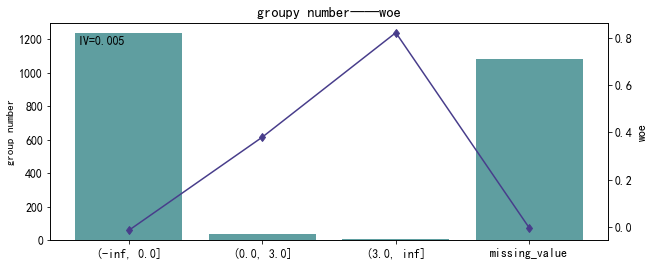

bad_count  good_count  n_group  bad_rate  \
overdue_90day_times_fillna                                             
(-inf, 0.0]                       453         784     1237  0.366209   
(0.0, 3.0]                         18          21       39  0.461538   
(3.0, inf]                          4           3        7  0.571429   
missing_value                     398         682     1080  0.368519   

                                 woe        iv  
overdue_90day_times_fillna                      
(-inf, 0.0]                -0.013921  0.000101  
(0.0, 3.0]                  0.380445  0.002482  
(3.0, inf]                  0.822278  0.002112  
missing_value              -0.003982  0.000007

In [293]:
woe_function(df_train,df,'overdue_90day_times',q=[0,3],woe_type='c')

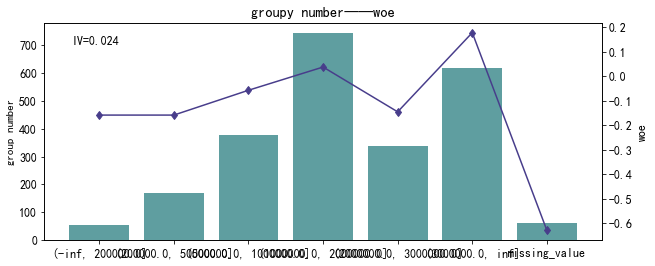

bad_count  good_count  n_group  \
observation_overdue1day_amount_fillna                                   
(-inf, 200000.0]                              18          36       54   
(200000.0, 500000.0]                          56         112      168   
(500000.0, 1000000.0]                        135         244      379   
(1000000.0, 2000000.0]                       281         462      743   
(2000000.0, 3000000.0]                       114         225      339   
(3000000.0, inf]                             254         363      617   
missing_value                                 15          48       63   

                                       bad_rate       woe        iv  
observation_overdue1day_amount_fillna                                
(-inf, 200000.0]                       0.333333 -0.158551  0.000562  
(200000.0, 500000.0]                   0.333333 -0.158551  0.001747  
(500000.0, 1000000.0]                  0.356201 -0.057298  0.000523  
(1000000.0, 2000000.0]                 0.378197  0.037386  0.000442  
(2000000.0, 3000000.0]                 0.336283 -0.145306  0.002968  
(3000000.0, inf]                       0.411669  0.177527  0.008402  
missing_value                          0.238095 -0.628555  0.009449

In [295]:
woe_function(df_train,df,'observation_overdue1day_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

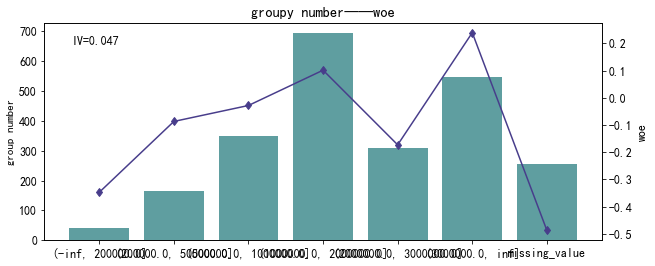

bad_count  good_count  n_group  \
observation_overdue5day_amount_fillna                                   
(-inf, 200000.0]                              12          29       41   
(200000.0, 500000.0]                          58         108      166   
(500000.0, 1000000.0]                        127         223      350   
(1000000.0, 2000000.0]                       273         421      694   
(2000000.0, 3000000.0]                       102         207      309   
(3000000.0, inf]                             233         313      546   
missing_value                                 68         189      257   

                                       bad_rate       woe        iv  
observation_overdue5day_amount_fillna                                
(-inf, 200000.0]                       0.292683 -0.347793  0.001988  
(200000.0, 500000.0]                   0.349398 -0.087092  0.000527  
(500000.0, 1000000.0]                  0.362857 -0.028389  0.000119  
(1000000.0, 2000000.0]                 0.393372  0.101435  0.003060  
(2000000.0, 3000000.0]                 0.330097 -0.173150  0.003824  
(3000000.0, inf]                       0.426740  0.239431  0.013607  
missing_value                          0.264591 -0.487643  0.023872

In [296]:
woe_function(df_train,df,'observation_overdue5day_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

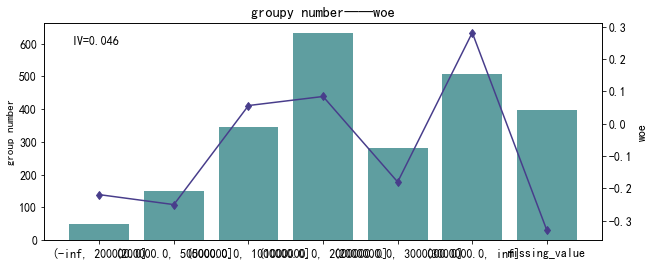

bad_count  good_count  n_group  \
observation_overdue10day_amount_fillna                                   
(-inf, 200000.0]                               16          34       50   
(200000.0, 500000.0]                           47         103      150   
(500000.0, 1000000.0]                         132         213      345   
(1000000.0, 2000000.0]                        246         386      632   
(2000000.0, 3000000.0]                         92         188      280   
(3000000.0, inf]                              222         286      508   
missing_value                                 118         280      398   

                                        bad_rate       woe        iv  
observation_overdue10day_amount_fillna                                
(-inf, 200000.0]                        0.320000 -0.219176  0.000984  
(200000.0, 500000.0]                    0.313333 -0.249986  0.003822  
(500000.0, 1000000.0]                   0.382609  0.056106  0.000463  
(1000000.0, 2000000.0]                  0.389241  0.084090  0.001911  
(2000000.0, 3000000.0]                  0.328571 -0.180058  0.003744  
(3000000.0, inf]                        0.437008  0.281281  0.017538  
missing_value                           0.296482 -0.329509  0.017383

In [297]:
woe_function(df_train,df,'observation_overdue10day_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

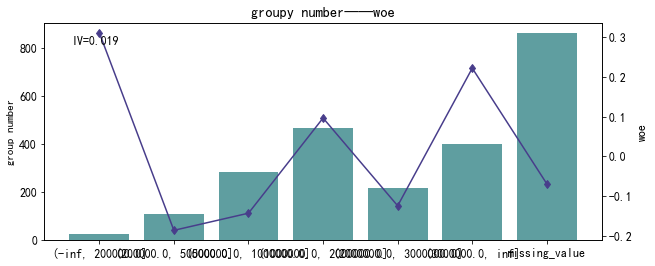

bad_count  good_count  n_group  \
observation_overdue30day_amount_fillna                                   
(-inf, 200000.0]                               12          15       27   
(200000.0, 500000.0]                           36          74      110   
(500000.0, 1000000.0]                          96         189      285   
(1000000.0, 2000000.0]                        182         282      464   
(2000000.0, 3000000.0]                         74         143      217   
(3000000.0, inf]                              169         231      400   
missing_value                                 304         556      860   

                                        bad_rate       woe        iv  
observation_overdue30day_amount_fillna                                
(-inf, 200000.0]                        0.444444  0.311452  0.001146  
(200000.0, 500000.0]                    0.327273 -0.185950  0.001567  
(500000.0, 1000000.0]                   0.336842 -0.142803  0.002411  
(1000000.0, 2000000.0]                  0.392241  0.096695  0.001858  
(2000000.0, 3000000.0]                  0.341014 -0.124184  0.001392  
(3000000.0, inf]                        0.422500  0.222077  0.008561  
missing_value                           0.353488 -0.069145  0.001724

In [298]:
woe_function(df_train,df,'observation_overdue30day_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

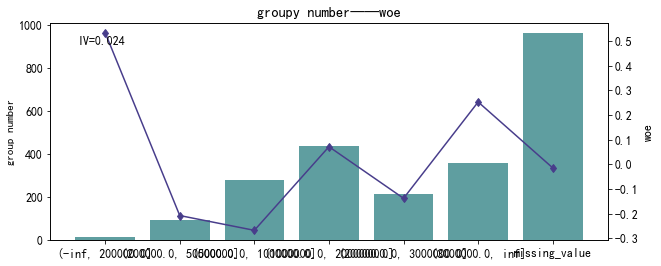

bad_count  good_count  n_group  \
observation_overdue60day_amount_fillna                                   
(-inf, 200000.0]                                7           7       14   
(200000.0, 500000.0]                           30          63       93   
(500000.0, 1000000.0]                          87         194      281   
(1000000.0, 2000000.0]                        170         270      440   
(2000000.0, 3000000.0]                         72         141      213   
(3000000.0, inf]                              154         204      358   
missing_value                                 353         611      964   

                                        bad_rate       woe        iv  
observation_overdue60day_amount_fillna                                
(-inf, 200000.0]                        0.500000  0.534596  0.001775  
(200000.0, 500000.0]                    0.322581 -0.207342  0.001642  
(500000.0, 1000000.0]                   0.309609 -0.267354  0.008166  
(1000000.0, 2000000.0]                  0.386364  0.071972  0.000973  
(2000000.0, 3000000.0]                  0.338028 -0.137498  0.001672  
(3000000.0, inf]                        0.430168  0.253428  0.010008  
missing_value                           0.366183 -0.014033  0.000080

In [299]:
woe_function(df_train,df,'observation_overdue60day_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

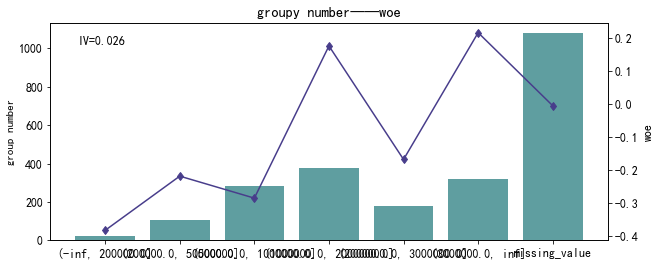

bad_count  good_count  n_group  \
observation_overdue90day_amount_fillna                                   
(-inf, 200000.0]                                6          15       21   
(200000.0, 500000.0]                           33          70      103   
(500000.0, 1000000.0]                          86         195      281   
(1000000.0, 2000000.0]                        156         223      379   
(2000000.0, 3000000.0]                         60         121      181   
(3000000.0, inf]                              134         184      318   
missing_value                                 398         682     1080   

                                        bad_rate       woe        iv  
observation_overdue90day_amount_fillna                                
(-inf, 200000.0]                        0.285714 -0.381695  0.001219  
(200000.0, 500000.0]                    0.320388 -0.217392  0.001995  
(500000.0, 1000000.0]                   0.306050 -0.284056  0.009193  
(1000000.0, 2000000.0]                  0.411609  0.177280  0.005146  
(2000000.0, 3000000.0]                  0.331492 -0.166850  0.002082  
(3000000.0, inf]                        0.421384  0.217500  0.006526  
missing_value                           0.368519 -0.003982  0.000007

In [300]:
woe_function(df_train,df,'observation_overdue90day_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

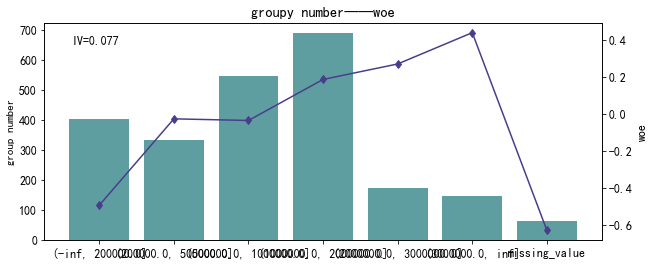

bad_count  good_count  n_group  bad_rate       woe  \
overdue1day_amount_fillna                                                       
(-inf, 200000.0]                 107         299      406  0.263547 -0.493019   
(200000.0, 500000.0]             121         212      333  0.363363 -0.026200   
(500000.0, 1000000.0]            198         350      548  0.361314 -0.035070   
(1000000.0, 2000000.0]           286         405      691  0.413893  0.186701   
(2000000.0, 3000000.0]            76          99      175  0.434286  0.270209   
(3000000.0, inf]                  70          77      147  0.476190  0.439286   
missing_value                     15          48       63  0.238095 -0.628555   

                                 iv  
overdue1day_amount_fillna            
(-inf, 200000.0]           0.038507  
(200000.0, 500000.0]       0.000096  
(500000.0, 1000000.0]      0.000284  
(1000000.0, 2000000.0]     0.010417  
(2000000.0, 3000000.0]     0.005570  
(3000000.0, inf]           0.012522  
missing_value              0.009449

In [301]:
woe_function(df_train,df,'overdue1day_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

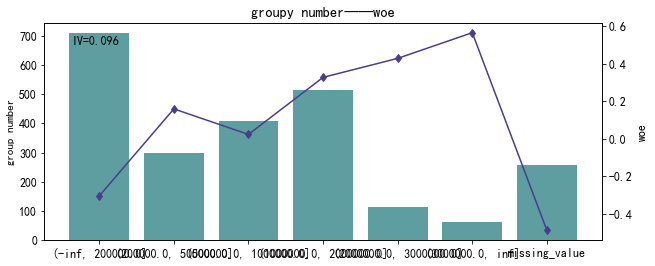

bad_count  good_count  n_group  bad_rate       woe  \
overdue5day_amount_fillna                                                       
(-inf, 200000.0]                 214         495      709  0.301834 -0.303986   
(200000.0, 500000.0]             121         176      297  0.407407  0.159902   
(500000.0, 1000000.0]            153         255      408  0.375000  0.023770   
(1000000.0, 2000000.0]           231         284      515  0.448544  0.328039   
(2000000.0, 3000000.0]            54          60      114  0.473684  0.429235   
(3000000.0, inf]                  32          31       63  0.507937  0.566345   
missing_value                     68         189      257  0.264591 -0.487643   

                                 iv  
overdue5day_amount_fillna            
(-inf, 200000.0]           0.026472  
(200000.0, 500000.0]       0.003275  
(500000.0, 1000000.0]      0.000098  
(1000000.0, 2000000.0]     0.024275  
(2000000.0, 3000000.0]     0.009266  
(3000000.0, inf]           0.008976  
missing_value              0.023872

In [302]:
woe_function(df_train,df,'overdue5day_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

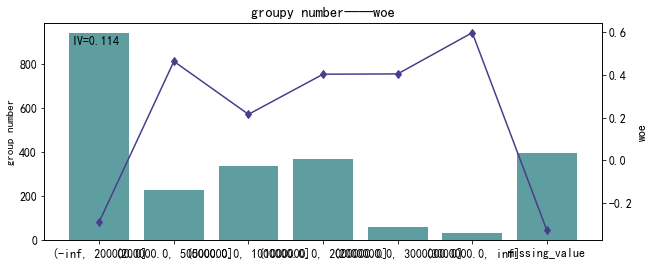

bad_count  good_count  n_group  bad_rate  \
overdue10day_amount_fillna                                             
(-inf, 200000.0]                  287         654      941  0.304995   
(200000.0, 500000.0]              110         118      228  0.482456   
(500000.0, 1000000.0]             141         194      335  0.420896   
(1000000.0, 2000000.0]            172         196      368  0.467391   
(2000000.0, 3000000.0]             29          33       62  0.467742   
(3000000.0, inf]                   16          15       31  0.516129   
missing_value                     118         280      398  0.296482   

                                 woe        iv  
overdue10day_amount_fillna                      
(-inf, 200000.0]           -0.289029  0.031844  
(200000.0, 500000.0]        0.464392  0.021737  
(500000.0, 1000000.0]       0.215498  0.006747  
(1000000.0, 2000000.0]      0.403976  0.026452  
(2000000.0, 3000000.0]      0.405384  0.004488  
(3000000.0, inf]            0.599134  0.004949  
missing_value              -0.329509  0.017383

In [303]:
woe_function(df_train,df,'overdue10day_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

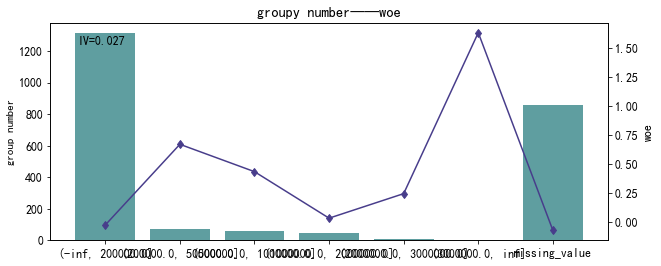

bad_count  good_count  n_group  bad_rate  \
overdue30day_amount_fillna                                             
(-inf, 200000.0]                  478         835     1313  0.364052   
(200000.0, 500000.0]               39          34       73  0.534247   
(500000.0, 1000000.0]              29          32       61  0.475410   
(1000000.0, 2000000.0]             17          28       45  0.377778   
(2000000.0, 3000000.0]              3           4        7  0.428571   
(3000000.0, inf]                    3           1        4  0.750000   
missing_value                     304         556      860  0.353488   

                                 woe        iv  
overdue30day_amount_fillna                      
(-inf, 200000.0]           -0.023225  0.000299  
(200000.0, 500000.0]        0.671797  0.014682  
(500000.0, 1000000.0]       0.436156  0.005121  
(1000000.0, 2000000.0]      0.035605  0.000024  
(2000000.0, 3000000.0]      0.246914  0.000186  
(3000000.0, inf]            1.633208  0.004516  
missing_value              -0.069145  0.001724

In [304]:
woe_function(df_train,df,'overdue30day_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

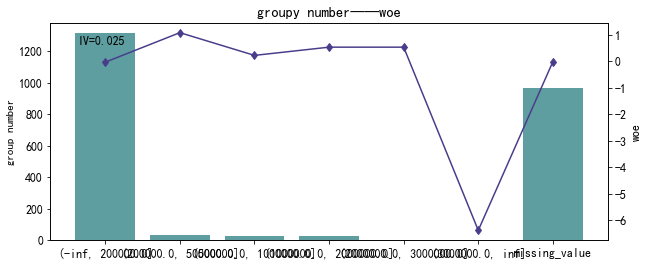

bad_count  good_count   n_group  bad_rate  \
overdue60day_amount_fillna                                              
(-inf, 200000.0]              476.000         838  1314.000  0.362253   
(200000.0, 500000.0]           19.000          11    30.000  0.633333   
(500000.0, 1000000.0]          11.000          15    26.000  0.423077   
(1000000.0, 2000000.0]         12.000          12    24.000  0.500000   
(2000000.0, 3000000.0]          2.000           2     4.000  0.500000   
(3000000.0, inf]                0.001           1     1.001  0.000999   
missing_value                 353.000         611   964.000  0.366183   

                                 woe        iv  
overdue60day_amount_fillna                      
(-inf, 200000.0]           -0.031006  0.000532  
(200000.0, 500000.0]        1.081138  0.015548  
(500000.0, 1000000.0]       0.224440  0.000569  
(1000000.0, 2000000.0]      0.534595  0.003043  
(2000000.0, 3000000.0]      0.534595  0.000507  
(3000000.0, inf]           -6.373161  0.004270  
missing_value              -0.014034  0.000080

In [305]:
woe_function(df_train,df,'overdue60day_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

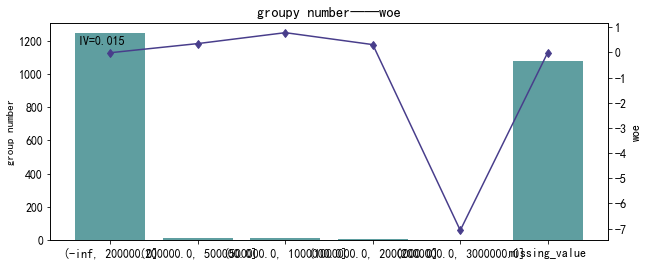

bad_count  good_count   n_group  bad_rate  \
overdue90day_amount_fillna                                              
(-inf, 200000.0]              457.000         788  1245.000  0.367068   
(200000.0, 500000.0]            5.000           6    11.000  0.454545   
(500000.0, 1000000.0]           9.000           7    16.000  0.562500   
(1000000.0, 2000000.0]          4.000           5     9.000  0.444444   
(2000000.0, 3000000.0]          0.001           2     2.001  0.000500   
missing_value                 398.000         682  1080.000  0.368519   

                                 woe        iv  
overdue90day_amount_fillna                      
(-inf, 200000.0]           -0.010220  0.000055  
(200000.0, 500000.0]        0.352273  0.000599  
(500000.0, 1000000.0]       0.785909  0.004410  
(1000000.0, 2000000.0]      0.311451  0.000382  
(2000000.0, 3000000.0]     -7.066308  0.009477  
missing_value              -0.003983  0.000007

In [306]:
woe_function(df_train,df,'overdue90day_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

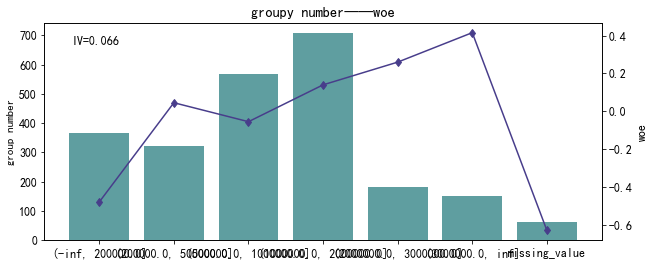

bad_count  good_count  n_group  bad_rate  \
overdue1day_total_amount_fillna                                             
(-inf, 200000.0]                        98         270      368  0.266304   
(200000.0, 500000.0]                   122         199      321  0.380062   
(500000.0, 1000000.0]                  203         366      569  0.356766   
(1000000.0, 2000000.0]                 285         423      708  0.402542   
(2000000.0, 3000000.0]                  79         104      183  0.431694   
(3000000.0, inf]                        71          80      151  0.470199   
missing_value                           15          48       63  0.238095   

                                      woe        iv  
overdue1day_total_amount_fillna                      
(-inf, 200000.0]                -0.478859  0.033018  
(200000.0, 500000.0]             0.045312  0.000281  
(500000.0, 1000000.0]           -0.054832  0.000719  
(1000000.0, 2000000.0]           0.139713  0.005947  
(2000000.0, 3000000.0]           0.259653  0.005373  
(3000000.0, inf]                 0.415249  0.011476  
missing_value                   -0.628555  0.009449

In [307]:
woe_function(df_train,df,'overdue1day_total_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

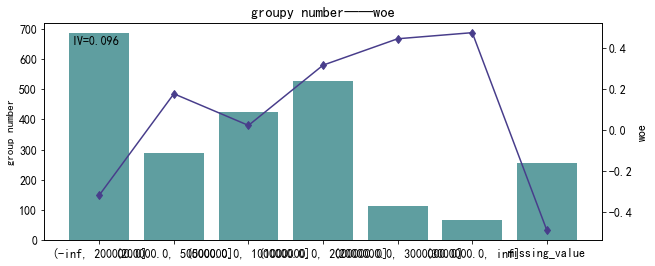

bad_count  good_count  n_group  bad_rate  \
overdue5day_total_amount_fillna                                             
(-inf, 200000.0]                       205         480      685  0.299270   
(200000.0, 500000.0]                   119         170      289  0.411765   
(500000.0, 1000000.0]                  159         265      424  0.375000   
(1000000.0, 2000000.0]                 235         292      527  0.445920   
(2000000.0, 3000000.0]                  54          59      113  0.477876   
(3000000.0, inf]                        33          35       68  0.485294   
missing_value                           68         189      257  0.264591   

                                      woe        iv  
overdue5day_total_amount_fillna                      
(-inf, 200000.0]                -0.316180  0.027611  
(200000.0, 500000.0]             0.177921  0.003953  
(500000.0, 1000000.0]            0.023770  0.000102  
(1000000.0, 2000000.0]           0.317428  0.023240  
(2000000.0, 3000000.0]           0.446042  0.009928  
(3000000.0, inf]                 0.475755  0.006808  
missing_value                   -0.487643  0.023872

In [309]:
woe_function(df_train,df,'overdue5day_total_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

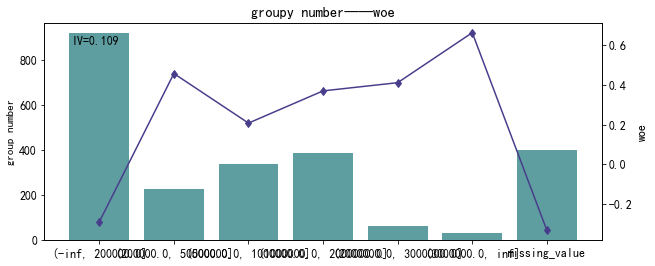

bad_count  good_count  n_group  bad_rate  \
overdue10day_total_amount_fillna                                             
(-inf, 200000.0]                        280         637      917  0.305344   
(200000.0, 500000.0]                    109         118      227  0.480176   
(500000.0, 1000000.0]                   142         197      339  0.418879   
(1000000.0, 2000000.0]                  177         209      386  0.458549   
(2000000.0, 3000000.0]                   30          34       64  0.468750   
(3000000.0, inf]                         17          15       32  0.531250   
missing_value                           118         280      398  0.296482   

                                       woe        iv  
overdue10day_total_amount_fillna                      
(-inf, 200000.0]                 -0.287384  0.030688  
(200000.0, 500000.0]              0.455259  0.020788  
(500000.0, 1000000.0]             0.207219  0.006308  
(1000000.0, 2000000.0]            0.368411  0.023019  
(2000000.0, 3000000.0]            0.409433  0.004727  
(3000000.0, inf]                  0.659759  0.006206  
missing_value                    -0.329509  0.017383

In [310]:
woe_function(df_train,df,'overdue10day_total_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

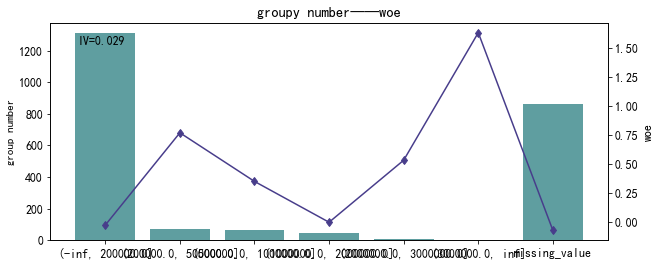

bad_count  good_count  n_group  bad_rate  \
overdue30day_total_amount_fillna                                             
(-inf, 200000.0]                        477         834     1311  0.363844   
(200000.0, 500000.0]                     38          30       68  0.558824   
(500000.0, 1000000.0]                    30          36       66  0.454545   
(1000000.0, 2000000.0]                   17          29       46  0.369565   
(2000000.0, 3000000.0]                    4           4        8  0.500000   
(3000000.0, inf]                          3           1        4  0.750000   
missing_value                           304         556      860  0.353488   

                                       woe            iv  
overdue30day_total_amount_fillna                          
(-inf, 200000.0]                 -0.024121  3.217700e-04  
(200000.0, 500000.0]              0.770985  1.803629e-02  
(500000.0, 1000000.0]             0.352274  3.594321e-03  
(1000000.0, 2000000.0]            0.000513  5.130533e-09  
(2000000.0, 3000000.0]            0.534596  1.014309e-03  
(3000000.0, inf]                  1.633208  4.516286e-03  
missing_value                    -0.069145  1.723768e-03

In [311]:
woe_function(df_train,df,'overdue30day_total_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

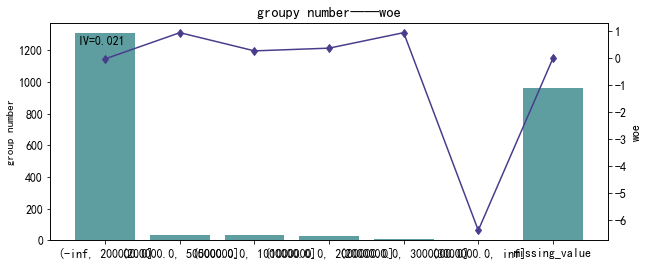

bad_count  good_count   n_group  bad_rate  \
overdue60day_total_amount_fillna                                              
(-inf, 200000.0]                    475.000         834  1309.000  0.362872   
(200000.0, 500000.0]                 18.000          12    30.000  0.600000   
(500000.0, 1000000.0]                13.000          17    30.000  0.433333   
(1000000.0, 2000000.0]               11.000          13    24.000  0.458333   
(2000000.0, 3000000.0]                3.000           2     5.000  0.600000   
(3000000.0, inf]                      0.001           1     1.001  0.000999   
missing_value                       353.000         611   964.000  0.366183   

                                       woe        iv  
overdue60day_total_amount_fillna                      
(-inf, 200000.0]                 -0.028324  0.000443  
(200000.0, 500000.0]              0.940060  0.011812  
(500000.0, 1000000.0]             0.266331  0.000927  
(1000000.0, 2000000.0]            0.367541  0.001424  
(2000000.0, 3000000.0]            0.940060  0.001969  
(3000000.0, inf]                 -6.373161  0.004270  
missing_value                    -0.014034  0.000080

In [312]:
woe_function(df_train,df,'overdue60day_total_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

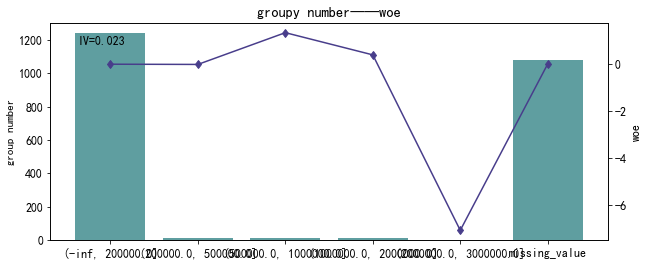

bad_count  good_count   n_group  bad_rate  \
overdue90day_total_amount_fillna                                              
(-inf, 200000.0]                    454.000         787  1241.000  0.365834   
(200000.0, 500000.0]                  4.000           7    11.000  0.363636   
(500000.0, 1000000.0]                11.000           5    16.000  0.687500   
(1000000.0, 2000000.0]                6.000           7    13.000  0.461538   
(2000000.0, 3000000.0]                0.001           2     2.001  0.000500   
missing_value                       398.000         682  1080.000  0.368519   

                                       woe        iv  
overdue90day_total_amount_fillna                      
(-inf, 200000.0]                 -0.015536  0.000127  
(200000.0, 500000.0]             -0.025021  0.000003  
(500000.0, 1000000.0]             1.323052  0.012231  
(1000000.0, 2000000.0]            0.380444  0.000827  
(2000000.0, 3000000.0]           -7.066308  0.009477  
missing_value                    -0.003983  0.000007

In [313]:
woe_function(df_train,df,'overdue90day_total_amount',q=[200000,500000,1000000,2000000,3000000],woe_type='c')

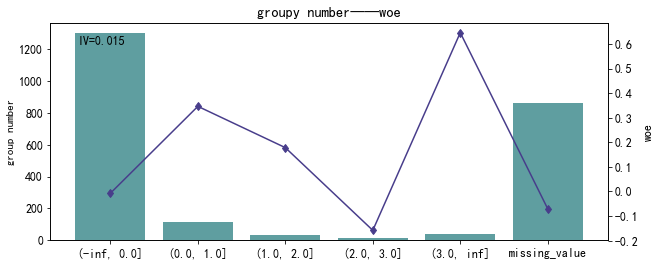

bad_count  good_count  n_group  \
overdue_30day_times_last_12months_fillna                                   
(-inf, 0.0]                                     478         822     1300   
(0.0, 1.0]                                       53          64      117   
(1.0, 2.0]                                       14          20       34   
(2.0, 3.0]                                        5          10       15   
(3.0, inf]                                       19          17       36   
missing_value                                   304         557      861   

                                          bad_rate       woe        iv  
overdue_30day_times_last_12months_fillna                                
(-inf, 0.0]                               0.367692 -0.007534  0.000031  
(0.0, 1.0]                                0.452991  0.346005  0.006144  
(1.0, 2.0]                                0.411765  0.177921  0.000465  
(2.0, 3.0]                                0.333333 -0.158551  0.000156  
(3.0, inf]                                0.527778  0.645821  0.006687  
missing_value                             0.353078 -0.070942  0.001816

In [315]:
woe_function(df_train,df,'overdue_30day_times_last_12months',q=[0,1,2,3],woe_type='c')

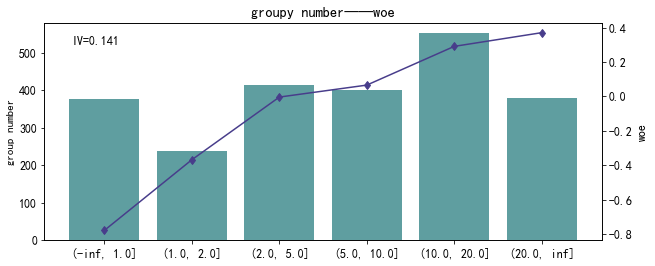

bad_count  good_count  n_group  bad_rate  \
onway_overdue_days_max_fillna                                             
(-inf, 1.0]                           80         297      377  0.212202   
(1.0, 2.0]                            69         170      239  0.288703   
(2.0, 5.0]                           153         262      415  0.368675   
(5.0, 10.0]                          154         246      400  0.385000   
(10.0, 20.0]                         243         310      553  0.439421   
(20.0, inf]                          174         205      379  0.459103   

                                    woe        iv  
onway_overdue_days_max_fillna                      
(-inf, 1.0]                   -0.777110  0.083688  
(1.0, 2.0]                    -0.367096  0.012869  
(2.0, 5.0]                    -0.003311  0.000002  
(5.0, 10.0]                    0.066217  0.000748  
(10.0, 20.0]                   0.291085  0.020462  
(20.0, inf]                    0.370641  0.022879

In [326]:
woe_function(df_train,df,'onway_overdue_days_max',q=[1,2,5,10,20],woe_type='c')

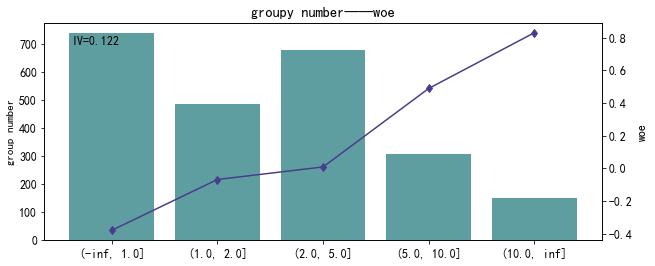

bad_count  good_count  n_group  bad_rate       woe  \
onway_loan_times_fillna                                                       
(-inf, 1.0]                    212         528      740  0.286486 -0.377914   
(1.0, 2.0]                     172         314      486  0.353909 -0.067303   
(2.0, 5.0]                     252         426      678  0.371681  0.009586   
(5.0, 10.0]                    151         158      309  0.488673  0.489281   
(10.0, inf]                     86          64      150  0.573333  0.830060   

                               iv  
onway_loan_times_fillna            
(-inf, 1.0]              0.042146  
(1.0, 2.0]               0.000923  
(2.0, 5.0]               0.000026  
(5.0, 10.0]              0.032746  
(10.0, inf]              0.046116

In [328]:
woe_function(df_train,df,'onway_loan_times',q=[1,2,5,10],woe_type='c')

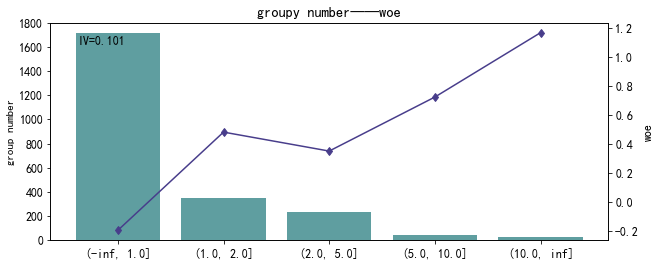

bad_count  good_count  n_group  bad_rate  \
onway_overdue_times_fillna                                             
(-inf, 1.0]                       557        1156     1713  0.325161   
(1.0, 2.0]                        171         180      351  0.487179   
(2.0, 5.0]                        105         126      231  0.454545   
(5.0, 10.0]                        23          19       42  0.547619   
(10.0, inf]                        17           9       26  0.653846   

                                 woe        iv  
onway_overdue_times_fillna                      
(-inf, 1.0]                -0.195560  0.026950  
(1.0, 2.0]                  0.483303  0.036282  
(2.0, 5.0]                  0.352274  0.012580  
(5.0, 10.0]                 0.725651  0.009865  
(10.0, inf]                 1.170585  0.015724

In [329]:
woe_function(df_train,df,'onway_overdue_times',q=[1,2,5,10],woe_type='c')

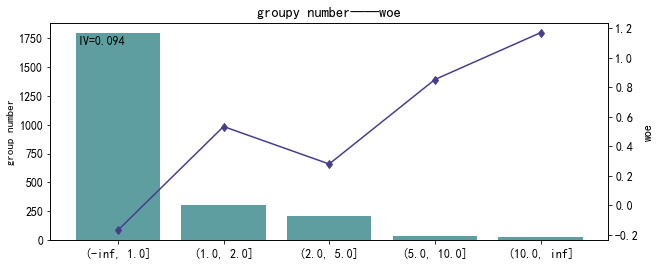

bad_count  good_count  n_group  bad_rate  \
onway_overdue1day_times_fillna                                             
(-inf, 1.0]                           593        1198     1791  0.331100   
(1.0, 2.0]                            151         151      302  0.500000   
(2.0, 5.0]                             90         116      206  0.436893   
(5.0, 10.0]                            22          16       38  0.578947   
(10.0, inf]                            17           9       26  0.653846   

                                     woe        iv  
onway_overdue1day_times_fillna                      
(-inf, 1.0]                    -0.168619  0.021037  
(1.0, 2.0]                      0.534596  0.038290  
(2.0, 5.0]                      0.280815  0.007088  
(5.0, 10.0]                     0.853050  0.012337  
(10.0, inf]                     1.170585  0.015724

In [330]:
woe_function(df_train,df,'onway_overdue1day_times',q=[1,2,5,10],woe_type='c')

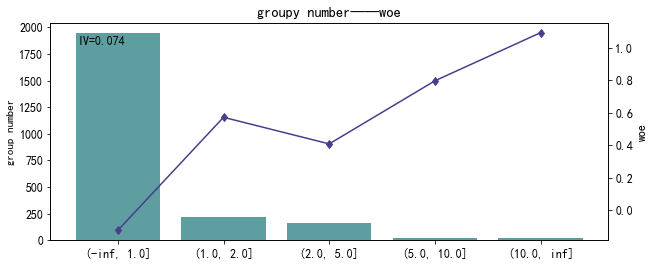

bad_count  good_count  n_group  bad_rate  \
onway_overdue5day_times_fillna                                             
(-inf, 1.0]                           663        1283     1946  0.340699   
(1.0, 2.0]                            109         105      214  0.509346   
(2.0, 5.0]                             74          84      158  0.468354   
(5.0, 10.0]                            13          10       23  0.565217   
(10.0, inf]                            14           8       22  0.636364   

                                     woe        iv  
onway_overdue5day_times_fillna                      
(-inf, 1.0]                    -0.125586  0.012762  
(1.0, 2.0]                      0.571983  0.031108  
(2.0, 5.0]                      0.407844  0.011578  
(5.0, 10.0]                     0.796960  0.006519  
(10.0, inf]                     1.094212  0.011673

In [331]:
woe_function(df_train,df,'onway_overdue5day_times',q=[1,2,5,10],woe_type='c')

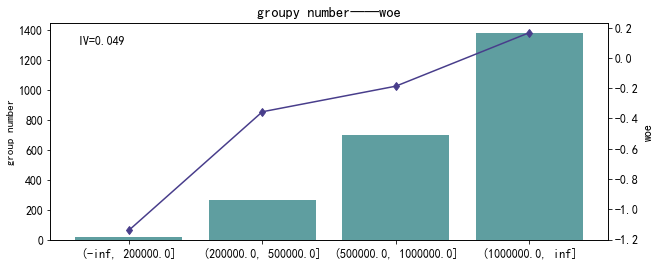

bad_count  good_count  n_group  bad_rate       woe  \
onway_amount_fillna                                                         
(-inf, 200000.0]               3          16       19  0.157895 -1.139381   
(200000.0, 500000.0]          78         190      268  0.291045 -0.355719   
(500000.0, 1000000.0]        229         471      700  0.327143 -0.186540   
(1000000.0, inf]             563         813     1376  0.409157  0.167144   

                             iv  
onway_amount_fillna              
(-inf, 200000.0]       0.008320  
(200000.0, 500000.0]   0.013578  
(500000.0, 1000000.0]  0.010035  
(1000000.0, inf]       0.016592

In [335]:
woe_function(df_train,df,'onway_amount',q=[200000,500000,1000000],woe_type='c')

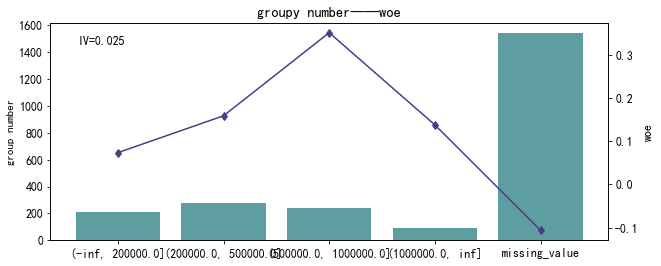

bad_count  good_count  n_group  bad_rate  \
onway_30day_toenddate_amount_fillna                                             
(-inf, 200000.0]                            82         130      212  0.386792   
(200000.0, 500000.0]                       112         163      275  0.407273   
(500000.0, 1000000.0]                      110         132      242  0.454545   
(1000000.0, inf]                            37          55       92  0.402174   
missing_value                              532        1010     1542  0.345006   

                                          woe        iv  
onway_30day_toenddate_amount_fillna                      
(-inf, 200000.0]                     0.073781  0.000493  
(200000.0, 500000.0]                 0.159345  0.003011  
(500000.0, 1000000.0]                0.352274  0.013179  
(1000000.0, inf]                     0.138181  0.000756  
missing_value                       -0.106466  0.007289

In [336]:
woe_function(df_train,df,'onway_30day_toenddate_amount',q=[200000,500000,1000000],woe_type='c')

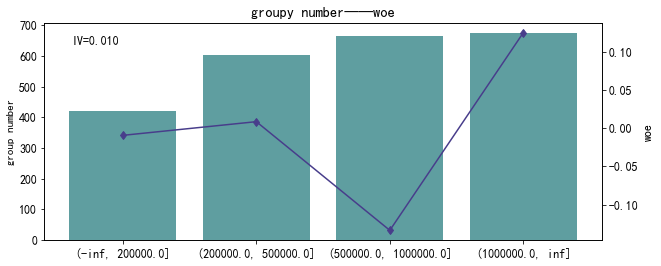

bad_count  good_count  n_group  bad_rate  \
onway_overdue_amount_fillna                                             
(-inf, 200000.0]                   155         267      422  0.367299   
(200000.0, 500000.0]               224         379      603  0.371476   
(500000.0, 1000000.0]              225         439      664  0.338855   
(1000000.0, inf]                   269         405      674  0.399110   

                                  woe        iv  
onway_overdue_amount_fillna                      
(-inf, 200000.0]            -0.009228  0.000015  
(200000.0, 500000.0]         0.008706  0.000019  
(500000.0, 1000000.0]       -0.133803  0.004937  
(1000000.0, inf]             0.125420  0.004555

In [337]:
woe_function(df_train,df,'onway_overdue_amount',q=[200000,500000,1000000],woe_type='c')

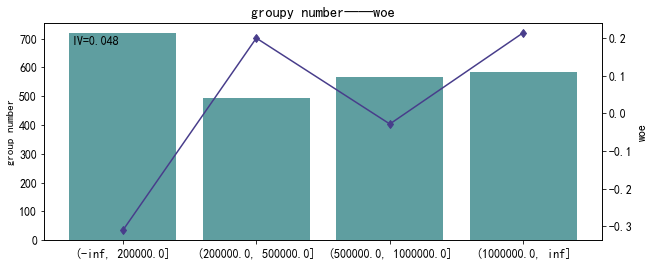

bad_count  good_count  n_group  bad_rate  \
onway_overdue1day_amount_fillna                                             
(-inf, 200000.0]                       216         503      719  0.300417   
(200000.0, 500000.0]                   206         288      494  0.417004   
(500000.0, 1000000.0]                  205         360      565  0.362832   
(1000000.0, inf]                       246         339      585  0.420513   

                                      woe        iv  
onway_overdue1day_amount_fillna                      
(-inf, 200000.0]                -0.310716  0.028015  
(200000.0, 500000.0]             0.199512  0.008515  
(500000.0, 1000000.0]           -0.028498  0.000193  
(1000000.0, inf]                 0.213927  0.011610

In [338]:
woe_function(df_train,df,'onway_overdue1day_amount',q=[200000,500000,1000000],woe_type='c')

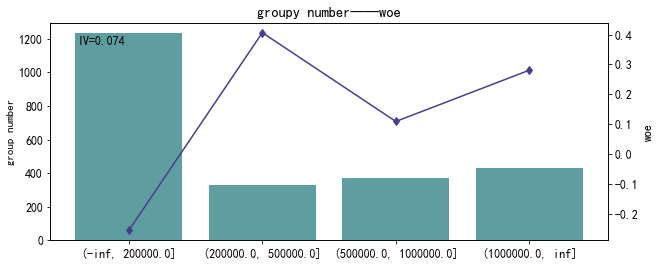

bad_count  good_count  n_group  bad_rate  \
onway_overdue5day_amount_fillna                                             
(-inf, 200000.0]                       385         849     1234  0.311994   
(200000.0, 500000.0]                   154         175      329  0.468085   
(500000.0, 1000000.0]                  147         225      372  0.395161   
(1000000.0, inf]                       187         241      428  0.436916   

                                      woe        iv  
onway_overdue5day_amount_fillna                      
(-inf, 200000.0]                -0.256220  0.032999  
(200000.0, 500000.0]             0.406762  0.023980  
(500000.0, 1000000.0]            0.108928  0.001893  
(1000000.0, inf]                 0.280908  0.014736

In [339]:
woe_function(df_train,df,'onway_overdue5day_amount',q=[200000,500000,1000000],woe_type='c')

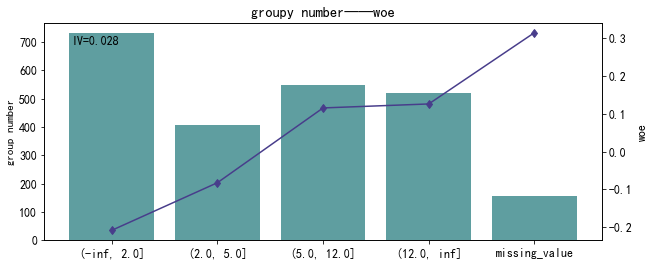

bad_count  good_count  n_group  bad_rate       woe  \
last_overdue_days_fillna                                                       
(-inf, 2.0]                     236         496      732  0.322404 -0.208148   
(2.0, 5.0]                      143         265      408  0.350490 -0.082289   
(5.0, 12.0]                     217         330      547  0.396709  0.115401   
(12.0, inf]                     208         313      521  0.399232  0.125931   
missing_value                    69          86      155  0.445161  0.314355   

                                iv  
last_overdue_days_fillna            
(-inf, 2.0]               0.013020  
(2.0, 5.0]                0.001156  
(5.0, 12.0]               0.003126  
(12.0, inf]               0.003550  
missing_value             0.006702

In [343]:
woe_function(df_train,df,'last_overdue_days',q=[2,5,12],woe_type='c')

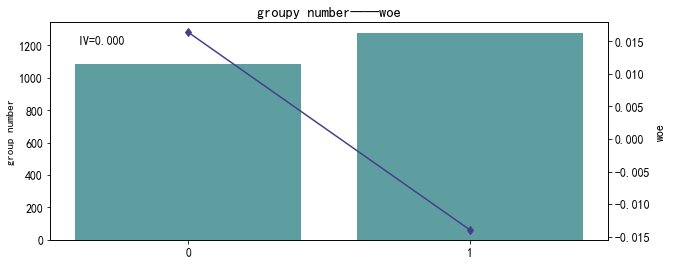

bad_count  good_count  n_group  bad_rate      woe  \
first_is_overdue_fillna                                                      
0                              405         680     1085  0.373272  0.01639   
1                              468         810     1278  0.366197 -0.01397   

                               iv  
first_is_overdue_fillna            
0                        0.000124  
1                        0.000105

In [344]:
woe_function(df_train,df,'first_is_overdue')

d:\users\zhangzerong\appdata\local\programs\python\python36\lib\site-packages\pandas\core\reshape\merge.py:722: RuntimeWarning: unorderable types: Interval() < str(), sort order is undefined for incomparable objects
  sort=self.sort)


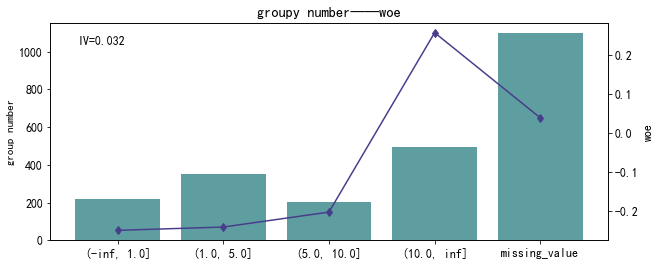

bad_count  good_count  n_group  bad_rate       woe  \
first_overdue_days_fillna                                                       
(-inf, 1.0]                       68         149      217  0.313364 -0.249843   
(1.0, 5.0]                       110         239      349  0.315186 -0.241387   
(5.0, 10.0]                       66         138      204  0.323529 -0.203003   
(10.0, inf]                      213         281      494  0.431174  0.257533   
missing_value                    416         683     1099  0.378526  0.038786   

                                 iv  
first_overdue_days_fillna            
(-inf, 1.0]                0.005523  
(1.0, 5.0]                 0.008304  
(5.0, 10.0]                0.003454  
(10.0, inf]                0.014266  
missing_value              0.000703

In [347]:
woe_function(df_train,df,'first_overdue_days',q=[1,5,10],woe_type='c')

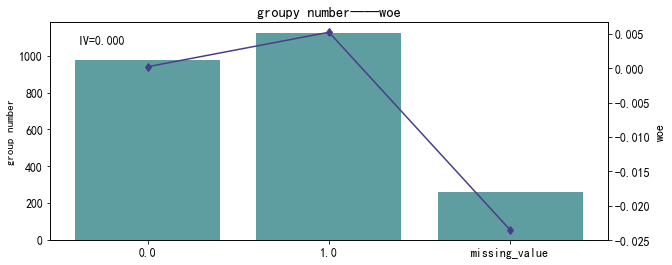

bad_count  good_count  n_group  bad_rate  \
first_1term_is_overdue_fillna                                             
0.0                                  361         616      977  0.369498   
1.0                                  417         708     1125  0.370667   
missing_value                         95         166      261  0.363985   

                                    woe            iv  
first_1term_is_overdue_fillna                          
0.0                            0.000227  2.127526e-08  
1.0                            0.005238  1.307107e-05  
missing_value                 -0.023515  6.088601e-05

In [348]:
woe_function(df_train,df,'first_1term_is_overdue')

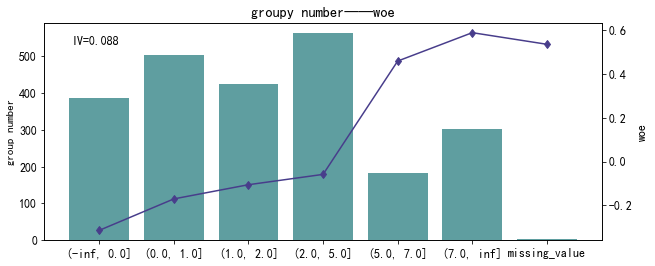

bad_count  good_count  n_group  bad_rate       woe  \
overdue_1st_terms_fillna                                                       
(-inf, 0.0]                     116         271      387  0.299742 -0.313933   
(0.0, 1.0]                      166         336      502  0.330677 -0.170528   
(1.0, 2.0]                      146         277      423  0.345154 -0.105815   
(2.0, 5.0]                      200         362      562  0.355872 -0.058731   
(5.0, 7.0]                       88          95      183  0.480874  0.458056   
(7.0, inf]                      155         147      302  0.513245  0.587588   
missing_value                     2           2        4  0.500000  0.534596   

                                iv  
overdue_1st_terms_fillna            
(-inf, 0.0]               0.015384  
(0.0, 1.0]                0.006029  
(1.0, 2.0]                0.001975  
(2.0, 5.0]                0.000814  
(5.0, 7.0]                0.016968  
(7.0, inf]                0.046355  
missing_value             0.000507

In [352]:
woe_function(df_train,df,'overdue_1st_terms',woe_type='c',q=[0,1,2,5,7])

d:\users\zhangzerong\appdata\local\programs\python\python36\lib\site-packages\pandas\core\reshape\merge.py:722: RuntimeWarning: unorderable types: Interval() < str(), sort order is undefined for incomparable objects
  sort=self.sort)


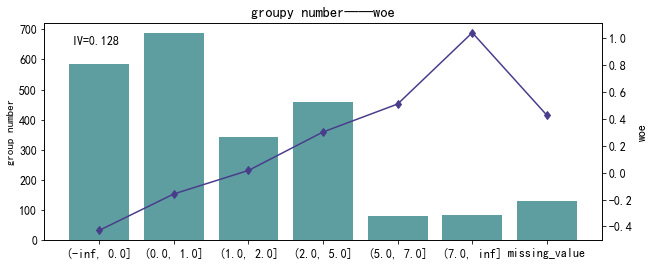

bad_count  good_count  n_group  \
overdue_1st_terms_last_3months_fillna                                   
(-inf, 0.0]                                  161         422      583   
(0.0, 1.0]                                   229         458      687   
(1.0, 2.0]                                   128         215      343   
(2.0, 5.0]                                   202         255      457   
(5.0, 7.0]                                    39          40       79   
(7.0, inf]                                    53          32       85   
missing_value                                 61          68      129   

                                       bad_rate       woe        iv  
overdue_1st_terms_last_3months_fillna                                
(-inf, 0.0]                            0.276158 -0.429005  0.042386  
(0.0, 1.0]                             0.333333 -0.158551  0.007146  
(1.0, 2.0]                             0.373178  0.015988  0.000037  
(2.0, 5.0]                             0.442013  0.301600  0.018170  
(5.0, 7.0]                             0.493671  0.509278  0.009079  
(7.0, inf]                             0.623529  1.039152  0.040770  
missing_value                          0.472868  0.425962  0.010324

In [353]:
woe_function(df_train,df,'overdue_1st_terms_last_3months',woe_type='c',q=[0,1,2,5,7])

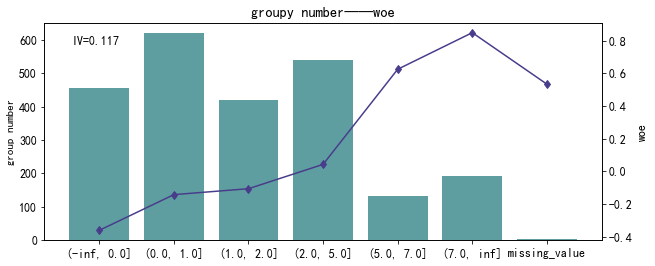

bad_count  good_count  n_group  \
overdue_1st_terms_last_6months_fillna                                   
(-inf, 0.0]                                  132         323      455   
(0.0, 1.0]                                   209         411      620   
(1.0, 2.0]                                   145         275      420   
(2.0, 5.0]                                   205         335      540   
(5.0, 7.0]                                    69          63      132   
(7.0, inf]                                   111          81      192   
missing_value                                  2           2        4   

                                       bad_rate       woe        iv  
overdue_1st_terms_last_6months_fillna                                
(-inf, 0.0]                            0.290110 -0.360255  0.023624  
(0.0, 1.0]                             0.337097 -0.141663  0.005161  
(1.0, 2.0]                             0.345238 -0.105442  0.001947  
(2.0, 5.0]                             0.379630  0.043475  0.000434  
(5.0, 7.0]                             0.522727  0.625568  0.022993  
(7.0, inf]                             0.578125  0.849677  0.061844  
missing_value                          0.500000  0.534596  0.000507

In [354]:
woe_function(df_train,df,'overdue_1st_terms_last_6months',woe_type='c',q=[0,1,2,5,7])

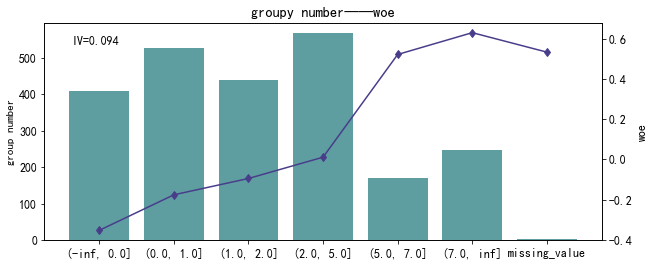

bad_count  good_count  n_group  \
overdue_1st_terms_last_9months_fillna                                   
(-inf, 0.0]                                  119         289      408   
(0.0, 1.0]                                   173         352      525   
(1.0, 2.0]                                   153         287      440   
(2.0, 5.0]                                   211         356      567   
(5.0, 7.0]                                    85          86      171   
(7.0, inf]                                   130         118      248   
missing_value                                  2           2        4   

                                       bad_rate       woe        iv  
overdue_1st_terms_last_9months_fillna                                
(-inf, 0.0]                            0.291667 -0.352707  0.020333  
(0.0, 1.0]                             0.329524 -0.175744  0.006691  
(1.0, 2.0]                             0.347727 -0.094448  0.001640  
(2.0, 5.0]                             0.372134  0.011523  0.000032  
(5.0, 7.0]                             0.497076  0.522900  0.020732  
(7.0, inf]                             0.524194  0.631446  0.044023  
missing_value                          0.500000  0.534596  0.000507

In [355]:
woe_function(df_train,df,'overdue_1st_terms_last_9months',woe_type='c',q=[0,1,2,5,7])

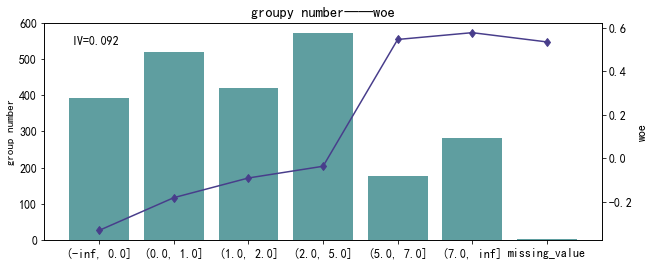

bad_count  good_count  n_group  \
overdue_1st_terms_last_12months_fillna                                   
(-inf, 0.0]                                   116         276      392   
(0.0, 1.0]                                    170         348      518   
(1.0, 2.0]                                    146         273      419   
(2.0, 5.0]                                    206         365      571   
(5.0, 7.0]                                     89          88      177   
(7.0, inf]                                    144         138      282   
missing_value                                   2           2        4   

                                        bad_rate       woe        iv  
overdue_1st_terms_last_12months_fillna                                
(-inf, 0.0]                             0.295918 -0.332215  0.017395  
(0.0, 1.0]                              0.328185 -0.181808  0.007059  
(1.0, 2.0]                              0.348449 -0.091269  0.001459  
(2.0, 5.0]                              0.360771 -0.037425  0.000337  
(5.0, 7.0]                              0.502825  0.545895  0.023412  
(7.0, inf]                              0.510638  0.577155  0.041746  
missing_value                           0.500000  0.534596  0.000507

In [356]:
woe_function(df_train,df,'overdue_1st_terms_last_12months',woe_type='c',q=[0,1,2,5,7])

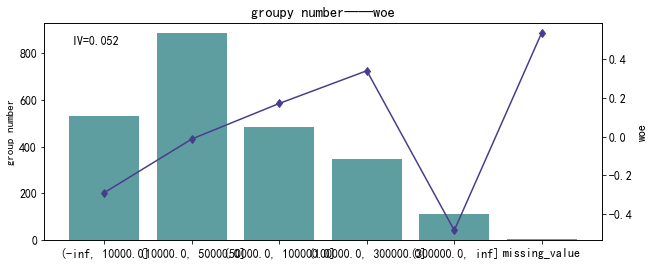

bad_count  good_count  n_group  bad_rate  \
overdue_1st_term_amount_fillna                                             
(-inf, 10000.0]                       162         369      531  0.305085   
(10000.0, 50000.0]                    324         560      884  0.366516   
(50000.0, 100000.0]                   198         285      483  0.409938   
(100000.0, 300000.0]                  157         191      348  0.451149   
(300000.0, inf]                        30          83      113  0.265487   
missing_value                           2           2        4  0.500000   

                                     woe        iv  
overdue_1st_term_amount_fillna                      
(-inf, 10000.0]                -0.288604  0.017918  
(10000.0, 50000.0]             -0.012597  0.000059  
(50000.0, 100000.0]             0.170374  0.006053  
(100000.0, 300000.0]            0.338568  0.017488  
(300000.0, inf]                -0.483047  0.010308  
missing_value                   0.534596  0.000507

In [357]:
woe_function(df_train,df,'overdue_1st_term_amount',woe_type='c',q=[10000,50000,100000,300000])

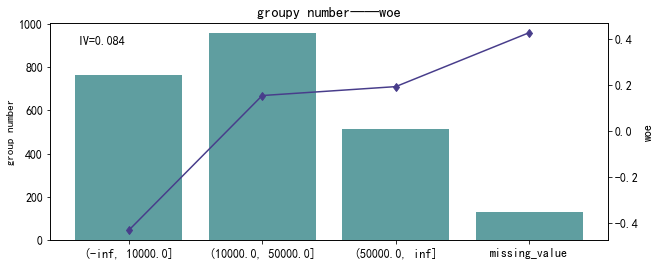

bad_count  good_count  n_group  \
overdue_1st_term_amount_last_3months_fillna                                   
(-inf, 10000.0]                                    211         554      765   
(10000.0, 50000.0]                                 388         568      956   
(50000.0, inf]                                     213         300      513   
missing_value                                       61          68      129   

                                             bad_rate       woe        iv  
overdue_1st_term_amount_last_3months_fillna                                
(-inf, 10000.0]                              0.275817 -0.430711  0.056043  
(10000.0, 50000.0]                           0.405858  0.153480  0.009706  
(50000.0, inf]                               0.415205  0.192106  0.008192  
missing_value                                0.472868  0.425962  0.010324

In [359]:
woe_function(df_train,df,'overdue_1st_term_amount_last_3months',woe_type='c',q=[10000,50000])

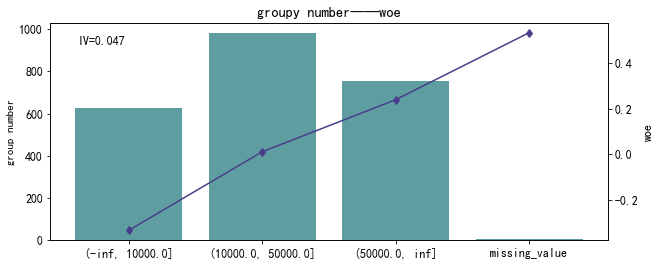

bad_count  good_count  n_group  \
overdue_1st_term_amount_last_6months_fillna                                   
(-inf, 10000.0]                                    185         441      626   
(10000.0, 50000.0]                                 365         616      981   
(50000.0, inf]                                     321         431      752   
missing_value                                        2           2        4   

                                             bad_rate       woe        iv  
overdue_1st_term_amount_last_6months_fillna                                
(-inf, 10000.0]                              0.295527 -0.334093  0.028084  
(10000.0, 50000.0]                           0.372069  0.011246  0.000053  
(50000.0, inf]                               0.426862  0.239929  0.018819  
missing_value                                0.500000  0.534596  0.000507

In [360]:
woe_function(df_train,df,'overdue_1st_term_amount_last_6months',woe_type='c',q=[10000,50000])

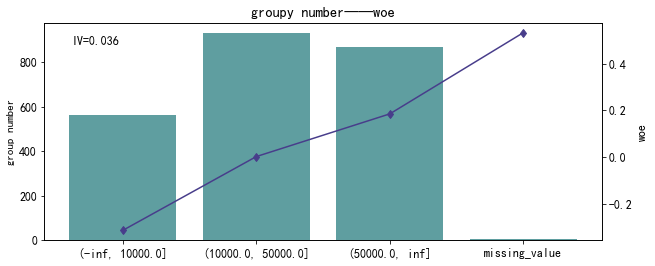

bad_count  good_count  n_group  \
overdue_1st_term_amount_last_9months_fillna                                   
(-inf, 10000.0]                                    168         393      561   
(10000.0, 50000.0]                                 344         586      930   
(50000.0, inf]                                     359         509      868   
missing_value                                        2           2        4   

                                             bad_rate       woe        iv  
overdue_1st_term_amount_last_9months_fillna                                
(-inf, 10000.0]                              0.299465 -0.315250  0.022483  
(10000.0, 50000.0]                           0.369892  0.001918  0.000001  
(50000.0, inf]                               0.413594  0.185470  0.012911  
missing_value                                0.500000  0.534596  0.000507

In [361]:
woe_function(df_train,df,'overdue_1st_term_amount_last_9months',woe_type='c',q=[10000,50000])

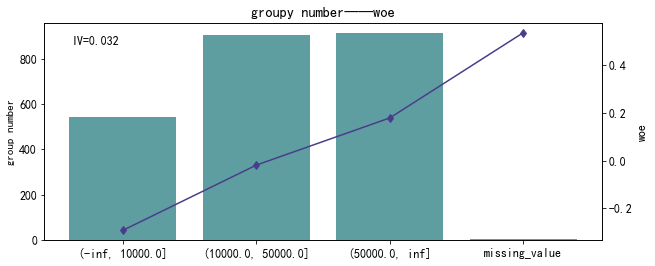

bad_count  good_count  n_group  \
overdue_1st_term_amount_last_12months_fillna                                   
(-inf, 10000.0]                                     165         377      542   
(10000.0, 50000.0]                                  330         574      904   
(50000.0, inf]                                      376         537      913   
missing_value                                         2           2        4   

                                              bad_rate       woe        iv  
overdue_1st_term_amount_last_12months_fillna                                
(-inf, 10000.0]                               0.304428 -0.291704  0.018674  
(10000.0, 50000.0]                            0.365044 -0.018941  0.000137  
(50000.0, inf]                                0.411829  0.178187  0.012526  
missing_value                                 0.500000  0.534596  0.000507

In [362]:
woe_function(df_train,df,'overdue_1st_term_amount_last_12months',woe_type='c',q=[10000,50000])

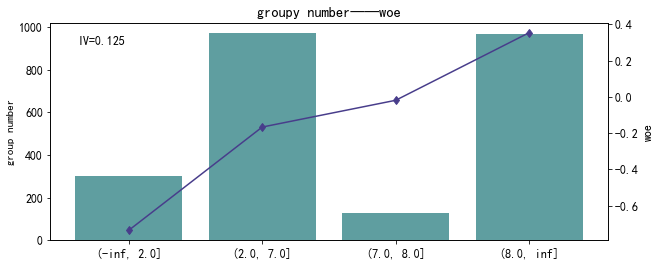

bad_count  good_count  n_group  bad_rate       woe  \
overdue_terms_fillna                                                       
(-inf, 2.0]                  66         235      301  0.219269 -0.735335   
(2.0, 7.0]                  322         649      971  0.331617 -0.166285   
(7.0, 8.0]                   46          80      126  0.365079 -0.018789   
(8.0, inf]                  439         526      965  0.454922  0.353794   

                            iv  
overdue_terms_fillna            
(-inf, 2.0]           0.060383  
(2.0, 7.0]            0.011096  
(7.0, 8.0]            0.000019  
(8.0, inf]            0.053014

In [368]:
woe_function(df_train,df,'overdue_terms',woe_type='c',q=[2,7,8])

In [3]:
woe_function(df_train,df,'onway_overdue_terms',woe_type='c',q=[1,2,3,4])

NameError: name 'woe_function' is not defined

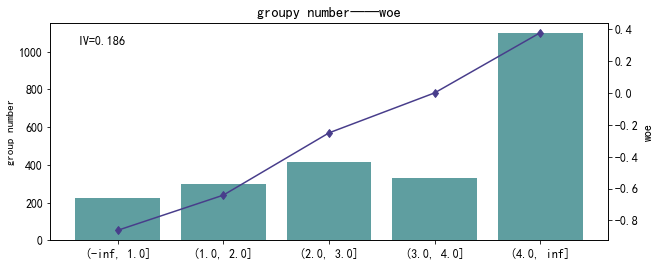

bad_count  good_count  n_group  bad_rate  \
overdue_terms_last_3months_fillna                                             
(-inf, 1.0]                               44         178      222  0.198198   
(1.0, 2.0]                                70         227      297  0.235690   
(2.0, 3.0]                               130         285      415  0.313253   
(3.0, 4.0]                               122         208      330  0.369697   
(4.0, inf]                               507         592     1099  0.461328   

                                        woe            iv  
overdue_terms_last_3months_fillna                          
(-inf, 1.0]                       -0.862998  5.960052e-02  
(1.0, 2.0]                        -0.641859  4.632021e-02  
(2.0, 3.0]                        -0.250359  1.060605e-02  
(3.0, 4.0]                         0.001079  1.625548e-07  
(4.0, inf]                         0.379600  6.963408e-02

In [404]:
woe_function(df_train,df,'overdue_terms_last_3months',woe_type='c',q=[1,2,3,4])

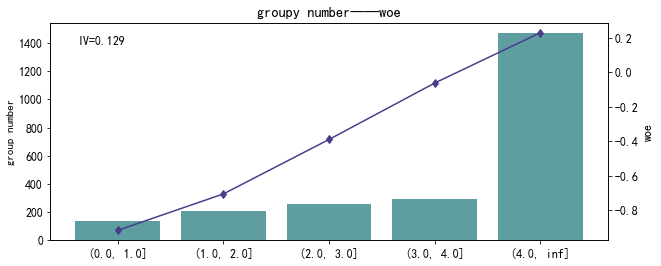

bad_count  good_count  n_group  bad_rate  \
overdue_terms_last_6months_fillna                                             
(0.0, 1.0]                                26         111      137  0.189781   
(1.0, 2.0]                                46         159      205  0.224390   
(2.0, 3.0]                                73         184      257  0.284047   
(3.0, 4.0]                               104         189      293  0.354949   
(4.0, inf]                               624         847     1471  0.424201   

                                        woe        iv  
overdue_terms_last_6months_fillna                      
(0.0, 1.0]                        -0.916838  0.040996  
(1.0, 2.0]                        -0.705667  0.038120  
(2.0, 3.0]                        -0.389880  0.015545  
(3.0, 4.0]                        -0.062760  0.000484  
(4.0, inf]                         0.229046  0.033514

In [375]:
woe_function(df_train,df,'overdue_terms_last_6months',woe_type='c',q=[0,1,2,3,4])

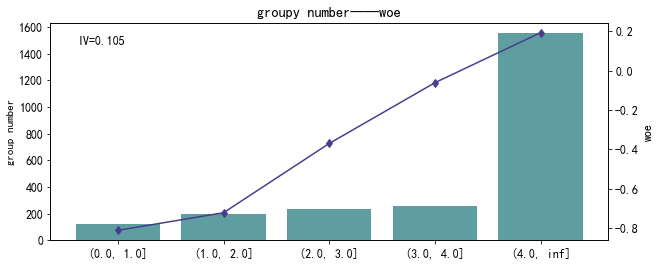

bad_count  good_count  n_group  bad_rate  \
overdue_terms_last_9months_fillna                                             
(0.0, 1.0]                                25          96      121  0.206612   
(1.0, 2.0]                                43         151      194  0.221649   
(2.0, 3.0]                                68         168      236  0.288136   
(3.0, 4.0]                                92         167      259  0.355212   
(4.0, inf]                               645         908     1553  0.415325   

                                        woe        iv  
overdue_terms_last_9months_fillna                      
(0.0, 1.0]                        -0.810877  0.029023  
(1.0, 2.0]                        -0.721484  0.037580  
(2.0, 3.0]                        -0.369860  0.012893  
(3.0, 4.0]                        -0.061609  0.000413  
(4.0, inf]                         0.192602  0.024930

In [376]:
woe_function(df_train,df,'overdue_terms_last_9months',woe_type='c',q=[0,1,2,3,4])

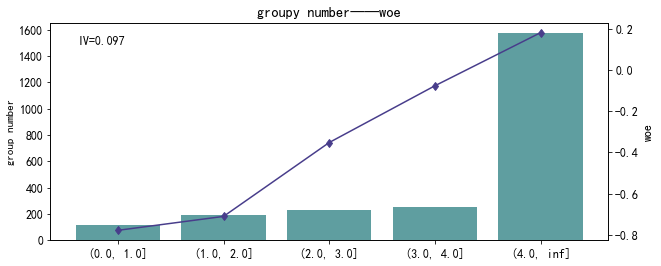

bad_count  good_count  n_group  bad_rate  \
overdue_terms_last_12months_fillna                                             
(0.0, 1.0]                                 25          93      118  0.211864   
(1.0, 2.0]                                 42         146      188  0.223404   
(2.0, 3.0]                                 68         165      233  0.291845   
(3.0, 4.0]                                 88         162      250  0.352000   
(4.0, inf]                                650         924     1574  0.412961   

                                         woe        iv  
overdue_terms_last_12months_fillna                      
(0.0, 1.0]                         -0.779128  0.026318  
(1.0, 2.0]                         -0.711341  0.035479  
(2.0, 3.0]                         -0.351842  0.011557  
(3.0, 4.0]                         -0.075664  0.000599  
(4.0, inf]                          0.182856  0.022752

In [377]:
woe_function(df_train,df,'overdue_terms_last_12months',woe_type='c',q=[0,1,2,3,4])

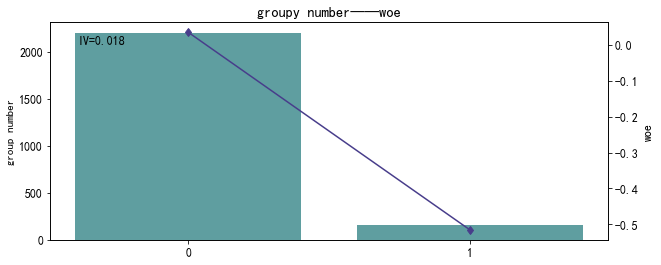

bad_count  good_count  n_group  bad_rate       woe  \
spouse_is_client_fillna                                                       
0                              831        1370     2201  0.377556  0.034660   
1                               42         120      162  0.259259 -0.515226   

                               iv  
spouse_is_client_fillna            
0                        0.001124  
1                        0.016707

In [378]:
woe_function(df_train,df,'spouse_is_client')

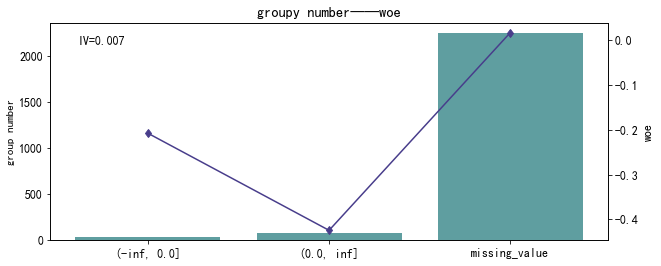

bad_count  good_count  n_group  bad_rate  \
spouse_overdue_times_fillna                                             
(-inf, 0.0]                         10          21       31  0.322581   
(0.0, inf]                          23          60       83  0.277108   
missing_value                      840        1409     2249  0.373499   

                                  woe        iv  
spouse_overdue_times_fillna                      
(-inf, 0.0]                 -0.207342  0.000547  
(0.0, inf]                  -0.424255  0.005907  
missing_value                0.017362  0.000288

In [381]:
woe_function(df_train,df,'spouse_overdue_times',q=[0],woe_type='c')

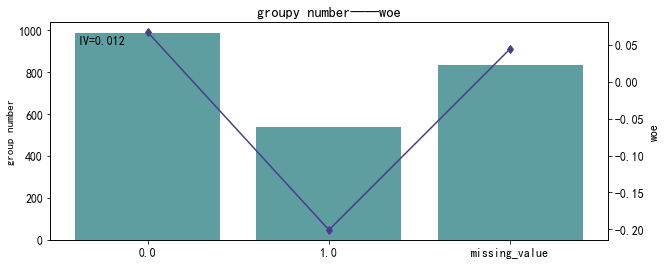

bad_count  good_count  n_group  bad_rate       woe  \
contact_is_client_fillna                                                       
0.0                             381         608      989  0.385238  0.067220   
1.0                             174         363      537  0.324022 -0.200752   
missing_value                   318         519      837  0.379928  0.044743   

                                iv  
contact_is_client_fillna            
0.0                       0.001907  
1.0                       0.008896  
missing_value             0.000713

In [382]:
woe_function(df_train,df,'contact_is_client')

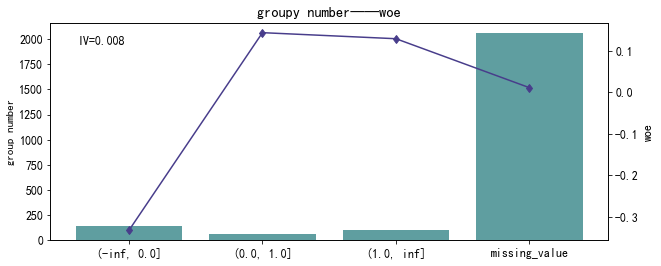

bad_count  good_count  n_group  bad_rate  \
contact_overdue_times_fillna                                             
(-inf, 0.0]                          42         100      142  0.295775   
(0.0, 1.0]                           23          34       57  0.403509   
(1.0, inf]                           42          63      105  0.400000   
missing_value                       766        1293     2059  0.372025   

                                   woe        iv  
contact_overdue_times_fillna                      
(-inf, 0.0]                  -0.332905  0.006327  
(0.0, 1.0]                    0.143730  0.000507  
(1.0, inf]                    0.129131  0.000753  
missing_value                 0.011058  0.000107

In [385]:
woe_function(df_train,df,'contact_overdue_times',q=[0,1],woe_type='c')

In [430]:
columns = ['province_woe',
'nsex_woe',
'age_woe',
'company_duty_name_woe',
'credit_dept_overdue_ratio_woe',
'overdue_times_last_3months_woe',
'prepay_amount_last_3months_woe',
'onway_overdue_days_max_woe',
'onway_loan_times_woe',
'onway_overdue_terms_woe'
]

In [2]:
#credit_card(df,columns,'y2')

In [427]:
df[columns].corr()

province_woe  nsex_woe   age_woe  \
province_woe                        1.000000  0.018769  0.184381   
nsex_woe                            0.018769  1.000000  0.015258   
age_woe                             0.184381  0.015258  1.000000   
company_duty_name_woe               0.196548  0.008698  0.313761   
credit_dept_overdue_ratio_woe       0.172070 -0.009519  0.070232   
overdue_times_last_3months_woe     -0.038009  0.053226  0.067959   
prepay_amount_last_3months_woe      0.004965  0.017795  0.059927   
onway_overdue_days_max_woe          0.025089  0.057896  0.059751   
onway_loan_times_woe               -0.062799  0.043001  0.075457   
onway_overdue_terms_woe            -0.039579  0.052459  0.046775   

                                company_duty_name_woe  \
province_woe                                 0.196548   
nsex_woe                                     0.008698   
age_woe                                      0.313761   
company_duty_name_woe                        1.000000   
credit_dept_overdue_ratio_woe                0.082778   
overdue_times_last_3months_woe              -0.026185   
prepay_amount_last_3months_woe               0.079805   
onway_overdue_days_max_woe                   0.056388   
onway_loan_times_woe                        -0.018931   
onway_overdue_terms_woe                      0.017241   

                                credit_dept_overdue_ratio_woe  \
province_woe                                         0.172070   
nsex_woe                                            -0.009519   
age_woe                                              0.070232   
company_duty_name_woe                                0.082778   
credit_dept_overdue_ratio_woe                        1.000000   
overdue_times_last_3months_woe                      -0.016094   
prepay_amount_last_3months_woe                       0.037317   
onway_overdue_days_max_woe                           0.069706   
onway_loan_times_woe                                -0.068877   
onway_overdue_terms_woe                              0.017358   

                                overdue_times_last_3months_woe  \
province_woe                                         -0.038009   
nsex_woe                                              0.053226   
age_woe                                               0.067959   
company_duty_name_woe                                -0.026185   
credit_dept_overdue_ratio_woe                        -0.016094   
overdue_times_last_3months_woe                        1.000000   
prepay_amount_last_3months_woe                        0.059845   
onway_overdue_days_max_woe                            0.157200   
onway_loan_times_woe                                  0.602441   
onway_overdue_terms_woe                               0.483756   

                                prepay_amount_last_3months_woe  \
province_woe                                          0.004965   
nsex_woe                                              0.017795   
age_woe                                               0.059927   
company_duty_name_woe                                 0.079805   
credit_dept_overdue_ratio_woe                         0.037317   
overdue_times_last_3months_woe                        0.059845   
prepay_amount_last_3months_woe                        1.000000   
onway_overdue_days_max_woe                            0.137161   
onway_loan_times_woe                                 -0.058288   
onway_overdue_terms_woe                               0.060242   

                                onway_overdue_days_max_woe  \
province_woe                                      0.025089   
nsex_woe                                          0.057896   
age_woe                                           0.059751   
company_duty_name_woe                             0.056388   
credit_dept_overdue_ratio_woe                     0.069706   
overdue_times_last_3months_woe                    0.157200   
prepay_amount_last_3months_woe                    0

In [432]:
columns = ['province_woe',
'nsex_woe',
'age_woe',
'company_duty_name_woe',
'working_days_of_current_job_woe',
'house_type_name_woe',
'marriage_woe',
'child_count_woe',
'words_of_salesman_woe',
'credit_dept_overdue_ratio_woe',
'loan_times_last_6months_woe',
'loan_max_amount_last_3months_woe',
'expire_times_last_3months_woe',
'overdue_times_last_3months_woe',
'overdue_amount_last_6months_woe',
'prepay_amount_last_3months_woe',
'observation_overdue10day_times_woe',
'overdue_10day_times_woe',
'observation_overdue5day_amount_woe',
'overdue10day_amount_woe',
'overdue10day_total_amount_woe',
'onway_overdue_days_max_woe',
'onway_loan_times_woe',
'onway_overdue_times_woe',
'first_overdue_days_woe',
'overdue_1st_terms_last_3months_woe',
'overdue_1st_terms_last_6months_woe',
'overdue_1st_term_amount_last_3months_woe',
'onway_overdue_terms_woe',
'overdue_terms_last_3months_woe'
]

In [451]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(model,15)

In [452]:
fited = rfe.fit(df[columns],df['y2'])

In [440]:
fited.ranking_

array([ 1,  1,  3,  1,  9,  6, 21, 16, 17,  1, 12, 13,  2, 10,  1,  1,  1,
       19,  4,  8, 15,  1,  1,  5, 18, 20,  7, 14,  1, 11])

In [453]:
dict(zip(columns,fited.support_))

{'age_woe': True,
 'child_count_woe': False,
 'company_duty_name_woe': True,
 'credit_dept_overdue_ratio_woe': True,
 'expire_times_last_3months_woe': True,
 'first_overdue_days_woe': False,
 'house_type_name_woe': True,
 'loan_max_amount_last_3months_woe': False,
 'loan_times_last_6months_woe': False,
 'marriage_woe': False,
 'nsex_woe': True,
 'observation_overdue10day_times_woe': True,
 'observation_overdue5day_amount_woe': True,
 'onway_loan_times_woe': True,
 'onway_overdue_days_max_woe': True,
 'onway_overdue_terms_woe': True,
 'onway_overdue_times_woe': True,
 'overdue10day_amount_woe': False,
 'overdue10day_total_amount_woe': False,
 'overdue_10day_times_woe': False,
 'overdue_1st_term_amount_last_3months_woe': False,
 'overdue_1st_terms_last_3months_woe': False,
 'overdue_1st_terms_last_6months_woe': False,
 'overdue_amount_last_6months_woe': True,
 'overdue_terms_last_3months_woe': False,
 'overdue_times_last_3months_woe': False,
 'prepay_amount_last_3months_woe': True,
 'pro

In [458]:
columns_rfe = ['age_woe',
                'company_duty_name_woe',
              'credit_dept_overdue_ratio_woe',
              'nsex_woe',
              'observation_overdue10day_times_woe',
               'observation_overdue5day_amount_woe',
              'onway_loan_times_woe',
              'onway_overdue_days_max_woe',
               'onway_overdue_terms_woe',
              'overdue_amount_last_6months_woe',
              'prepay_amount_last_3months_woe',
              'province_woe']

the logistic regression result is :
ln[p/(1-p)] = -0.530344302737
              +0.579630698894 * age_woe
              +0.678330468652 * company_duty_name_woe
              +0.612807845128 * credit_dept_overdue_ratio_woe
              +0.763272897626 * nsex_woe
              +0.453420648843 * observation_overdue10day_times_woe
              +0.362826983784 * observation_overdue5day_amount_woe
              +0.805332778742 * onway_loan_times_woe
              +0.610895101756 * onway_overdue_days_max_woe
              +0.56317720225 * onway_overdue_terms_woe
              +0.942245619233 * overdue_amount_last_6months_woe
              +0.734886658604 * prepay_amount_last_3months_woe
              +0.927400964647 * province_woe
the score is given by : score = 423.928204342 -144.269504089 * ln(odds)
tips : odds = p/(1-p)

  =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=    =￣ω￣=  

the ks of Train is 30.27
the ks of Test is 28.93


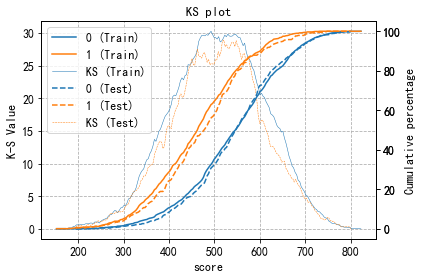

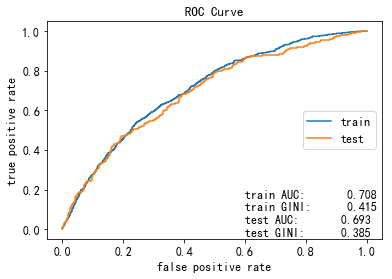

In [459]:
credit_card(df,columns_rfe,'y2')

In [460]:
df[columns_rfe].corr()

age_woe  company_duty_name_woe  \
age_woe                             1.000000               0.313761   
company_duty_name_woe               0.313761               1.000000   
credit_dept_overdue_ratio_woe       0.070232               0.082778   
nsex_woe                            0.015258               0.008698   
observation_overdue10day_times_woe -0.038060              -0.107332   
observation_overdue5day_amount_woe -0.108565              -0.158788   
onway_loan_times_woe                0.075457              -0.018931   
onway_overdue_days_max_woe          0.059751               0.056388   
onway_overdue_terms_woe             0.046775               0.017241   
overdue_amount_last_6months_woe    -0.111481              -0.118930   
prepay_amount_last_3months_woe      0.059927               0.079805   
province_woe                        0.184381               0.196548   

                                    credit_dept_overdue_ratio_woe  nsex_woe  \
age_woe                                                  0.070232  0.015258   
company_duty_name_woe                                    0.082778  0.008698   
credit_dept_overdue_ratio_woe                            1.000000 -0.009519   
nsex_woe                                                -0.009519  1.000000   
observation_overdue10day_times_woe                      -0.068695 -0.015511   
observation_overdue5day_amount_woe                       0.003908 -0.003548   
onway_loan_times_woe                                    -0.068877  0.043001   
onway_overdue_days_max_woe                               0.069706  0.057896   
onway_overdue_terms_woe                                  0.017358  0.052459   
overdue_amount_last_6months_woe                          0.035407  0.012086   
prepay_amount_last_3months_woe                           0.037317  0.017795   
province_woe                                             0.172070  0.018769   

                                    observation_overdue10day_times_woe  \
age_woe                                                      -0.038060   
company_duty_name_woe                                        -0.107332   
credit_dept_overdue_ratio_woe                                -0.068695   
nsex_woe                                                     -0.015511   
observation_overdue10day_times_woe                            1.000000   
observation_overdue5day_amount_woe                            0.373976   
onway_loan_times_woe                                          0.343834   
onway_overdue_days_max_woe                                    0.022337   
onway_overdue_terms_woe                                       0.160013   
overdue_amount_last_6months_woe                               0.075991   
prepay_amount_last_3months_woe                               -0.120957   
province_woe                                                 -0.097605   

                                    observation_overdue5day_amount_woe  \
age_woe                                                      -0.108565   
company_duty_name_woe                                        -0.158788   
credit_dept_overdue_ratio_woe                                 0.003908   
nsex_woe                                                     -0.003548   
observation_overdue10day_times_woe                            0.373976   
observation_overdue5day_amount_woe                            1.000000   
onway_loan_times_woe                                          0.114778   
onway_overdue_days_max_woe                                    0.208264   
onway_overdue_terms_woe                                       0.125808   
overdue_amount_last_6months_woe                               0.305598   
prepay_amount_last_3months_woe                               -0.139567   
province_woe                                                 -0.086011   

                                    onway_loan_times_woe  \
age_woe                                         0.075457   
company_duty_name_woe                  